## Importação de bibliotecas

In [1]:
!git clone https://github.com/luizh3nriqu3/data-science-projects.git

Cloning into 'data-science-projects'...
remote: Enumerating objects: 23945, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 23945 (delta 1), reused 8 (delta 1), pack-reused 23936 (from 2)
Receiving objects: 100% (23945/23945), 120.29 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.5 MB/s eta 0:00:00


In [3]:
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulação
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime
import random
from itertools import product
import optuna

# Métricas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

# DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint

## Importação da base

In [4]:
# Lista de arquivos ZIP
zip_files = [
    "/content/data-science-projects/deep-learning/data/BBAS3.SA.zip",
    "/content/data-science-projects/deep-learning/data/CSNA3.SA.zip",
    "/content/data-science-projects/deep-learning/data/PETR4.SA.zip",
    "/content/data-science-projects/deep-learning/data/VALE3.SA.zip",
    "/content/data-science-projects/deep-learning/data/CDI.zip"
]

# Descompacta apenas se ainda não estiver descompactado
for zip_file in zip_files:
    folder_name = zip_file.replace(".zip", "")  # Define a pasta destino
    if not os.path.exists(folder_name):  # Verifica se já foi descompactado
        os.makedirs(folder_name, exist_ok=True)  # Cria a pasta se não existir
        !unzip -o -j "{zip_file}" -d "{folder_name}"  # Extração sem estrutura de diretórios
        print(f"Descompactado: {zip_file}")
    else:
        print(f"Já está descompactado: {zip_file}")


Archive:  /content/data-science-projects/deep-learning/data/BBAS3.SA.zip
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/._BBAS3.SA  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/._.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/visualizacao.html  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/teste.csv  
  inflating: /content/data-science-projects/deep-learning/data/BBAS3.SA/treino.csv  
Descompactado: /content/data-science-projects/deep-learning/data/BBAS3.SA.zip
Archive:  /content/data-science-projects/deep-learning/data/CSNA3.SA.zip
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/._CSNA3.SA  
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/.DS_Store  
  inflating: /content/data-science-projects/deep-learning/data/CSNA3.SA/._.DS_Store  
  inf

In [5]:
def load_data(path):
    df_train = pd.read_csv(os.path.join(path, "treino.csv"))
    df_test = pd.read_csv(os.path.join(path, "teste.csv"))
    return df_train, df_test

In [6]:
## BBAS3
bb_train, bb_test = load_data("/content/data-science-projects/deep-learning/data/BBAS3.SA")

## CSNA3
cs_train, cs_test = load_data("/content/data-science-projects/deep-learning/data/CSNA3.SA")

## PETR4
pe_train, pe_test = load_data("/content/data-science-projects/deep-learning/data/PETR4.SA")

## VALE3
vl_train, vl_test = load_data("/content/data-science-projects/deep-learning/data/VALE3.SA")

## CDI
cdi = pd.read_csv("/content/data-science-projects/deep-learning/data/CDI/CDI.csv")

In [7]:
for col in cdi.columns:
    if col != "Ano":
        cdi[col] = (
            cdi[col]
            .astype(str)
            .str.replace(",", ".")
            .replace("---", None)
            .astype(float)
        )


In [8]:
bb_test

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4736,2019-03-26,36.386158,37.917648,-1,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129
1,4737,2019-03-27,34.371300,37.563014,-1,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866
2,4738,2019-03-28,35.571316,37.363844,-1,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150
3,4739,2019-03-29,36.089863,37.236446,-1,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489
4,4740,2019-04-01,36.445412,37.157342,-1,36.089863,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,5916,2023-12-21,54.290001,53.331493,1,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074,53.928764
1181,5917,2023-12-22,54.439999,53.442343,1,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391,54.038074
1182,5918,2023-12-26,54.939999,53.592109,1,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391,53.829391
1183,5919,2023-12-27,54.860001,53.718898,1,54.939999,54.439999,54.290001,54.209999,54.849998,54.650002,54.610001,53.330002,52.980000,52.500000,54.097694,54.107632,53.531277,52.676685,53.829391


## EDA

In [9]:
df_bb = pd.concat([bb_train, bb_test], ignore_index=True)
df_cs = pd.concat([cs_train, cs_test], ignore_index=True)
df_pe = pd.concat([pe_train, pe_test], ignore_index=True)
df_vl = pd.concat([vl_train, vl_test], ignore_index=True)

In [10]:
def freq_class(dfs_dict, target):
    num_dfs = len(dfs_dict)

    cols = 2
    rows = math.ceil(num_dfs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    freq_list = []

    for i, (df_name, df) in enumerate(dfs_dict.items()):
        freq = df[target].value_counts().reset_index()
        freq.columns = ['Classe', 'Frequência']
        freq_list.append((df_name, freq))

        sns.barplot(x=freq['Classe'], y=freq['Frequência'], ax=axes[i], color="blue")

        axes[i].set_title(f'Distribuição de {target} - {df_name}')
        axes[i].set_xlabel(target)
        axes[i].set_ylabel('Frequência')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return freq_list

In [11]:
def plot_hist(dfs_dict, target, bins=10):
    num_dfs = len(dfs_dict)

    cols = 2
    rows = math.ceil(num_dfs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for i, (df_name, df) in enumerate(dfs_dict.items()):
        sns.histplot(data=df[target], bins=bins, ax=axes[i], kde=True, color="blue")
        axes[i].set_title(f'Histograma de {target} - {df_name}')
        axes[i].set_xlabel(target)
        axes[i].set_ylabel('Frequência')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

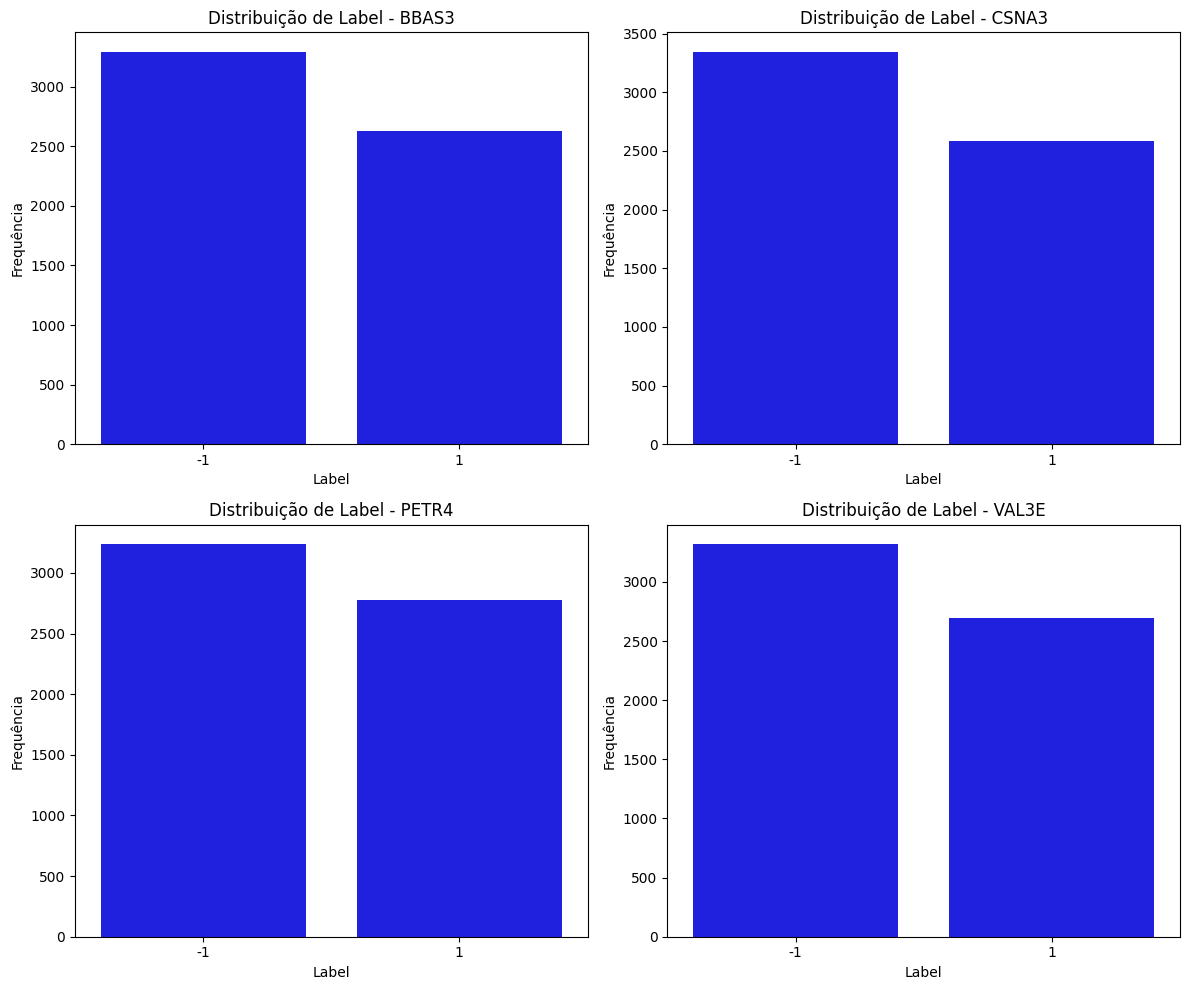

In [12]:
dfs_dict = {"BBAS3": df_bb, "CSNA3": df_cs, "PETR4": df_pe, "VAL3E": df_vl}
frequencias = freq_class(dfs_dict, 'Label')

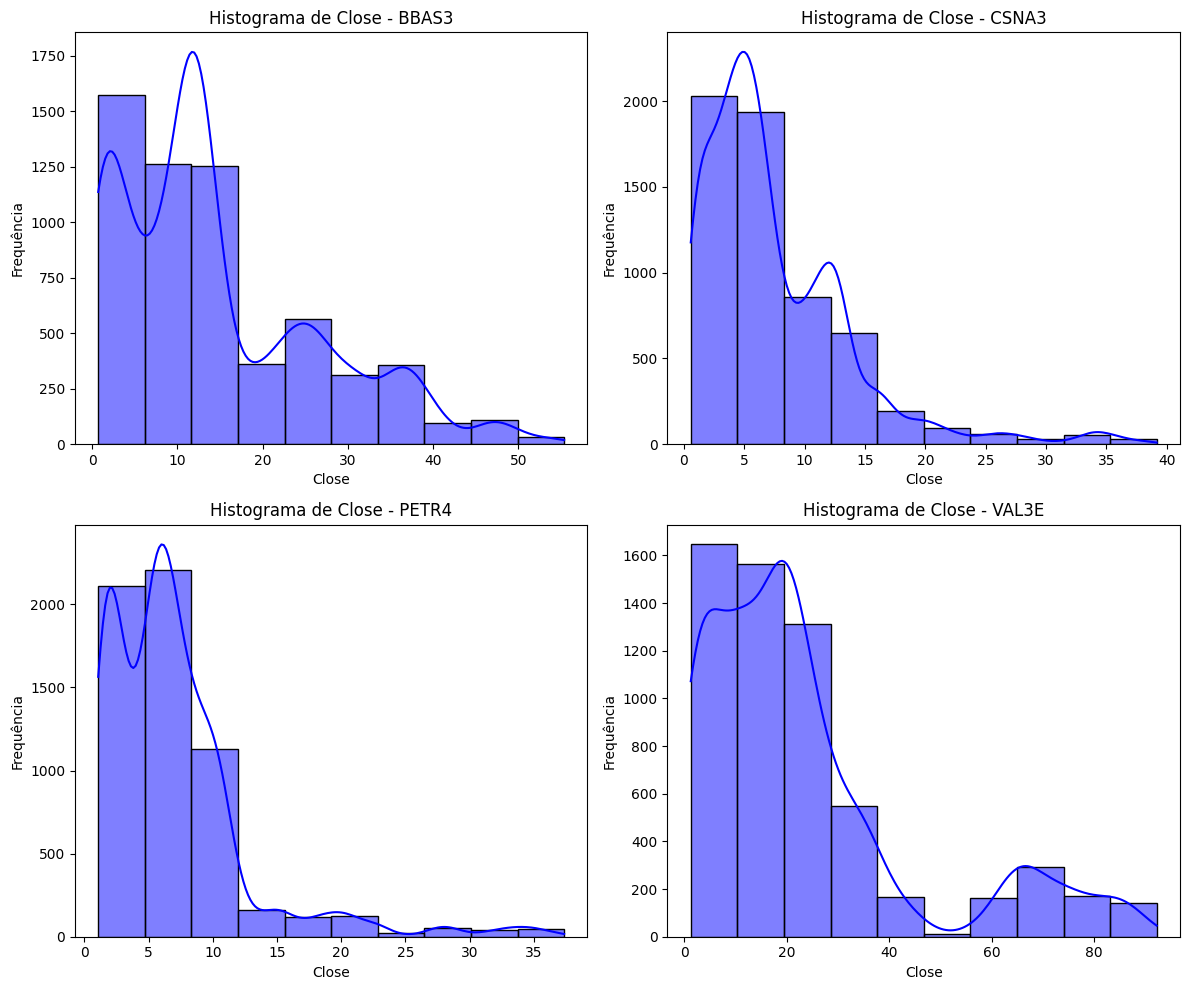

In [13]:
histogramas = plot_hist(dfs_dict, 'Close')

## Pipeline de treinamento e teste

### Funções

In [14]:
def preprocess_data(train_df, test_df, split_features=None):

    scaler = StandardScaler()

    features = [f"Past_{i}_Days_Close" for i in range(1, 16)]
    X_train = train_df[features].values
    X_test = test_df[features].values

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = train_df["Label"].replace({-1: 0, 1: 1}).values
    y_test = test_df["Label"].replace({-1: 0, 1: 1}).values

    if split_features is not None:
        processed = []
        for feature_group in split_features:
            idx = [features.index(col) for col in feature_group]
            reshaped_train = X_train[:, idx].reshape((X_train.shape[0], len(feature_group), 1))
            reshaped_test = X_test[:, idx].reshape((X_test.shape[0], len(feature_group), 1))
            processed.extend([reshaped_train, reshaped_test])
        return (*processed, y_train, y_test, features)
    else:
        X_train = X_train.reshape((X_train.shape[0], len(features), 1))
        X_test = X_test.reshape((X_test.shape[0], len(features), 1))
        return X_train, X_test, y_train, y_test, features

In [15]:
def train_model(model_fn, X_train, y_train, X_test, y_test,
                prob=0.5, n_trials=20, metric_to_optimize='macro_recall',
                model_path='best_model.keras'):

    results = []
    best_model = None
    best_history = None
    best_metrics = None
    best_y_pred = None

    model_dir = "/content/data-science-projects/deep-learning/models"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, os.path.basename(model_path))

    def ensure_input_format(X):
        if isinstance(X, (list, tuple)):
            return X
        return [X]

    def objective(trial):
        nonlocal best_model, best_history, best_metrics, best_y_pred

        epochs = trial.suggest_int('epochs', 10, 50)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        lr = trial.suggest_float('learning_rate', 1e-5, 1e-2)
        stop_patience = trial.suggest_int('stop_patience', 3, 10)
        reduce_lr_factor = trial.suggest_float('reduce_lr_factor', 0.1, 0.5)
        reduce_lr_patience = trial.suggest_int('reduce_lr_patience', 2, 5)

        model = model_fn()
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=stop_patience, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor="val_loss", factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=1e-6, verbose=1),
            ModelCheckpoint(
                filepath=model_path,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            )
        ]

        X_train_input = ensure_input_format(X_train)
        X_test_input = ensure_input_format(X_test)

        if len(X_train_input) == 1:
            X_train_input = X_train_input[0]
            X_test_input = X_test_input[0]

        history = model.fit(
            X_train_input, y_train,
            validation_data=(X_test_input, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        model.load_weights(model_path)

        y_pred_prob = model.predict(X_test_input)
        y_pred = (y_pred_prob > prob).astype(int)

        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)

        metric_map = {
            'macro_recall': report['macro avg']['recall'],
            'weighted_recall': report['weighted avg']['recall'],
            'Compra (1)_recall': report['1']['recall'],
            'Vende (0)_recall': report['0']['recall'],
            'Compra (1)_precision': report['1']['precision'],
            'Vende (0)_precision': report['0']['precision'],
            'accuracy': accuracy
        }

        if metric_to_optimize == "val_loss":
            val_loss = min(history.history["val_loss"])
            score = -val_loss
        else:
            score = metric_map.get(metric_to_optimize, report['macro avg']['recall'])

        metrics = {
            'accuracy': accuracy,
            'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
            'class_metrics': {
                'Vende (0)': report['0'],
                'Compra (1)': report['1']
            },
            'macro_avg': report['macro avg'],
            'weighted_avg': report['weighted avg']
        }

        results.append({
            'trial': trial.number,
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': lr,
            'stop_patience': stop_patience,
            'reduce_lr_factor': reduce_lr_factor,
            'reduce_lr_patience': reduce_lr_patience,
            'recall_Compra(1)': report['1']['recall'],
            'recall_Vende(0)': report['0']['recall'],
            'precision_Compra(1)': report['1']['precision'],
            'precision_Vende(0)': report['0']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'accuracy': accuracy,
            'f1_macro': report['macro avg']['f1-score'],
            'f1_weighted': report['weighted avg']['f1-score'],
            'min_val_loss': min(history.history["val_loss"])
        })

        if score > objective.best_score:
            objective.best_score = score
            best_model = model
            best_history = history
            best_metrics = metrics
            best_y_pred = y_pred

        return score

    objective.best_score = -np.inf

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    df_results = pd.DataFrame(results).sort_values(
        by=("min_val_loss" if metric_to_optimize == "val_loss" else metric_to_optimize),
        ascending=(True if metric_to_optimize == "val_loss" else False)
    ).reset_index(drop=True)

    print("\n✅ Melhor combinação encontrada:")
    print(df_results.iloc[0])
    print("🔍 Hiperparâmetros:", study.best_params)

    return best_model, best_history, df_results, best_metrics, best_y_pred


In [16]:
def plot_training_history(histories, titles=None):
    n = len(histories)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, history in enumerate(histories):
        ax = axes[i] if n > 1 else axes
        history_dict = history.history
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        epochs = range(1, len(loss) + 1)

        ax.plot(epochs, loss, label='Loss Treino', color='blue')
        ax.plot(epochs, val_loss, label='Loss Validação', color='orange')
        ax.set_title(titles[i])
        ax.set_xlabel('Épocas')
        ax.set_ylabel('Loss')
        ax.grid(True)
        ax.legend()

    plt.suptitle('Evolução da Loss')
    plt.tight_layout()
    plt.show()


In [17]:
def run_backtest(predictions, prices, capital, model_name, stock_name,
                 metrics, cdi_df=None, metric_optimization=None):
    capital_atual = capital
    posicao = 0
    valor_investido = 0
    operacoes = []

    for i in range(len(predictions) - 1):
        preco_atual = prices[i]

        if predictions[i] == 1 and capital_atual >= preco_atual:
            qtd_comprada = capital_atual // preco_atual
            valor_compra = qtd_comprada * preco_atual
            posicao += qtd_comprada
            capital_atual -= valor_compra

        elif predictions[i] == 0 and posicao > 0:
            valor_venda = posicao * preco_atual
            capital_atual += valor_venda
            retorno = (valor_venda - valor_compra) / valor_compra if valor_compra > 0 else 0
            operacoes.append(retorno)
            posicao = 0

    valor_investido = posicao * prices.iloc[-1]
    lucro = (capital_atual + valor_investido) - capital
    lucro_percentual = (lucro / capital) * 100

    # Cálculo do CDI no mesmo período
    lucro_cdi_pct = None
    if cdi_df is not None:
        try:
            # Converter o CDI para formato longo
            cdi_long = cdi_df.melt(id_vars='Ano', var_name='Mes', value_name='CDI')
            meses_map = {
                'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6,
                'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12
            }
            cdi_long['Mes_num'] = cdi_long['Mes'].map(meses_map)
            cdi_long['Data'] = pd.to_datetime(dict(year=cdi_long['Ano'], month=cdi_long['Mes_num'], day=1))
            cdi_long['CDI'] = cdi_long['CDI'].astype(float) / 100

            # Filtrar período
            inicio = prices.index.min()
            fim = prices.index.max()
            cdi_periodo = cdi_long[(cdi_long['Data'] >= inicio) & (cdi_long['Data'] <= fim)]

            # Calcular rendimento acumulado
            rendimento_cdi = (1 + cdi_periodo['CDI']).prod() - 1
            lucro_cdi_pct = rendimento_cdi * 100

        except Exception as e:
            print("Erro ao calcular o CDI:", e)

    resultado = {
        "Data": datetime.now(),
        "Modelo": model_name,
        "Ação": stock_name,
        "Métrica de Otimização": metric_optimization,
        "Acurácia": metrics['accuracy'],
        "Precision": metrics['macro_avg']['precision'],
        "Recall": metrics['macro_avg']['recall'],
        "F1": metrics['macro_avg']['f1-score'],
        "Matriz de Confusão": metrics['confusion_matrix'],
        "Saldo Inicial": capital,
        "Saldo Final": capital_atual,
        "Total de Ações": posicao,
        "Lucro Total": lucro,
        "Lucro (%)": lucro_percentual,
        "Lucro (%) CDI": lucro_cdi_pct
    }

    caminho_resultado = "/content/data-science-projects/deep-learning/results"
    caminho_csv = os.path.join(caminho_resultado, "backtest_results.csv")
    os.makedirs(caminho_resultado, exist_ok=True)

    if os.path.exists(caminho_csv):
        df_existente = pd.read_csv(caminho_csv)
        df_novo = pd.concat([df_existente, pd.DataFrame([resultado])], ignore_index=True)
    else:
        df_novo = pd.DataFrame([resultado])

    df_novo.to_csv(caminho_csv, index=False)

    return df_novo


In [18]:
def plot_confusion_matrix(metrics_list, titles=None):
    n = len(metrics_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, metrics in enumerate(metrics_list):
        ax = axes[i] if n > 1 else axes
        cm = metrics['confusion_matrix']
        labels = list(metrics['class_metrics'].keys())

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')

    plt.tight_layout()
    plt.show()


In [19]:
def show_classification_reports(metrics_list, titles=None):
    n = len(metrics_list)
    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i, metrics in enumerate(metrics_list):
        print("=" * 50)
        print(f"📊 Relatório de Classificação - {titles[i]}")
        print("=" * 50)

        for class_name, class_metrics in metrics['class_metrics'].items():
            print(f"\n{class_name}:")
            print(f"Precision: {class_metrics['precision']:.2f}")
            print(f"Recall:    {class_metrics['recall']:.2f}")
            print(f"F1-Score:  {class_metrics['f1-score']:.2f}")

        print("\nMédias:")
        print(f"Acurácia:  {metrics['accuracy']:.2f}")
        print(f"Precision: {metrics['macro_avg']['precision']:.2f}")
        print(f"Recall:    {metrics['macro_avg']['recall']:.2f}")
        print(f"F1-Score:  {metrics['macro_avg']['f1-score']:.2f}")
        print("\n")


In [20]:
def plot_sell_by(prices_list, predictions_list, titles=None):
    n = len(prices_list)
    fig, axes = plt.subplots(1, n, figsize=(8 * n, 5))

    if titles is None:
        titles = [f"Modelo {i+1}" for i in range(n)]

    for i in range(n):
        ax = axes[i] if n > 1 else axes
        prices = prices_list[i]
        predictions = predictions_list[i]

        buy_signals = np.where(predictions == 1)[0]
        sell_signals = np.where(predictions == 0)[0]

        ax.plot(prices, label='Preço da Ação', color='blue', linewidth=1.5)
        ax.scatter(buy_signals, prices[buy_signals], color='green', label='Compra', marker='^', s=100)
        ax.scatter(sell_signals, prices[sell_signals], color='red', label='Venda', marker='v', s=100)

        ax.set_title(titles[i])
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Preço da Ação')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [23]:
def model_cnn_ramificado():
    input1 = Input(shape=(7, 1))
    input2 = Input(shape=(8, 1))

    # Ramo 1
    x1 = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)
    # Ramo 2
    x2 = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(input2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    # Combina os três ramos
    combined = Concatenate()([x1, x2])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[input1, input2], outputs=output)
    return model


In [22]:
def model_cnn_sequencial():
    return Sequential([
        Input(shape=(15, 1)),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

In [21]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

### BBAS3

In [34]:
X_train, X_test, y_train, y_test, features = preprocess_data(bb_train, bb_test)

In [35]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(bb_train, bb_test, split_features=[janela_curta,janela_longa])

In [33]:
prices = bb_test.set_index("Date")["Close"]
titles = ["Modelo Sequencial", "Modelo Ramificado"]
metric_optimization = 'val_loss'

In [36]:
best_seq_model, best_seq_history, df_results, best_seq_metrics, best_seq_y_pred = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_BBAS3.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 14:10:58,396] A new study created in memory with name: no-name-7dc75bc6-5cc2-4359-baa1-6e8d37067e83


Epoch 1/46
137/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5398 - loss: 0.6939
Epoch 1: val_loss improved from inf to 0.76396, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5406 - loss: 0.6936 - val_accuracy: 0.4186 - val_loss: 0.7640 - learning_rate: 0.0097
Epoch 2/46
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5512 - loss: 0.6870
Epoch 2: val_loss improved from 0.76396 to 0.68658, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5511 - loss: 0.6870 - val_accuracy: 0.5814 - val_loss: 0.6866 - learning_rate: 0.0097
Epoch 3/46
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5496 - loss: 0.6892
Epoch 3: val_loss did not improve from 0.68658
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5500 - loss: 0.6891 - val_accuracy: 0.5688 - val_loss: 0.6913 - learning_rate: 0.0097
Epoch 4/46
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5473 - loss: 0.6869
Epoc

[I 2025-04-13 14:11:16,352] Trial 0 finished with value: -0.4114605784416199 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.009721568748326125, 'stop_patience': 3, 'reduce_lr_factor': 0.26361740565916925, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.4114605784416199.


Epoch 1/16
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5439 - loss: 0.6927
Epoch 1: val_loss improved from inf to 0.65626, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5440 - loss: 0.6927 - val_accuracy: 0.5646 - val_loss: 0.6563 - learning_rate: 0.0045
Epoch 2/16
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6082 - loss: 0.6467
Epoch 2: val_loss did not improve from 0.65626
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6091 - loss: 0.6458 - val_accuracy: 0.5857 - val_loss: 0.9903 - learning_rate: 0.0045
Epoch 3/16
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6638 - loss: 0.5855
Epoch 3: val_loss did not improve from 0.65626
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6639 - loss: 0.5853 - val_accuracy: 0.4498 - val_loss: 0.8973 - learning_rate: 0.0045
Epoch 4/16
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6992 - loss: 0.5356
Epoch 4: ReduceLROnPlateau reducing learning rate

[I 2025-04-13 14:11:28,113] Trial 1 finished with value: -0.6562601327896118 and parameters: {'epochs': 16, 'batch_size': 32, 'learning_rate': 0.004492779912052873, 'stop_patience': 3, 'reduce_lr_factor': 0.4287128811342522, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.4114605784416199.


Epoch 1/25
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5403 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.64884, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5410 - loss: 0.6903 - val_accuracy: 0.6278 - val_loss: 0.6488 - learning_rate: 0.0034
Epoch 2/25
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5917 - loss: 0.6567
Epoch 2: val_loss improved from 0.64884 to 0.56037, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5918 - loss: 0.6565 - val_accuracy: 0.7013 - val_loss: 0.5604 - learning_rate: 0.0034
Epoch 3/25
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6543 - loss: 0.5935
Epoch 3: val_loss did not improve from 0.56037
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6548 - loss: 0.5932 - val_accuracy: 0.5840 - val_loss: 0.7332 - learning_rate: 0.0034
Epoch 4/25
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6885 - loss: 0.5492
Epoc

[I 2025-04-13 14:12:29,747] Trial 2 finished with value: -0.3317584991455078 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.003370026652047647, 'stop_patience': 8, 'reduce_lr_factor': 0.4494602293610046, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3317584991455078.


Epoch 1/47
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5520 - loss: 0.6882
Epoch 1: val_loss improved from inf to 0.58405, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5527 - loss: 0.6878 - val_accuracy: 0.6498 - val_loss: 0.5840 - learning_rate: 0.0018
Epoch 2/47
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6426 - loss: 0.6165
Epoch 2: val_loss did not improve from 0.58405
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6430 - loss: 0.6161 - val_accuracy: 0.6093 - val_loss: 1.2098 - learning_rate: 0.0018
Epoch 3/47
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6999 - loss: 0.5566
Epoch 3: val_loss improved from 0.58405 to 0.41784, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7000 - loss: 0.5564 - val_accuracy: 0.8084 - val_loss: 0.4178 - learning_rate: 0.0018
Epoch 4/47
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6949 - loss: 0.5401
Epoc

[I 2025-04-13 14:12:59,854] Trial 3 finished with value: -0.3488464057445526 and parameters: {'epochs': 47, 'batch_size': 16, 'learning_rate': 0.0017835238938513941, 'stop_patience': 5, 'reduce_lr_factor': 0.3921727630483849, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3317584991455078.


Epoch 1/46
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5451 - loss: 0.6918
Epoch 1: val_loss improved from inf to 0.68308, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5453 - loss: 0.6917 - val_accuracy: 0.6152 - val_loss: 0.6831 - learning_rate: 0.0076
Epoch 2/46
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5466 - loss: 0.6884
Epoch 2: val_loss did not improve from 0.68308
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5468 - loss: 0.6884 - val_accuracy: 0.5696 - val_loss: 0.6857 - learning_rate: 0.0076
Epoch 3/46
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5561 - loss: 0.6851
Epoch 3: val_loss did not improve from 0.68308
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5563 - loss: 0.6850 - val_accuracy: 0.5468 - val_loss: 0.7643 - learning_rate: 0.0076
Epoch 4/46
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.6372
Epoch 4: val_loss improved from 0.68308 to 0.58798

[I 2025-04-13 14:13:16,337] Trial 4 finished with value: -0.3823961019515991 and parameters: {'epochs': 46, 'batch_size': 16, 'learning_rate': 0.007554379714504587, 'stop_patience': 3, 'reduce_lr_factor': 0.47803707090487835, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3317584991455078.


Epoch 1/36
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5471 - loss: 0.6932
Epoch 1: val_loss improved from inf to 0.77198, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5477 - loss: 0.6928 - val_accuracy: 0.4186 - val_loss: 0.7720 - learning_rate: 0.0093
Epoch 2/36
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5533 - loss: 0.6827
Epoch 2: val_loss improved from 0.77198 to 0.66312, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5540 - loss: 0.6825 - val_accuracy: 0.5789 - val_loss: 0.6631 - learning_rate: 0.0093
Epoch 3/36
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5739 - loss: 0.6640
Epoch 3: val_loss improved from 0.66312 to 0.61799, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5749 - loss: 0.6627 - val_accuracy: 0.6895 - val_loss: 0.6180 - learning_rate: 0.0093
Epoch 4/36
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-13 14:13:35,371] Trial 5 finished with value: -0.3610948622226715 and parameters: {'epochs': 36, 'batch_size': 64, 'learning_rate': 0.00928100665387011, 'stop_patience': 5, 'reduce_lr_factor': 0.2848079995284004, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3317584991455078.


Epoch 1/25
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5549 - loss: 0.6885
Epoch 1: val_loss improved from inf to 0.67750, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5552 - loss: 0.6883 - val_accuracy: 0.5629 - val_loss: 0.6775 - learning_rate: 0.0012
Epoch 2/25
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6235 - loss: 0.6387
Epoch 2: val_loss improved from 0.67750 to 0.55844, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6241 - loss: 0.6381 - val_accuracy: 0.7038 - val_loss: 0.5584 - learning_rate: 0.0012
Epoch 3/25
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6739 - loss: 0.5679
Epoch 3: val_loss improved from 0.55844 to 0.55734, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6741 - loss: 0.5677 - val_accuracy: 0.7392 - val_loss: 0.5573 - learning_rate: 0.0012
Epoch 4/25
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:14:22,116] Trial 6 finished with value: -0.3146595358848572 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.0011531042128168033, 'stop_patience': 7, 'reduce_lr_factor': 0.20342821574718967, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/36
134/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5365 - loss: 0.6935
Epoch 1: val_loss improved from inf to 0.68172, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5375 - loss: 0.6932 - val_accuracy: 0.5814 - val_loss: 0.6817 - learning_rate: 0.0088
Epoch 2/36
135/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5412 - loss: 0.6871
Epoch 2: val_loss improved from 0.68172 to 0.63618, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5419 - loss: 0.6869 - val_accuracy: 0.6903 - val_loss: 0.6362 - learning_rate: 0.0088
Epoch 3/36
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5767 - loss: 0.6585
Epoch 3: val_loss did not improve from 0.63618
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5775 - loss: 0.6578 - val_accuracy: 0.6684 - val_loss: 0.7789 - learning_rate: 0.0088
Epoch 4/36
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6510 - loss: 0.5838
Epoc

[I 2025-04-13 14:14:36,889] Trial 7 finished with value: -0.4252716302871704 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.00876288610319252, 'stop_patience': 4, 'reduce_lr_factor': 0.28721851140174737, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/40
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5406 - loss: 0.6933
Epoch 1: val_loss improved from inf to 0.67937, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5412 - loss: 0.6930 - val_accuracy: 0.6110 - val_loss: 0.6794 - learning_rate: 0.0039
Epoch 2/40
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6110 - loss: 0.6531
Epoch 2: val_loss improved from 0.67937 to 0.66935, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6118 - loss: 0.6521 - val_accuracy: 0.5806 - val_loss: 0.6693 - learning_rate: 0.0039
Epoch 3/40
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6222 - loss: 0.6081
Epoch 3: val_loss did not improve from 0.66935
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6226 - loss: 0.6078 - val_accuracy: 0.6532 - val_loss: 0.6758 - learning_rate: 0.0039
Epoch 4/40
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6758 - loss: 0.5787
Epoc

[I 2025-04-13 14:14:57,716] Trial 8 finished with value: -0.35904166102409363 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.003932487731588975, 'stop_patience': 7, 'reduce_lr_factor': 0.25339377815478004, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/11
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5415 - loss: 0.6927
Epoch 1: val_loss improved from inf to 0.68056, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5415 - loss: 0.6927 - val_accuracy: 0.5814 - val_loss: 0.6806 - learning_rate: 0.0061
Epoch 2/11
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5473 - loss: 0.6898
Epoch 2: val_loss improved from 0.68056 to 0.67772, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5474 - loss: 0.6898 - val_accuracy: 0.5814 - val_loss: 0.6777 - learning_rate: 0.0061
Epoch 3/11
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5486 - loss: 0.6889
Epoch 3: val_loss did not improve from 0.67772
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5487 - loss: 0.6889 - val_accuracy: 0.4608 - val_loss: 0.7009 - learning_rate: 0.0061
Epoch 4/11
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5499 - loss: 0.6847
Epoc

[I 2025-04-13 14:15:22,368] Trial 9 finished with value: -0.41748377680778503 and parameters: {'epochs': 11, 'batch_size': 16, 'learning_rate': 0.006129626235579851, 'stop_patience': 9, 'reduce_lr_factor': 0.2781146053274137, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/25
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5480 - loss: 0.6896
Epoch 1: val_loss improved from inf to 0.66986, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5496 - loss: 0.6891 - val_accuracy: 0.5367 - val_loss: 0.6699 - learning_rate: 6.2368e-04
Epoch 2/25
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5817 - loss: 0.6691
Epoch 2: val_loss improved from 0.66986 to 0.50698, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5829 - loss: 0.6680 - val_accuracy: 0.7764 - val_loss: 0.5070 - learning_rate: 6.2368e-04
Epoch 3/25
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6481 - loss: 0.6296
Epoch 3: val_loss improved from 0.50698 to 0.42589, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6492 - loss: 0.6273 - val_accuracy: 0.8000 - val_loss: 0.4259 - learning_rate: 6.2368e-04
Epoch 4/25
65/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

[I 2025-04-13 14:15:35,321] Trial 10 finished with value: -0.38714686036109924 and parameters: {'epochs': 25, 'batch_size': 64, 'learning_rate': 0.0006236794187461012, 'stop_patience': 10, 'reduce_lr_factor': 0.14946814215351428, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/24
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5530 - loss: 0.6919
Epoch 1: val_loss improved from inf to 0.80121, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5534 - loss: 0.6917 - val_accuracy: 0.4582 - val_loss: 0.8012 - learning_rate: 0.0027
Epoch 2/24
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5809 - loss: 0.6719
Epoch 2: val_loss improved from 0.80121 to 0.59234, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5815 - loss: 0.6714 - val_accuracy: 0.6481 - val_loss: 0.5923 - learning_rate: 0.0027
Epoch 3/24
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6315 - loss: 0.6139
Epoch 3: val_loss improved from 0.59234 to 0.41732, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6320 - loss: 0.6137 - val_accuracy: 0.8219 - val_loss: 0.4173 - learning_rate: 0.0027
Epoch 4/24
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:16:23,088] Trial 11 finished with value: -0.31898051500320435 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.002719683792365846, 'stop_patience': 8, 'reduce_lr_factor': 0.1642699951599007, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/22
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5448 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.69380, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5452 - loss: 0.6889 - val_accuracy: 0.5072 - val_loss: 0.6938 - learning_rate: 0.0024
Epoch 2/22
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5751 - loss: 0.6720
Epoch 2: val_loss did not improve from 0.69380
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5758 - loss: 0.6715 - val_accuracy: 0.5148 - val_loss: 0.6953 - learning_rate: 0.0024
Epoch 3/22
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 0.6045
Epoch 3: val_loss did not improve from 0.69380
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6545 - loss: 0.6040 - val_accuracy: 0.5907 - val_loss: 0.7882 - learning_rate: 0.0024
Epoch 4/22
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7013 - loss: 0.5594
Epoch 4: val_loss improved from 0.69380 to 0.37929

[I 2025-04-13 14:16:56,097] Trial 12 finished with value: -0.3214709460735321 and parameters: {'epochs': 22, 'batch_size': 16, 'learning_rate': 0.0023993585829373476, 'stop_patience': 7, 'reduce_lr_factor': 0.14477033993683475, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/30
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5439 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.57125, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5449 - loss: 0.6887 - val_accuracy: 0.8194 - val_loss: 0.5712 - learning_rate: 5.0003e-04
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6136 - loss: 0.6544
Epoch 2: val_loss improved from 0.57125 to 0.56228, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6136 - loss: 0.6544 - val_accuracy: 0.7072 - val_loss: 0.5623 - learning_rate: 5.0003e-04
Epoch 3/30
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6708 - loss: 0.5864
Epoch 3: val_loss did not improve from 0.56228
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6709 - loss: 0.5863 - val_accuracy: 0.6422 - val_loss: 0.8821 - learning_rate: 5.0003e-04
Epoch 4/30
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6966 - loss:

[I 2025-04-13 14:17:30,301] Trial 13 finished with value: -0.3189051151275635 and parameters: {'epochs': 30, 'batch_size': 16, 'learning_rate': 0.0005000309569960677, 'stop_patience': 6, 'reduce_lr_factor': 0.19452654593547689, 'reduce_lr_patience': 5}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/31
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5038 - loss: 0.6938
Epoch 1: val_loss improved from inf to 0.69018, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5045 - loss: 0.6938 - val_accuracy: 0.5949 - val_loss: 0.6902 - learning_rate: 2.5694e-05
Epoch 2/31
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5686 - loss: 0.6906
Epoch 2: val_loss did not improve from 0.69018
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5685 - loss: 0.6905 - val_accuracy: 0.4329 - val_loss: 0.6914 - learning_rate: 2.5694e-05
Epoch 3/31
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5649 - loss: 0.6879
Epoch 3: val_loss did not improve from 0.69018
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5649 - loss: 0.6879 - val_accuracy: 0.4287 - val_loss: 0.6931 - learning_rate: 2.5694e-05
Epoch 4/31
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5729 - loss: 0.6869
Epoch 4: val_loss did not improve from

[I 2025-04-13 14:18:31,247] Trial 14 finished with value: -0.5166605114936829 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 2.569358473629977e-05, 'stop_patience': 6, 'reduce_lr_factor': 0.21151050878746627, 'reduce_lr_patience': 4}. Best is trial 6 with value: -0.3146595358848572.


Epoch 1/31
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5580 - loss: 0.6873
Epoch 1: val_loss improved from inf to 0.54054, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5584 - loss: 0.6870 - val_accuracy: 0.7190 - val_loss: 0.5405 - learning_rate: 0.0011
Epoch 2/31
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - loss: 0.6112
Epoch 2: val_loss improved from 0.54054 to 0.40400, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6544 - loss: 0.6102 - val_accuracy: 0.8338 - val_loss: 0.4040 - learning_rate: 0.0011
Epoch 3/31
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6964 - loss: 0.5417
Epoch 3: val_loss improved from 0.40400 to 0.38089, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6970 - loss: 0.5413 - val_accuracy: 0.8143 - val_loss: 0.3809 - learning_rate: 0.0011
Epoch 4/31
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:19:19,425] Trial 15 finished with value: -0.30246502161026 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 0.0011175725426261116, 'stop_patience': 6, 'reduce_lr_factor': 0.3544570736105101, 'reduce_lr_patience': 5}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5355 - loss: 0.6942
Epoch 1: val_loss improved from inf to 0.67790, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5358 - loss: 0.6942 - val_accuracy: 0.6447 - val_loss: 0.6779 - learning_rate: 0.0059
Epoch 2/17
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5525 - loss: 0.6857
Epoch 2: val_loss improved from 0.67790 to 0.67568, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5526 - loss: 0.6856 - val_accuracy: 0.6152 - val_loss: 0.6757 - learning_rate: 0.0059
Epoch 3/17
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5768 - loss: 0.6660
Epoch 3: val_loss improved from 0.67568 to 0.62074, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5774 - loss: 0.6654 - val_accuracy: 0.6624 - val_loss: 0.6207 - learning_rate: 0.0059
Epoch 4/17
66/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

[I 2025-04-13 14:19:35,335] Trial 16 finished with value: -0.3355708718299866 and parameters: {'epochs': 17, 'batch_size': 64, 'learning_rate': 0.005904596817204087, 'stop_patience': 8, 'reduce_lr_factor': 0.349594010215752, 'reduce_lr_patience': 4}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/31
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5545 - loss: 0.6874
Epoch 1: val_loss improved from inf to 0.93518, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5548 - loss: 0.6871 - val_accuracy: 0.5013 - val_loss: 0.9352 - learning_rate: 0.0014
Epoch 2/31
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6384 - loss: 0.6235
Epoch 2: val_loss improved from 0.93518 to 0.43756, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6391 - loss: 0.6225 - val_accuracy: 0.7722 - val_loss: 0.4376 - learning_rate: 0.0014
Epoch 3/31
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6767 - loss: 0.5618
Epoch 3: val_loss did not improve from 0.43756
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6770 - loss: 0.5616 - val_accuracy: 0.6473 - val_loss: 0.5674 - learning_rate: 0.0014
Epoch 4/31
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6966 - loss: 0.5328
Epoc

[I 2025-04-13 14:20:09,893] Trial 17 finished with value: -0.3295001983642578 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 0.0013896595989517496, 'stop_patience': 5, 'reduce_lr_factor': 0.3479105851427029, 'reduce_lr_patience': 2}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/40
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5438 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.62106, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5441 - loss: 0.6914 - val_accuracy: 0.6878 - val_loss: 0.6211 - learning_rate: 0.0014
Epoch 2/40
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6075 - loss: 0.6508
Epoch 2: val_loss did not improve from 0.62106
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6080 - loss: 0.6503 - val_accuracy: 0.5823 - val_loss: 0.7765 - learning_rate: 0.0014
Epoch 3/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6633 - loss: 0.5790
Epoch 3: val_loss improved from 0.62106 to 0.58403, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6633 - loss: 0.5789 - val_accuracy: 0.6684 - val_loss: 0.5840 - learning_rate: 0.0014
Epoch 4/40
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6968 - loss: 0.5354
Epoc

[I 2025-04-13 14:20:43,582] Trial 18 finished with value: -0.3425428569316864 and parameters: {'epochs': 40, 'batch_size': 16, 'learning_rate': 0.001423593156946144, 'stop_patience': 7, 'reduce_lr_factor': 0.1002626709505014, 'reduce_lr_patience': 5}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/18
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5380 - loss: 0.6923
Epoch 1: val_loss improved from inf to 0.73193, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5391 - loss: 0.6918 - val_accuracy: 0.4219 - val_loss: 0.7319 - learning_rate: 0.0052
Epoch 2/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5624 - loss: 0.6782
Epoch 2: val_loss did not improve from 0.73193
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5626 - loss: 0.6781 - val_accuracy: 0.5814 - val_loss: 0.7377 - learning_rate: 0.0052
Epoch 3/18
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6058 - loss: 0.6460
Epoch 3: val_loss improved from 0.73193 to 0.49947, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6064 - loss: 0.6455 - val_accuracy: 0.7384 - val_loss: 0.4995 - learning_rate: 0.0052
Epoch 4/18
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6535 - loss: 0.6085
Epoch 4: val_loss

[I 2025-04-13 14:20:59,953] Trial 19 finished with value: -0.36368051171302795 and parameters: {'epochs': 18, 'batch_size': 64, 'learning_rate': 0.0051779947657113745, 'stop_patience': 6, 'reduce_lr_factor': 0.32693144286536235, 'reduce_lr_patience': 4}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/35
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5532 - loss: 0.6923
Epoch 1: val_loss improved from inf to 0.78613, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5536 - loss: 0.6919 - val_accuracy: 0.4768 - val_loss: 0.7861 - learning_rate: 0.0030
Epoch 2/35
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6052 - loss: 0.6554
Epoch 2: val_loss did not improve from 0.78613
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6054 - loss: 0.6552 - val_accuracy: 0.4278 - val_loss: 1.0306 - learning_rate: 0.0030
Epoch 3/35
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6563 - loss: 0.5867
Epoch 3: val_loss improved from 0.78613 to 0.61787, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6565 - loss: 0.5866 - val_accuracy: 0.5603 - val_loss: 0.6179 - learning_rate: 0.0030
Epoch 4/35
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6773 - loss: 0.5536
Epoc

[I 2025-04-13 14:21:45,206] Trial 20 finished with value: -0.3438217341899872 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.0029699554738020946, 'stop_patience': 9, 'reduce_lr_factor': 0.22085029851040527, 'reduce_lr_patience': 5}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/28
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5555 - loss: 0.6914
Epoch 1: val_loss improved from inf to 0.67731, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5556 - loss: 0.6914 - val_accuracy: 0.5814 - val_loss: 0.6773 - learning_rate: 5.8834e-05
Epoch 2/28
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5593 - loss: 0.6880
Epoch 2: val_loss improved from 0.67731 to 0.67346, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5595 - loss: 0.6880 - val_accuracy: 0.6819 - val_loss: 0.6735 - learning_rate: 5.8834e-05
Epoch 3/28
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5662 - loss: 0.6831
Epoch 3: val_loss improved from 0.67346 to 0.66135, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5663 - loss: 0.6831 - val_accuracy: 0.6776 - val_loss: 0.6614 - learning_rate: 5.8834e-05
Epoch 4/28
293/296 ━━━━━━━━━━━━━

[I 2025-04-13 14:22:23,461] Trial 21 finished with value: -0.3926068842411041 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 5.883383735221729e-05, 'stop_patience': 6, 'reduce_lr_factor': 0.20489636885444698, 'reduce_lr_patience': 5}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/29
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5418 - loss: 0.6897
Epoch 1: val_loss improved from inf to 0.64960, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5425 - loss: 0.6895 - val_accuracy: 0.6068 - val_loss: 0.6496 - learning_rate: 9.2489e-04
Epoch 2/29
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6304 - loss: 0.6301
Epoch 2: val_loss did not improve from 0.64960
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6312 - loss: 0.6293 - val_accuracy: 0.6160 - val_loss: 0.6910 - learning_rate: 9.2489e-04
Epoch 3/29
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6765 - loss: 0.5605
Epoch 3: val_loss improved from 0.64960 to 0.45642, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6768 - loss: 0.5603 - val_accuracy: 0.7764 - val_loss: 0.4564 - learning_rate: 9.2489e-04
Epoch 4/29
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6970 - loss:

[I 2025-04-13 14:22:54,531] Trial 22 finished with value: -0.32998356223106384 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.0009248869788278925, 'stop_patience': 6, 'reduce_lr_factor': 0.3878626153768958, 'reduce_lr_patience': 5}. Best is trial 15 with value: -0.30246502161026.


Epoch 1/20
280/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5465 - loss: 0.6892
Epoch 1: val_loss improved from inf to 0.64883, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5476 - loss: 0.6886 - val_accuracy: 0.6228 - val_loss: 0.6488 - learning_rate: 0.0020
Epoch 2/20
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6358 - loss: 0.6157
Epoch 2: val_loss improved from 0.64883 to 0.41690, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6366 - loss: 0.6150 - val_accuracy: 0.7992 - val_loss: 0.4169 - learning_rate: 0.0020
Epoch 3/20
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6847 - loss: 0.5574
Epoch 3: val_loss did not improve from 0.41690
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6851 - loss: 0.5571 - val_accuracy: 0.7544 - val_loss: 0.5556 - learning_rate: 0.0020
Epoch 4/20
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7095 - loss: 0.5259
Epoc

[I 2025-04-13 14:23:32,934] Trial 23 finished with value: -0.2992369532585144 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.0019772383596792587, 'stop_patience': 5, 'reduce_lr_factor': 0.17321834212101725, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2992369532585144.


Epoch 1/20
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5443 - loss: 0.6887
Epoch 1: val_loss improved from inf to 0.65393, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5451 - loss: 0.6885 - val_accuracy: 0.6278 - val_loss: 0.6539 - learning_rate: 0.0021
Epoch 2/20
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5894 - loss: 0.6574
Epoch 2: val_loss did not improve from 0.65393
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5896 - loss: 0.6573 - val_accuracy: 0.4312 - val_loss: 1.2324 - learning_rate: 0.0021
Epoch 3/20
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6543 - loss: 0.5909
Epoch 3: val_loss improved from 0.65393 to 0.52739, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6546 - loss: 0.5904 - val_accuracy: 0.7519 - val_loss: 0.5274 - learning_rate: 0.0021
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6989 - loss: 0.5365
Epoc

[I 2025-04-13 14:24:01,501] Trial 24 finished with value: -0.3213954567909241 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.00209864434159468, 'stop_patience': 4, 'reduce_lr_factor': 0.10358624837160317, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2992369532585144.


Epoch 1/12
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5577 - loss: 0.6888
Epoch 1: val_loss improved from inf to 0.76519, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5580 - loss: 0.6887 - val_accuracy: 0.5409 - val_loss: 0.7652 - learning_rate: 0.0013
Epoch 2/12
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6248 - loss: 0.6325
Epoch 2: val_loss improved from 0.76519 to 0.50413, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6255 - loss: 0.6316 - val_accuracy: 0.7308 - val_loss: 0.5041 - learning_rate: 0.0013
Epoch 3/12
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6814 - loss: 0.5571
Epoch 3: val_loss improved from 0.50413 to 0.39626, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6816 - loss: 0.5569 - val_accuracy: 0.8084 - val_loss: 0.3963 - learning_rate: 0.0013
Epoch 4/12
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:24:28,015] Trial 25 finished with value: -0.326930969953537 and parameters: {'epochs': 12, 'batch_size': 16, 'learning_rate': 0.0013355323983946384, 'stop_patience': 4, 'reduce_lr_factor': 0.23079778621637145, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2992369532585144.


Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5365 - loss: 0.6903
Epoch 1: val_loss improved from inf to 0.74699, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5365 - loss: 0.6903 - val_accuracy: 0.5173 - val_loss: 0.7470 - learning_rate: 0.0036
Epoch 2/15
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5634 - loss: 0.6791
Epoch 2: val_loss improved from 0.74699 to 0.51818, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5638 - loss: 0.6787 - val_accuracy: 0.7325 - val_loss: 0.5182 - learning_rate: 0.0036
Epoch 3/15
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6367 - loss: 0.6115
Epoch 3: val_loss improved from 0.51818 to 0.49289, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6368 - loss: 0.6113 - val_accuracy: 0.7376 - val_loss: 0.4929 - learning_rate: 0.0036
Epoch 4/15
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:24:59,101] Trial 26 finished with value: -0.3496985137462616 and parameters: {'epochs': 15, 'batch_size': 16, 'learning_rate': 0.003570055972303471, 'stop_patience': 5, 'reduce_lr_factor': 0.17644525236344005, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.2992369532585144.


Epoch 1/20
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5615 - loss: 0.6866
Epoch 1: val_loss improved from inf to 0.54529, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5617 - loss: 0.6864 - val_accuracy: 0.7384 - val_loss: 0.5453 - learning_rate: 0.0020
Epoch 2/20
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6302 - loss: 0.6199
Epoch 2: val_loss improved from 0.54529 to 0.41614, saving model to BEST_CNN_SEQ_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6306 - loss: 0.6194 - val_accuracy: 0.8228 - val_loss: 0.4161 - learning_rate: 0.0020
Epoch 3/20
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6947 - loss: 0.5541
Epoch 3: val_loss did not improve from 0.41614
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6949 - loss: 0.5540 - val_accuracy: 0.7316 - val_loss: 0.6061 - learning_rate: 0.0020
Epoch 4/20
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6991 - loss: 0.5453
Epoc

[I 2025-04-13 14:25:39,326] Trial 27 finished with value: -0.3158554136753082 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.0020243864215191308, 'stop_patience': 7, 'reduce_lr_factor': 0.31635467958056274, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2992369532585144.


Epoch 1/27
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5405 - loss: 0.6916
Epoch 1: val_loss improved from inf to 0.67991, saving model to BEST_CNN_SEQ_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5409 - loss: 0.6915 - val_accuracy: 0.6287 - val_loss: 0.6799 - learning_rate: 0.0045
Epoch 2/27
136/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5563 - loss: 0.6827
Epoch 2: val_loss did not improve from 0.67991
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5576 - loss: 0.6817 - val_accuracy: 0.4321 - val_loss: 0.9825 - learning_rate: 0.0045
Epoch 3/27
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6418 - loss: 0.6151
Epoch 3: val_loss did not improve from 0.67991
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6420 - loss: 0.6150 - val_accuracy: 0.5975 - val_loss: 0.8166 - learning_rate: 0.0045
Epoch 4/27
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6817 - loss: 0.5645
Epoch 4: val_loss did not improve from 0.67991
14

[I 2025-04-13 14:26:01,590] Trial 28 finished with value: -0.356697142124176 and parameters: {'epochs': 27, 'batch_size': 32, 'learning_rate': 0.004488962358622572, 'stop_patience': 5, 'reduce_lr_factor': 0.1314303252644311, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.2992369532585144.


Epoch 1/42
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5624 - loss: 0.6888
Epoch 1: val_loss improved from inf to 0.70012, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5625 - loss: 0.6888 - val_accuracy: 0.4658 - val_loss: 0.7001 - learning_rate: 9.9726e-04
Epoch 2/42
68/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5900 - loss: 0.6676
Epoch 2: val_loss improved from 0.70012 to 0.53226, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5914 - loss: 0.6663 - val_accuracy: 0.7131 - val_loss: 0.5323 - learning_rate: 9.9726e-04
Epoch 3/42
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6430 - loss: 0.6123
Epoch 3: val_loss improved from 0.53226 to 0.40229, saving model to BEST_CNN_SEQ_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6441 - loss: 0.6112 - val_accuracy: 0.8186 - val_loss: 0.4023 - learning_rate: 9.9726e-04
Epoch 4/42
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

[I 2025-04-13 14:26:11,523] Trial 29 finished with value: -0.3665199875831604 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.0009972626825711542, 'stop_patience': 4, 'reduce_lr_factor': 0.2495689597652122, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.2992369532585144.



✅ Melhor combinação encontrada:
trial                  23.000000
epochs                 20.000000
batch_size             16.000000
learning_rate           0.001977
stop_patience           5.000000
reduce_lr_factor        0.173218
reduce_lr_patience      4.000000
recall_Compra(1)        0.852823
recall_Vende(0)         0.875181
precision_Compra(1)     0.831041
precision_Vende(0)      0.892012
macro_recall            0.864002
accuracy                0.865823
f1_macro                0.862654
f1_weighted             0.866052
min_val_loss            0.299237
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.0019772383596792587, 'stop_patience': 5, 'reduce_lr_factor': 0.17321834212101725, 'reduce_lr_patience': 4}


In [37]:
best_ram_model, best_ram_history, df_results, best_ram_metrics, best_ram_y_pred = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_BBAS3.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 14:26:11,540] A new study created in memory with name: no-name-cdfa3d72-135b-4b17-8949-a92637b30324


Epoch 1/31
132/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5796 - loss: 0.6849
Epoch 1: val_loss improved from inf to 0.93564, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5812 - loss: 0.6826 - val_accuracy: 0.5300 - val_loss: 0.9356 - learning_rate: 0.0085
Epoch 2/31
133/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 0.5691
Epoch 2: val_loss improved from 0.93564 to 0.27595, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6852 - loss: 0.5690 - val_accuracy: 0.8895 - val_loss: 0.2760 - learning_rate: 0.0085
Epoch 3/31
132/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7191 - loss: 0.5127
Epoch 3: val_loss improved from 0.27595 to 0.27416, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7189 - loss: 0.5127 - val_accuracy: 0.8903 - val_loss: 0.2742 - learning_rate: 0.0085
Epoch 4/31
132/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:26:25,452] Trial 0 finished with value: -0.26685887575149536 and parameters: {'epochs': 31, 'batch_size': 32, 'learning_rate': 0.008503523308395624, 'stop_patience': 7, 'reduce_lr_factor': 0.19918482246031155, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.26685887575149536.


Epoch 1/37
280/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5839 - loss: 0.6786
Epoch 1: val_loss improved from inf to 0.43488, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5852 - loss: 0.6773 - val_accuracy: 0.8380 - val_loss: 0.4349 - learning_rate: 0.0012
Epoch 2/37
277/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6658 - loss: 0.6037
Epoch 2: val_loss did not improve from 0.43488
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6666 - loss: 0.6030 - val_accuracy: 0.7637 - val_loss: 0.4639 - learning_rate: 0.0012
Epoch 3/37
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7044 - loss: 0.5374
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000444938235506921.

Epoch 3: val_loss did not improve from 0.43488
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7044 - loss: 0.5374 - val_accuracy: 0.7797 - val_loss: 0.4405 - learning_rate: 0.0012
Epoch 4/37
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accura

[I 2025-04-13 14:26:55,158] Trial 1 finished with value: -0.27234846353530884 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.0012095793746372085, 'stop_patience': 10, 'reduce_lr_factor': 0.36784541180353114, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.26685887575149536.


Epoch 1/31
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5847 - loss: 0.6765
Epoch 1: val_loss improved from inf to 0.37546, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5867 - loss: 0.6746 - val_accuracy: 0.8802 - val_loss: 0.3755 - learning_rate: 0.0083
Epoch 2/31
60/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6468 - loss: 0.6075
Epoch 2: val_loss did not improve from 0.37546
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6505 - loss: 0.6039 - val_accuracy: 0.7840 - val_loss: 0.4200 - learning_rate: 0.0083
Epoch 3/31
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7095 - loss: 0.5244
Epoch 3: val_loss improved from 0.37546 to 0.29659, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7096 - loss: 0.5244 - val_accuracy: 0.8751 - val_loss: 0.2966 - learning_rate: 0.0083
Epoch 4/31
60/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7055 - loss: 0.5132
Epoch 4: val_loss

[I 2025-04-13 14:27:10,763] Trial 2 finished with value: -0.25567013025283813 and parameters: {'epochs': 31, 'batch_size': 64, 'learning_rate': 0.008327819059289357, 'stop_patience': 10, 'reduce_lr_factor': 0.3663072823635134, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.25567013025283813.


Epoch 1/11
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5750 - loss: 0.6850
Epoch 1: val_loss improved from inf to 0.44941, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5764 - loss: 0.6834 - val_accuracy: 0.8700 - val_loss: 0.4494 - learning_rate: 0.0043
Epoch 2/11
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6621 - loss: 0.5944
Epoch 2: val_loss improved from 0.44941 to 0.30744, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6630 - loss: 0.5934 - val_accuracy: 0.8641 - val_loss: 0.3074 - learning_rate: 0.0043
Epoch 3/11
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6901 - loss: 0.5397
Epoch 3: val_loss did not improve from 0.30744
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6907 - loss: 0.5391 - val_accuracy: 0.8549 - val_loss: 0.3222 - learning_rate: 0.0043
Epoch 4/11
67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6999 - loss: 0.5225
Epoch 4: ReduceLR

[I 2025-04-13 14:27:19,253] Trial 3 finished with value: -0.2688263952732086 and parameters: {'epochs': 11, 'batch_size': 64, 'learning_rate': 0.004320684004082756, 'stop_patience': 9, 'reduce_lr_factor': 0.23405001389257737, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.25567013025283813.


Epoch 1/48
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5836 - loss: 0.6762
Epoch 1: val_loss improved from inf to 1.41385, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5844 - loss: 0.6756 - val_accuracy: 0.4616 - val_loss: 1.4139 - learning_rate: 0.0043
Epoch 2/48
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6768 - loss: 0.5748
Epoch 2: val_loss improved from 1.41385 to 0.36375, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6768 - loss: 0.5748 - val_accuracy: 0.8304 - val_loss: 0.3638 - learning_rate: 0.0043
Epoch 3/48
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7109 - loss: 0.5236
Epoch 3: val_loss did not improve from 0.36375
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7111 - loss: 0.5235 - val_accuracy: 0.7603 - val_loss: 0.4667 - learning_rate: 0.0043
Epoch 4/48
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7263 - loss: 0.4914
Epoc

[I 2025-04-13 14:27:36,498] Trial 4 finished with value: -0.25958603620529175 and parameters: {'epochs': 48, 'batch_size': 32, 'learning_rate': 0.004256645916280987, 'stop_patience': 9, 'reduce_lr_factor': 0.3116564510517096, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.25567013025283813.


Epoch 1/36
136/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 0.6881
Epoch 1: val_loss improved from inf to 0.41167, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5740 - loss: 0.6862 - val_accuracy: 0.8498 - val_loss: 0.4117 - learning_rate: 0.0078
Epoch 2/36
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6611 - loss: 0.5995
Epoch 2: val_loss improved from 0.41167 to 0.37151, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6616 - loss: 0.5985 - val_accuracy: 0.8236 - val_loss: 0.3715 - learning_rate: 0.0078
Epoch 3/36
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7078 - loss: 0.5286
Epoch 3: val_loss improved from 0.37151 to 0.29462, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7079 - loss: 0.5284 - val_accuracy: 0.8667 - val_loss: 0.2946 - learning_rate: 0.0078
Epoch 4/36
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:27:46,754] Trial 5 finished with value: -0.294619083404541 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.00782051987571768, 'stop_patience': 4, 'reduce_lr_factor': 0.20861694208413528, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.25567013025283813.


Epoch 1/17
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5700 - loss: 0.6850
Epoch 1: val_loss improved from inf to 0.63672, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5709 - loss: 0.6842 - val_accuracy: 0.6025 - val_loss: 0.6367 - learning_rate: 0.0032
Epoch 2/17
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6216 - loss: 0.6297
Epoch 2: val_loss improved from 0.63672 to 0.41624, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6226 - loss: 0.6289 - val_accuracy: 0.7941 - val_loss: 0.4162 - learning_rate: 0.0032
Epoch 3/17
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7005 - loss: 0.5453
Epoch 3: val_loss improved from 0.41624 to 0.31400, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7009 - loss: 0.5447 - val_accuracy: 0.8675 - val_loss: 0.3140 - learning_rate: 0.0032
Epoch 4/17
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-13 14:27:57,791] Trial 6 finished with value: -0.2692745327949524 and parameters: {'epochs': 17, 'batch_size': 64, 'learning_rate': 0.003246477918177164, 'stop_patience': 6, 'reduce_lr_factor': 0.3101060510525818, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.25567013025283813.


Epoch 1/49
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5480 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.51380, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5499 - loss: 0.6862 - val_accuracy: 0.8338 - val_loss: 0.5138 - learning_rate: 0.0020
Epoch 2/49
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6416 - loss: 0.6272
Epoch 2: val_loss improved from 0.51380 to 0.45700, saving model to BEST_CNN_RAM_BBAS3.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6427 - loss: 0.6257 - val_accuracy: 0.7586 - val_loss: 0.4570 - learning_rate: 0.0020
Epoch 3/49
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6915 - loss: 0.5702
Epoch 3: val_loss did not improve from 0.45700
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6923 - loss: 0.5694 - val_accuracy: 0.7738 - val_loss: 0.4667 - learning_rate: 0.0020
Epoch 4/49
69/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7164 - loss: 0.5239
Epoch 4: ReduceLRO

[I 2025-04-13 14:28:08,546] Trial 7 finished with value: -0.28500330448150635 and parameters: {'epochs': 49, 'batch_size': 64, 'learning_rate': 0.0019853165252729987, 'stop_patience': 4, 'reduce_lr_factor': 0.2936569758922601, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.25567013025283813.


Epoch 1/35
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5658 - loss: 0.6816
Epoch 1: val_loss improved from inf to 0.44009, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5678 - loss: 0.6802 - val_accuracy: 0.8236 - val_loss: 0.4401 - learning_rate: 0.0021
Epoch 2/35
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6546 - loss: 0.6062
Epoch 2: val_loss improved from 0.44009 to 0.36484, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6547 - loss: 0.6060 - val_accuracy: 0.8549 - val_loss: 0.3648 - learning_rate: 0.0021
Epoch 3/35
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7164 - loss: 0.5422
Epoch 3: val_loss improved from 0.36484 to 0.31037, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7168 - loss: 0.5417 - val_accuracy: 0.8557 - val_loss: 0.3104 - learning_rate: 0.0021
Epoch 4/35
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:28:33,145] Trial 8 finished with value: -0.25244078040122986 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.002123785020514167, 'stop_patience': 10, 'reduce_lr_factor': 0.3788211245036218, 'reduce_lr_patience': 4}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/18
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5787 - loss: 0.6829
Epoch 1: val_loss improved from inf to 0.48529, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5789 - loss: 0.6826 - val_accuracy: 0.7646 - val_loss: 0.4853 - learning_rate: 0.0096
Epoch 2/18
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6790 - loss: 0.5818
Epoch 2: val_loss improved from 0.48529 to 0.40600, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6788 - loss: 0.5815 - val_accuracy: 0.8582 - val_loss: 0.4060 - learning_rate: 0.0096
Epoch 3/18
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6817 - loss: 0.5337
Epoch 3: val_loss did not improve from 0.40600
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6819 - loss: 0.5338 - val_accuracy: 0.6717 - val_loss: 0.8218 - learning_rate: 0.0096
Epoch 4/18
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7072 - loss: 0.5057
Epoc

[I 2025-04-13 14:28:58,140] Trial 9 finished with value: -0.2547924220561981 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.009635215154678339, 'stop_patience': 9, 'reduce_lr_factor': 0.2365174264377901, 'reduce_lr_patience': 2}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/41
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5665 - loss: 0.6862
Epoch 1: val_loss improved from inf to 0.45880, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5678 - loss: 0.6850 - val_accuracy: 0.8624 - val_loss: 0.4588 - learning_rate: 0.0060
Epoch 2/41
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6309 - loss: 0.6226
Epoch 2: val_loss did not improve from 0.45880
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6315 - loss: 0.6219 - val_accuracy: 0.7105 - val_loss: 0.5729 - learning_rate: 0.0060
Epoch 3/41
137/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6919 - loss: 0.5519
Epoch 3: val_loss did not improve from 0.45880
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6920 - loss: 0.5514 - val_accuracy: 0.6920 - val_loss: 0.6039 - learning_rate: 0.0060
Epoch 4/41
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7234 - loss: 0.5001
Epoch 4: val_loss improved from 0.45880 to 0.37651

[I 2025-04-13 14:29:14,230] Trial 10 finished with value: -0.25667327642440796 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.005960231225823626, 'stop_patience': 7, 'reduce_lr_factor': 0.4912669360484204, 'reduce_lr_patience': 4}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/22
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5738 - loss: 0.6920
Epoch 1: val_loss improved from inf to 1.01915, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5743 - loss: 0.6915 - val_accuracy: 0.4819 - val_loss: 1.0191 - learning_rate: 0.0100
Epoch 2/22
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6512 - loss: 0.6097
Epoch 2: val_loss improved from 1.01915 to 0.46148, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6521 - loss: 0.6086 - val_accuracy: 0.7477 - val_loss: 0.4615 - learning_rate: 0.0100
Epoch 3/22
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7024 - loss: 0.5252
Epoch 3: val_loss did not improve from 0.46148
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7024 - loss: 0.5254 - val_accuracy: 0.5435 - val_loss: 1.0095 - learning_rate: 0.0100
Epoch 4/22
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7149 - loss: 0.4996
Epoc

[I 2025-04-13 14:29:43,378] Trial 11 finished with value: -0.25344571471214294 and parameters: {'epochs': 22, 'batch_size': 16, 'learning_rate': 0.00996011805721664, 'stop_patience': 8, 'reduce_lr_factor': 0.10630906075174756, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/25
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5665 - loss: 0.6827
Epoch 1: val_loss improved from inf to 0.42327, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5669 - loss: 0.6823 - val_accuracy: 0.8751 - val_loss: 0.4233 - learning_rate: 0.0068
Epoch 2/25
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6643 - loss: 0.5972
Epoch 2: val_loss improved from 0.42327 to 0.33286, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6645 - loss: 0.5969 - val_accuracy: 0.8591 - val_loss: 0.3329 - learning_rate: 0.0068
Epoch 3/25
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7173 - loss: 0.5184
Epoch 3: val_loss improved from 0.33286 to 0.31562, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7172 - loss: 0.5183 - val_accuracy: 0.8684 - val_loss: 0.3156 - learning_rate: 0.0068
Epoch 4/25
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:30:11,650] Trial 12 finished with value: -0.25561702251434326 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.0068486807248542385, 'stop_patience': 8, 'reduce_lr_factor': 0.10222389873356422, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/24
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5856 - loss: 0.6835
Epoch 1: val_loss improved from inf to 0.57433, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5858 - loss: 0.6834 - val_accuracy: 0.8658 - val_loss: 0.5743 - learning_rate: 3.4013e-04
Epoch 2/24
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6124 - loss: 0.6465
Epoch 2: val_loss improved from 0.57433 to 0.47499, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6130 - loss: 0.6460 - val_accuracy: 0.7966 - val_loss: 0.4750 - learning_rate: 3.4013e-04
Epoch 3/24
278/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6643 - loss: 0.6092
Epoch 3: val_loss improved from 0.47499 to 0.38999, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6647 - loss: 0.6086 - val_accuracy: 0.8608 - val_loss: 0.3900 - learning_rate: 3.4013e-04
Epoch 4/24
294/296 ━━━━━━━━━━━━━

[I 2025-04-13 14:30:46,389] Trial 13 finished with value: -0.27998948097229004 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.0003401332831839501, 'stop_patience': 6, 'reduce_lr_factor': 0.467859663225282, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/24
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6191 - loss: 0.6681
Epoch 1: val_loss improved from inf to 0.81037, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6193 - loss: 0.6679 - val_accuracy: 0.5738 - val_loss: 0.8104 - learning_rate: 0.0022
Epoch 2/24
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6765 - loss: 0.5689
Epoch 2: val_loss improved from 0.81037 to 0.46944, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6768 - loss: 0.5688 - val_accuracy: 0.7797 - val_loss: 0.4694 - learning_rate: 0.0022
Epoch 3/24
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7221 - loss: 0.5132
Epoch 3: val_loss improved from 0.46944 to 0.33863, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7223 - loss: 0.5131 - val_accuracy: 0.8430 - val_loss: 0.3386 - learning_rate: 0.0022
Epoch 4/24
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:31:21,196] Trial 14 finished with value: -0.2546989321708679 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.002247846499642902, 'stop_patience': 8, 'reduce_lr_factor': 0.11605841476987051, 'reduce_lr_patience': 4}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/41
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5724 - loss: 0.6804
Epoch 1: val_loss improved from inf to 0.63792, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5735 - loss: 0.6794 - val_accuracy: 0.6540 - val_loss: 0.6379 - learning_rate: 0.0053
Epoch 2/41
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6906 - loss: 0.5742
Epoch 2: val_loss improved from 0.63792 to 0.33764, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6905 - loss: 0.5742 - val_accuracy: 0.8439 - val_loss: 0.3376 - learning_rate: 0.0053
Epoch 3/41
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7029 - loss: 0.5293
Epoch 3: val_loss improved from 0.33764 to 0.31699, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7032 - loss: 0.5292 - val_accuracy: 0.8574 - val_loss: 0.3170 - learning_rate: 0.0053
Epoch 4/41
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[I 2025-04-13 14:31:40,781] Trial 15 finished with value: -0.26568374037742615 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.005314336149323822, 'stop_patience': 10, 'reduce_lr_factor': 0.41719126819732166, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/19
144/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5620 - loss: 0.6793
Epoch 1: val_loss improved from inf to 0.40448, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5630 - loss: 0.6786 - val_accuracy: 0.8819 - val_loss: 0.4045 - learning_rate: 0.0034
Epoch 2/19
132/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6742 - loss: 0.5844
Epoch 2: val_loss improved from 0.40448 to 0.36585, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6770 - loss: 0.5827 - val_accuracy: 0.8253 - val_loss: 0.3658 - learning_rate: 0.0034
Epoch 3/19
142/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7096 - loss: 0.5176
Epoch 3: val_loss improved from 0.36585 to 0.26616, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7101 - loss: 0.5173 - val_accuracy: 0.8903 - val_loss: 0.2662 - learning_rate: 0.0034
Epoch 4/19
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:31:54,269] Trial 16 finished with value: -0.26615914702415466 and parameters: {'epochs': 19, 'batch_size': 32, 'learning_rate': 0.0033520009531193998, 'stop_patience': 8, 'reduce_lr_factor': 0.15503427962243052, 'reduce_lr_patience': 4}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/12
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5671 - loss: 0.6825
Epoch 1: val_loss improved from inf to 1.14582, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5679 - loss: 0.6815 - val_accuracy: 0.4641 - val_loss: 1.1458 - learning_rate: 0.0098
Epoch 2/12
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6598 - loss: 0.5800
Epoch 2: val_loss improved from 1.14582 to 0.40674, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6597 - loss: 0.5798 - val_accuracy: 0.8641 - val_loss: 0.4067 - learning_rate: 0.0098
Epoch 3/12
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6924 - loss: 0.5356
Epoch 3: val_loss improved from 0.40674 to 0.33986, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6924 - loss: 0.5354 - val_accuracy: 0.8262 - val_loss: 0.3399 - learning_rate: 0.0098
Epoch 4/12
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:32:12,725] Trial 17 finished with value: -0.2702689468860626 and parameters: {'epochs': 12, 'batch_size': 16, 'learning_rate': 0.00978134837196886, 'stop_patience': 5, 'reduce_lr_factor': 0.41520810829841676, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/27
143/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5247 - loss: 0.6934
Epoch 1: val_loss improved from inf to 0.66740, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5260 - loss: 0.6932 - val_accuracy: 0.7291 - val_loss: 0.6674 - learning_rate: 7.1564e-05
Epoch 2/27
145/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5854 - loss: 0.6876
Epoch 2: val_loss improved from 0.66740 to 0.64032, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5858 - loss: 0.6875 - val_accuracy: 0.8489 - val_loss: 0.6403 - learning_rate: 7.1564e-05
Epoch 3/27
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6011 - loss: 0.6750
Epoch 3: val_loss improved from 0.64032 to 0.61283, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6015 - loss: 0.6748 - val_accuracy: 0.8658 - val_loss: 0.6128 - learning_rate: 7.1564e-05
Epoch 4/27
139/148 ━━━━━━━━━━━━━

[I 2025-04-13 14:32:45,650] Trial 18 finished with value: -0.35390326380729675 and parameters: {'epochs': 27, 'batch_size': 32, 'learning_rate': 7.156396669792632e-05, 'stop_patience': 3, 'reduce_lr_factor': 0.36058289596246423, 'reduce_lr_patience': 5}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/35
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5877 - loss: 0.6763
Epoch 1: val_loss improved from inf to 0.56329, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5879 - loss: 0.6761 - val_accuracy: 0.7165 - val_loss: 0.5633 - learning_rate: 0.0066
Epoch 2/35
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6477 - loss: 0.6039
Epoch 2: val_loss improved from 0.56329 to 0.40695, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6491 - loss: 0.6024 - val_accuracy: 0.7890 - val_loss: 0.4069 - learning_rate: 0.0066
Epoch 3/35
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7133 - loss: 0.5255
Epoch 3: val_loss improved from 0.40695 to 0.34336, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7133 - loss: 0.5253 - val_accuracy: 0.8405 - val_loss: 0.3434 - learning_rate: 0.0066
Epoch 4/35
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:33:12,832] Trial 19 finished with value: -0.253948450088501 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.006556060829559928, 'stop_patience': 9, 'reduce_lr_factor': 0.2692639500667372, 'reduce_lr_patience': 4}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/44
139/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5618 - loss: 0.6797
Epoch 1: val_loss improved from inf to 0.68875, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5641 - loss: 0.6782 - val_accuracy: 0.5637 - val_loss: 0.6888 - learning_rate: 0.0029
Epoch 2/44
137/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6607 - loss: 0.5984
Epoch 2: val_loss improved from 0.68875 to 0.57925, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6624 - loss: 0.5970 - val_accuracy: 0.7181 - val_loss: 0.5793 - learning_rate: 0.0029
Epoch 3/44
140/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7171 - loss: 0.5275
Epoch 3: val_loss improved from 0.57925 to 0.35821, saving model to BEST_CNN_RAM_BBAS3.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7171 - loss: 0.5276 - val_accuracy: 0.8262 - val_loss: 0.3582 - learning_rate: 0.0029
Epoch 4/44
141/148 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:33:34,612] Trial 20 finished with value: -0.27063363790512085 and parameters: {'epochs': 44, 'batch_size': 32, 'learning_rate': 0.0029387869694841705, 'stop_patience': 8, 'reduce_lr_factor': 0.15213750435667475, 'reduce_lr_patience': 3}. Best is trial 8 with value: -0.25244078040122986.


Epoch 1/35
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5844 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.77501, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5848 - loss: 0.6850 - val_accuracy: 0.5992 - val_loss: 0.7750 - learning_rate: 0.0068
Epoch 2/35
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6585 - loss: 0.5921
Epoch 2: val_loss improved from 0.77501 to 0.62464, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6585 - loss: 0.5921 - val_accuracy: 0.6008 - val_loss: 0.6246 - learning_rate: 0.0068
Epoch 3/35
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7085 - loss: 0.5340
Epoch 3: val_loss did not improve from 0.62464
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7084 - loss: 0.5339 - val_accuracy: 0.6717 - val_loss: 0.7716 - learning_rate: 0.0068
Epoch 4/35
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7178 - loss: 0.5111
Epoc

[I 2025-04-13 14:33:56,835] Trial 21 finished with value: -0.2461479902267456 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.006832700372369997, 'stop_patience': 9, 'reduce_lr_factor': 0.2771238472175331, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.2461479902267456.


Epoch 1/33
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5656 - loss: 0.6891
Epoch 1: val_loss improved from inf to 0.73177, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5658 - loss: 0.6888 - val_accuracy: 0.5392 - val_loss: 0.7318 - learning_rate: 0.0074
Epoch 2/33
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6564 - loss: 0.5853
Epoch 2: val_loss improved from 0.73177 to 0.54683, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6568 - loss: 0.5850 - val_accuracy: 0.7030 - val_loss: 0.5468 - learning_rate: 0.0074
Epoch 3/33
283/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.5041
Epoch 3: val_loss improved from 0.54683 to 0.26404, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7086 - loss: 0.5041 - val_accuracy: 0.8911 - val_loss: 0.2640 - learning_rate: 0.0074
Epoch 4/33
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:34:21,080] Trial 22 finished with value: -0.2565048933029175 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.0074157482172003755, 'stop_patience': 10, 'reduce_lr_factor': 0.41522024367467036, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.2461479902267456.


Epoch 1/29
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5866 - loss: 0.6762
Epoch 1: val_loss improved from inf to 0.51459, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5870 - loss: 0.6756 - val_accuracy: 0.7224 - val_loss: 0.5146 - learning_rate: 0.0050
Epoch 2/29
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6591 - loss: 0.5906
Epoch 2: val_loss did not improve from 0.51459
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6593 - loss: 0.5903 - val_accuracy: 0.7485 - val_loss: 0.5435 - learning_rate: 0.0050
Epoch 3/29
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6967 - loss: 0.5346
Epoch 3: val_loss did not improve from 0.51459
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6969 - loss: 0.5344 - val_accuracy: 0.6346 - val_loss: 0.7952 - learning_rate: 0.0050
Epoch 4/29
281/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7153 - loss: 0.4905
Epoch 4: val_loss improved from 0.51459 to 0.51117

[I 2025-04-13 14:34:52,023] Trial 23 finished with value: -0.26172542572021484 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.005021351447133433, 'stop_patience': 9, 'reduce_lr_factor': 0.33910560058530115, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.2461479902267456.


Epoch 1/38
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5941 - loss: 0.6790
Epoch 1: val_loss improved from inf to 1.25440, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5943 - loss: 0.6786 - val_accuracy: 0.4743 - val_loss: 1.2544 - learning_rate: 0.0090
Epoch 2/38
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6456 - loss: 0.6079
Epoch 2: val_loss improved from 1.25440 to 0.52272, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6458 - loss: 0.6076 - val_accuracy: 0.6743 - val_loss: 0.5227 - learning_rate: 0.0090
Epoch 3/38
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6870 - loss: 0.5342
Epoch 3: val_loss did not improve from 0.52272
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6870 - loss: 0.5341 - val_accuracy: 0.5637 - val_loss: 1.2966 - learning_rate: 0.0090
Epoch 4/38
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.5139
Epoc

[I 2025-04-13 14:35:23,883] Trial 24 finished with value: -0.25768089294433594 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.008994850373630693, 'stop_patience': 7, 'reduce_lr_factor': 0.44044334568104077, 'reduce_lr_patience': 3}. Best is trial 21 with value: -0.2461479902267456.


Epoch 1/20
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5733 - loss: 0.6881
Epoch 1: val_loss improved from inf to 0.69030, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5736 - loss: 0.6877 - val_accuracy: 0.6025 - val_loss: 0.6903 - learning_rate: 0.0059
Epoch 2/20
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6654 - loss: 0.5848
Epoch 2: val_loss improved from 0.69030 to 0.42575, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6656 - loss: 0.5846 - val_accuracy: 0.7916 - val_loss: 0.4257 - learning_rate: 0.0059
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6986 - loss: 0.5369
Epoch 3: val_loss did not improve from 0.42575
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6985 - loss: 0.5370 - val_accuracy: 0.7131 - val_loss: 0.5392 - learning_rate: 0.0059
Epoch 4/20
280/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7238 - loss: 0.5047
Epoc

[I 2025-04-13 14:35:56,709] Trial 25 finished with value: -0.24424085021018982 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.005868465979939357, 'stop_patience': 8, 'reduce_lr_factor': 0.16173817527997966, 'reduce_lr_patience': 5}. Best is trial 25 with value: -0.24424085021018982.


Epoch 1/15
287/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5837 - loss: 0.6759
Epoch 1: val_loss improved from inf to 0.62727, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5845 - loss: 0.6752 - val_accuracy: 0.6270 - val_loss: 0.6273 - learning_rate: 0.0063
Epoch 2/15
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6767 - loss: 0.5868
Epoch 2: val_loss improved from 0.62727 to 0.37350, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6767 - loss: 0.5867 - val_accuracy: 0.8186 - val_loss: 0.3735 - learning_rate: 0.0063
Epoch 3/15
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.5280
Epoch 3: val_loss did not improve from 0.37350
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6992 - loss: 0.5279 - val_accuracy: 0.7266 - val_loss: 0.6059 - learning_rate: 0.0063
Epoch 4/15
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7226 - loss: 0.4928
Epoc

[I 2025-04-13 14:36:28,018] Trial 26 finished with value: -0.251655250787735 and parameters: {'epochs': 15, 'batch_size': 16, 'learning_rate': 0.006260327435835131, 'stop_patience': 10, 'reduce_lr_factor': 0.26484006715832986, 'reduce_lr_patience': 5}. Best is trial 25 with value: -0.24424085021018982.


Epoch 1/14
288/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5947 - loss: 0.6759
Epoch 1: val_loss improved from inf to 0.41053, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5951 - loss: 0.6754 - val_accuracy: 0.8363 - val_loss: 0.4105 - learning_rate: 0.0060
Epoch 2/14
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6808 - loss: 0.5848
Epoch 2: val_loss improved from 0.41053 to 0.31910, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6808 - loss: 0.5847 - val_accuracy: 0.8616 - val_loss: 0.3191 - learning_rate: 0.0060
Epoch 3/14
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7067 - loss: 0.5315
Epoch 3: val_loss improved from 0.31910 to 0.30012, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7068 - loss: 0.5313 - val_accuracy: 0.8776 - val_loss: 0.3001 - learning_rate: 0.0060
Epoch 4/14
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:36:48,154] Trial 27 finished with value: -0.3001175820827484 and parameters: {'epochs': 14, 'batch_size': 16, 'learning_rate': 0.00595041255498833, 'stop_patience': 9, 'reduce_lr_factor': 0.2624770318512393, 'reduce_lr_patience': 5}. Best is trial 25 with value: -0.24424085021018982.


Epoch 1/15
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5651 - loss: 0.6835
Epoch 1: val_loss improved from inf to 0.58536, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5654 - loss: 0.6831 - val_accuracy: 0.6574 - val_loss: 0.5854 - learning_rate: 0.0069
Epoch 2/15
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6773 - loss: 0.5691
Epoch 2: val_loss improved from 0.58536 to 0.34745, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6778 - loss: 0.5685 - val_accuracy: 0.8523 - val_loss: 0.3474 - learning_rate: 0.0069
Epoch 3/15
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7064 - loss: 0.5228
Epoch 3: val_loss did not improve from 0.34745
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7064 - loss: 0.5228 - val_accuracy: 0.8110 - val_loss: 0.4273 - learning_rate: 0.0069
Epoch 4/15
285/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7125 - loss: 0.4979
Epoc

[I 2025-04-13 14:37:12,968] Trial 28 finished with value: -0.24929989874362946 and parameters: {'epochs': 15, 'batch_size': 16, 'learning_rate': 0.006884545977483798, 'stop_patience': 7, 'reduce_lr_factor': 0.174105380114725, 'reduce_lr_patience': 5}. Best is trial 25 with value: -0.24424085021018982.


Epoch 1/20
282/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5923 - loss: 0.6763
Epoch 1: val_loss improved from inf to 0.67220, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5930 - loss: 0.6760 - val_accuracy: 0.5502 - val_loss: 0.6722 - learning_rate: 0.0073
Epoch 2/20
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6664 - loss: 0.5903
Epoch 2: val_loss improved from 0.67220 to 0.37731, saving model to BEST_CNN_RAM_BBAS3.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6671 - loss: 0.5892 - val_accuracy: 0.8405 - val_loss: 0.3773 - learning_rate: 0.0073
Epoch 3/20
286/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7093 - loss: 0.5179
Epoch 3: val_loss did not improve from 0.37731
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7094 - loss: 0.5179 - val_accuracy: 0.5654 - val_loss: 1.0724 - learning_rate: 0.0073
Epoch 4/20
284/296 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7315 - loss: 0.4829
Epoc

[I 2025-04-13 14:37:37,876] Trial 29 finished with value: -0.25890862941741943 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.0073250583695426115, 'stop_patience': 6, 'reduce_lr_factor': 0.17883924089718486, 'reduce_lr_patience': 5}. Best is trial 25 with value: -0.24424085021018982.



✅ Melhor combinação encontrada:
trial                  25.000000
epochs                 20.000000
batch_size             16.000000
learning_rate           0.005868
stop_patience           8.000000
reduce_lr_factor        0.161738
reduce_lr_patience      5.000000
recall_Compra(1)        0.866935
recall_Vende(0)         0.921626
precision_Compra(1)     0.888430
precision_Vende(0)      0.905849
macro_recall            0.894281
accuracy                0.898734
f1_macro                0.895610
f1_weighted             0.898551
min_val_loss            0.244241
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.005868465979939357, 'stop_patience': 8, 'reduce_lr_factor': 0.16173817527997966, 'reduce_lr_patience': 5}


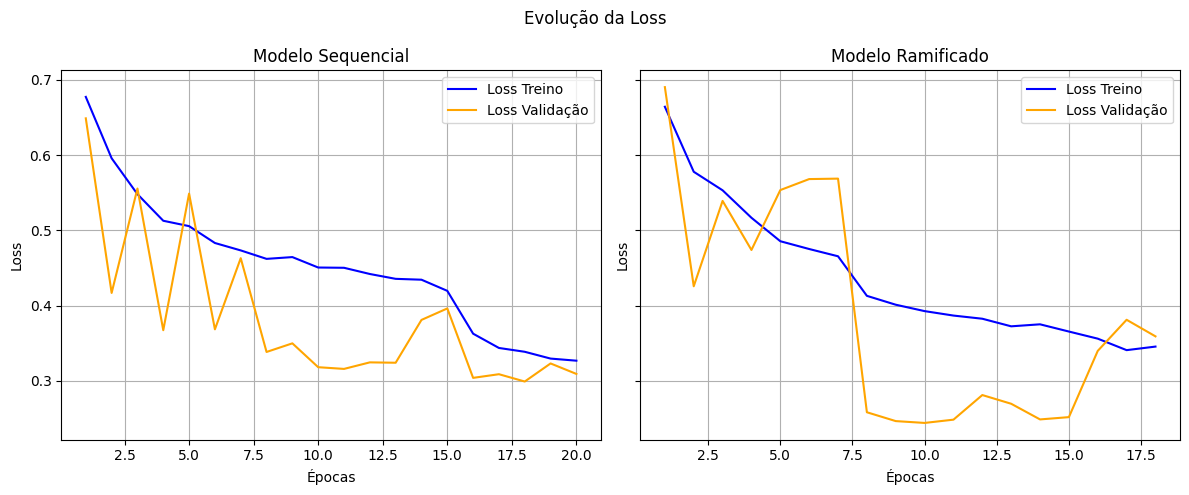

In [38]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

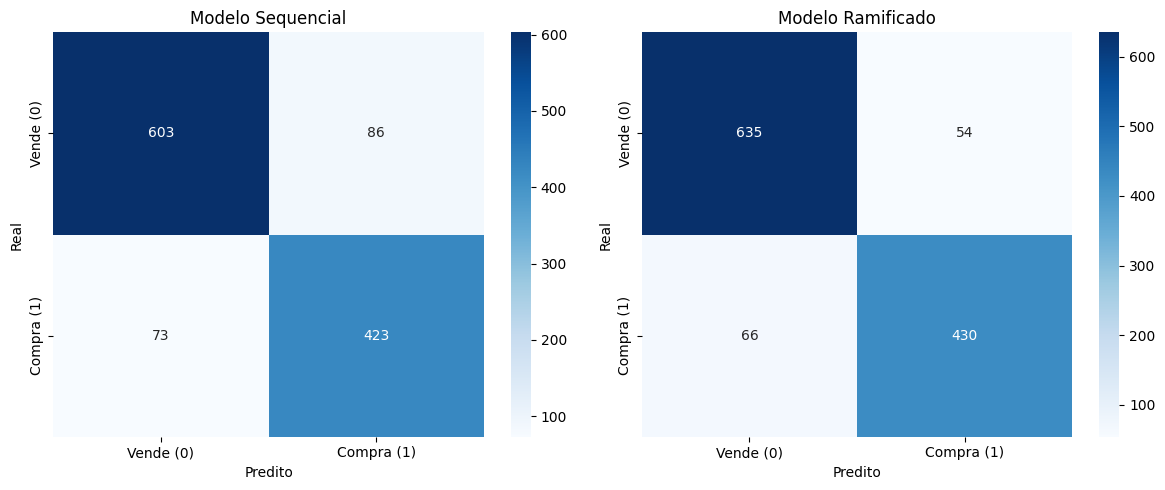

In [39]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [40]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.89
Recall:    0.88
F1-Score:  0.88

Compra (1):
Precision: 0.83
Recall:    0.85
F1-Score:  0.84

Médias:
Acurácia:  0.87
Precision: 0.86
Recall:    0.86
F1-Score:  0.86


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.91
Recall:    0.92
F1-Score:  0.91

Compra (1):
Precision: 0.89
Recall:    0.87
F1-Score:  0.88

Médias:
Acurácia:  0.90
Precision: 0.90
Recall:    0.89
F1-Score:  0.90




In [41]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="BBAS3",
    metrics = best_seq_metrics,
    cdi_df = cdi,
    metric_optimization = metric_optimization

)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="BBAS3",
    metrics = best_ram_metrics,
    cdi_df = cdi,
    metric_optimization = metric_optimization
)

resultado_backtest

<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


,Data,Modelo,Ação,Métrica de Otimização,Acurácia,Precision,Recall,F1,Matriz de Confusão,Saldo Inicial,Saldo Final,Total de Ações,Lucro Total,Lucro (%),Lucro (%) CDI
0,2025-04-13 14:10:15.041119,CNN Sequencial,CSAN3,val_loss,0.885329,0.882166,0.882586,0.882373,"[[619, 69], [67, 431]]",10000,3.640817,990.0,9467.040666,94.670407,42.26921
1,2025-04-13 14:10:15.069407,CNN Ramificado,CSAN3,val_loss,0.881956,0.880287,0.876629,0.878284,"[[626, 62], [78, 420]]",10000,8.435907,1065.0,10946.335745,109.463357,42.26921
2,2025-04-13 14:37:38.702181,CNN Sequencial,BBAS3,val_loss,0.865823,0.861527,0.864002,0.862654,"[[603, 86], [73, 423]]",10000,39.235968,247.0,3720.565817,37.205658,42.26921
3,2025-04-13 14:37:38.727148,CNN Ramificado,BBAS3,val_loss,0.898734,0.897139,0.894281,0.895610,"[[635, 54], [66, 430]]",10000,38.974524,310.0,7209.874334,72.098743,42.26921


### CSNA3

In [24]:
X_train, X_test, y_train, y_test, features = preprocess_data(cs_train, cs_test)

In [25]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(cs_train, cs_test, split_features=[janela_curta,janela_longa])

In [26]:
titles = ["Modelo Sequencial", "Modelo Ramificado"]
prices = cs_test.set_index("Date")["Close"]
metric_optimization = 'val_loss'

In [27]:
best_seq_model, best_seq_history, df_results, best_seq_metrics, best_seq_y_pred = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_CSNA3.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 13:48:09,380] A new study created in memory with name: no-name-5d4fe75f-420d-4b96-b138-48bfa81f1693


Epoch 1/42
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5438 - loss: 0.6891
Epoch 1: val_loss improved from inf to 0.64025, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5448 - loss: 0.6887 - val_accuracy: 0.5978 - val_loss: 0.6402 - learning_rate: 0.0035
Epoch 2/42
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6121 - loss: 0.6495
Epoch 2: val_loss improved from 0.64025 to 0.47252, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6131 - loss: 0.6485 - val_accuracy: 0.8120 - val_loss: 0.4725 - learning_rate: 0.0035
Epoch 3/42
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6982 - loss: 0.5730
Epoch 3: val_loss did not improve from 0.47252
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6984 - loss: 0.5724 - val_accuracy: 0.7226 - val_loss: 0.5127 - learning_rate: 0.0035
Epoch 4/42
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7261 - loss: 0.5283
Epoch 4: val

[I 2025-04-13 13:48:39,279] Trial 0 finished with value: -0.31811511516571045 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.00353575229194107, 'stop_patience': 9, 'reduce_lr_factor': 0.4348747081349842, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.31811511516571045.


Epoch 1/42
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5602 - loss: 0.6862
Epoch 1: val_loss improved from inf to 0.62294, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5603 - loss: 0.6859 - val_accuracy: 0.7917 - val_loss: 0.6229 - learning_rate: 0.0036
Epoch 2/42
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5899 - loss: 0.6473
Epoch 2: val_loss improved from 0.62294 to 0.42745, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5919 - loss: 0.6463 - val_accuracy: 0.8019 - val_loss: 0.4274 - learning_rate: 0.0036
Epoch 3/42
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6764 - loss: 0.5614
Epoch 3: val_loss improved from 0.42745 to 0.38755, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6765 - loss: 0.5613 - val_accuracy: 0.8221 - val_loss: 0.3876 - learning_rate: 0.0036
Epoch 4/42
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 13:49:18,788] Trial 1 finished with value: -0.2961065471172333 and parameters: {'epochs': 42, 'batch_size': 16, 'learning_rate': 0.0035684395449399535, 'stop_patience': 4, 'reduce_lr_factor': 0.4014357262255418, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/29
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5635 - loss: 0.6937
Epoch 1: val_loss improved from inf to 0.68339, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5635 - loss: 0.6937 - val_accuracy: 0.5801 - val_loss: 0.6834 - learning_rate: 0.0093
Epoch 2/29
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5697 - loss: 0.6843
Epoch 2: val_loss did not improve from 0.68339
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5693 - loss: 0.6843 - val_accuracy: 0.5801 - val_loss: 0.6839 - learning_rate: 0.0093
Epoch 3/29
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5718 - loss: 0.6846
Epoch 3: val_loss improved from 0.68339 to 0.68248, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5718 - loss: 0.6846 - val_accuracy: 0.5801 - val_loss: 0.6825 - learning_rate: 0.0093
Epoch 4/29
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5718 - loss: 0.6841
Epo

[I 2025-04-13 13:49:57,224] Trial 2 finished with value: -0.41791102290153503 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.009300502346771544, 'stop_patience': 5, 'reduce_lr_factor': 0.31065861737178957, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/34
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5703 - loss: 0.6933
Epoch 1: val_loss improved from inf to 0.74562, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5700 - loss: 0.6932 - val_accuracy: 0.4325 - val_loss: 0.7456 - learning_rate: 0.0092
Epoch 2/34
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5639 - loss: 0.6771
Epoch 2: val_loss improved from 0.74562 to 0.67763, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5621 - loss: 0.6765 - val_accuracy: 0.5995 - val_loss: 0.6776 - learning_rate: 0.0092
Epoch 3/34
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6000 - loss: 0.6452
Epoch 3: val_loss improved from 0.67763 to 0.46827, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6006 - loss: 0.6445 - val_accuracy: 0.8212 - val_loss: 0.4683 - learning_rate: 0.0092
Epoch 4/34
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-13 13:50:10,837] Trial 3 finished with value: -0.45323851704597473 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.009199047770357507, 'stop_patience': 6, 'reduce_lr_factor': 0.2255396530962299, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/22
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5533 - loss: 0.6887
Epoch 1: val_loss improved from inf to 0.75600, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5535 - loss: 0.6882 - val_accuracy: 0.5194 - val_loss: 0.7560 - learning_rate: 0.0049
Epoch 2/22
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.6685
Epoch 2: val_loss improved from 0.75600 to 0.50450, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5725 - loss: 0.6666 - val_accuracy: 0.7563 - val_loss: 0.5045 - learning_rate: 0.0049
Epoch 3/22
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6374 - loss: 0.6144
Epoch 3: val_loss did not improve from 0.50450
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6383 - loss: 0.6138 - val_accuracy: 0.5472 - val_loss: 0.6034 - learning_rate: 0.0049
Epoch 4/22
137/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7087 - loss: 0.5371
Epoc

[I 2025-04-13 13:50:24,105] Trial 4 finished with value: -0.3060208857059479 and parameters: {'epochs': 22, 'batch_size': 32, 'learning_rate': 0.004862365289611238, 'stop_patience': 3, 'reduce_lr_factor': 0.40543824793806216, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/21
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5653 - loss: 0.6908
Epoch 1: val_loss improved from inf to 0.68359, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5652 - loss: 0.6908 - val_accuracy: 0.5801 - val_loss: 0.6836 - learning_rate: 0.0071
Epoch 2/21
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5706 - loss: 0.6820
Epoch 2: val_loss did not improve from 0.68359
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5706 - loss: 0.6820 - val_accuracy: 0.4469 - val_loss: 0.7343 - learning_rate: 0.0071
Epoch 3/21
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 0.6449
Epoch 3: val_loss improved from 0.68359 to 0.48682, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5671 - loss: 0.6446 - val_accuracy: 0.8255 - val_loss: 0.4868 - learning_rate: 0.0071
Epoch 4/21
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 0.5808
Epoc

[I 2025-04-13 13:50:59,558] Trial 5 finished with value: -0.30948150157928467 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.007097132819228273, 'stop_patience': 6, 'reduce_lr_factor': 0.2743770325877627, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/14
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5562 - loss: 0.6922
Epoch 1: val_loss improved from inf to 0.69004, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5566 - loss: 0.6915 - val_accuracy: 0.5379 - val_loss: 0.6900 - learning_rate: 0.0054
Epoch 2/14
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6035 - loss: 0.6447
Epoch 2: val_loss improved from 0.69004 to 0.63366, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6066 - loss: 0.6422 - val_accuracy: 0.7218 - val_loss: 0.6337 - learning_rate: 0.0054
Epoch 3/14
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6728 - loss: 0.5773
Epoch 3: val_loss improved from 0.63366 to 0.44200, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6757 - loss: 0.5732 - val_accuracy: 0.7985 - val_loss: 0.4420 - learning_rate: 0.0054
Epoch 4/14
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-13 13:51:14,324] Trial 6 finished with value: -0.32968708872795105 and parameters: {'epochs': 14, 'batch_size': 64, 'learning_rate': 0.005382325576398161, 'stop_patience': 3, 'reduce_lr_factor': 0.46154740219618173, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/21
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5553 - loss: 0.6923
Epoch 1: val_loss improved from inf to 0.68166, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5553 - loss: 0.6923 - val_accuracy: 0.5801 - val_loss: 0.6817 - learning_rate: 0.0097
Epoch 2/21
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5721 - loss: 0.6846
Epoch 2: val_loss did not improve from 0.68166
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5718 - loss: 0.6846 - val_accuracy: 0.5801 - val_loss: 0.6865 - learning_rate: 0.0097
Epoch 3/21
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5723 - loss: 0.6711
Epoch 3: val_loss improved from 0.68166 to 0.68022, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5722 - loss: 0.6711 - val_accuracy: 0.5801 - val_loss: 0.6802 - learning_rate: 0.0097
Epoch 4/21
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5968 - loss: 0.6283
Epo

[I 2025-04-13 13:51:57,153] Trial 7 finished with value: -0.4711209535598755 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.009716396714229353, 'stop_patience': 8, 'reduce_lr_factor': 0.11076548773840456, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/22
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5646 - loss: 0.6910
Epoch 1: val_loss improved from inf to 0.68407, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5645 - loss: 0.6910 - val_accuracy: 0.5801 - val_loss: 0.6841 - learning_rate: 0.0081
Epoch 2/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 0.6851
Epoch 2: val_loss improved from 0.68407 to 0.68324, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5718 - loss: 0.6851 - val_accuracy: 0.5801 - val_loss: 0.6832 - learning_rate: 0.0081
Epoch 3/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 0.6845
Epoch 3: val_loss improved from 0.68324 to 0.68247, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5718 - loss: 0.6845 - val_accuracy: 0.5801 - val_loss: 0.6825 - learning_rate: 0.0081
Epoch 4/22
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 13:52:49,013] Trial 8 finished with value: -0.3895404636859894 and parameters: {'epochs': 22, 'batch_size': 16, 'learning_rate': 0.008072762753459396, 'stop_patience': 4, 'reduce_lr_factor': 0.3855299573393449, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/14
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5607 - loss: 0.6821
Epoch 1: val_loss improved from inf to 1.19222, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5614 - loss: 0.6816 - val_accuracy: 0.4806 - val_loss: 1.1922 - learning_rate: 0.0041
Epoch 2/14
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.6149
Epoch 2: val_loss improved from 1.19222 to 0.39303, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6303 - loss: 0.6147 - val_accuracy: 0.8331 - val_loss: 0.3930 - learning_rate: 0.0041
Epoch 3/14
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7010 - loss: 0.5464
Epoch 3: val_loss improved from 0.39303 to 0.35087, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7014 - loss: 0.5460 - val_accuracy: 0.8423 - val_loss: 0.3509 - learning_rate: 0.0041
Epoch 4/14
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 13:53:15,328] Trial 9 finished with value: -0.3040103614330292 and parameters: {'epochs': 14, 'batch_size': 16, 'learning_rate': 0.004118400412047983, 'stop_patience': 9, 'reduce_lr_factor': 0.3944867801202606, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/50
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5544 - loss: 0.6874
Epoch 1: val_loss improved from inf to 0.59896, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5552 - loss: 0.6870 - val_accuracy: 0.6838 - val_loss: 0.5990 - learning_rate: 5.7104e-04
Epoch 2/50
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6197 - loss: 0.6408
Epoch 2: val_loss improved from 0.59896 to 0.45085, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6198 - loss: 0.6407 - val_accuracy: 0.8229 - val_loss: 0.4509 - learning_rate: 5.7104e-04
Epoch 3/50
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6971 - loss: 0.5670
Epoch 3: val_loss did not improve from 0.45085
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6972 - loss: 0.5668 - val_accuracy: 0.7513 - val_loss: 0.4947 - learning_rate: 5.7104e-04
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7383 - loss:

[I 2025-04-13 13:53:41,933] Trial 10 finished with value: -0.3003368675708771 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0005710373038373649, 'stop_patience': 7, 'reduce_lr_factor': 0.49380620385474017, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/48
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5465 - loss: 0.6887
Epoch 1: val_loss improved from inf to 0.67068, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5469 - loss: 0.6886 - val_accuracy: 0.6788 - val_loss: 0.6707 - learning_rate: 2.8850e-04
Epoch 2/48
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5865 - loss: 0.6619
Epoch 2: val_loss improved from 0.67068 to 0.53582, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5868 - loss: 0.6617 - val_accuracy: 0.7698 - val_loss: 0.5358 - learning_rate: 2.8850e-04
Epoch 3/48
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6695 - loss: 0.6037
Epoch 3: val_loss improved from 0.53582 to 0.41512, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6703 - loss: 0.6030 - val_accuracy: 0.8238 - val_loss: 0.4151 - learning_rate: 2.8850e-04
Epoch 4/48
148/149 ━━━━━━━━━━━━━

[I 2025-04-13 13:54:10,685] Trial 11 finished with value: -0.3210367262363434 and parameters: {'epochs': 48, 'batch_size': 32, 'learning_rate': 0.000288495002800162, 'stop_patience': 7, 'reduce_lr_factor': 0.49111695926165655, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/50
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5626 - loss: 0.6854
Epoch 1: val_loss improved from inf to 0.59642, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5625 - loss: 0.6853 - val_accuracy: 0.6880 - val_loss: 0.5964 - learning_rate: 6.5023e-04
Epoch 2/50
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6097 - loss: 0.6457
Epoch 2: val_loss improved from 0.59642 to 0.48768, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6100 - loss: 0.6455 - val_accuracy: 0.7690 - val_loss: 0.4877 - learning_rate: 6.5023e-04
Epoch 3/50
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6855 - loss: 0.5711
Epoch 3: val_loss improved from 0.48768 to 0.38784, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6859 - loss: 0.5706 - val_accuracy: 0.8280 - val_loss: 0.3878 - learning_rate: 6.5023e-04
Epoch 4/50
146/149 ━━━━━━━━━━━━

[I 2025-04-13 13:54:33,053] Trial 12 finished with value: -0.3078356385231018 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0006502345763045482, 'stop_patience': 7, 'reduce_lr_factor': 0.4969070037168626, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/41
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5695 - loss: 0.6850
Epoch 1: val_loss improved from inf to 0.54239, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5695 - loss: 0.6847 - val_accuracy: 0.8162 - val_loss: 0.5424 - learning_rate: 0.0019
Epoch 2/41
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6617 - loss: 0.6068
Epoch 2: val_loss improved from 0.54239 to 0.43906, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6628 - loss: 0.6053 - val_accuracy: 0.7926 - val_loss: 0.4391 - learning_rate: 0.0019
Epoch 3/41
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6845 - loss: 0.5518
Epoch 3: val_loss did not improve from 0.43906
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6856 - loss: 0.5505 - val_accuracy: 0.7530 - val_loss: 0.5333 - learning_rate: 0.0019
Epoch 4/41
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7538 - loss: 0.4746
Epoc

[I 2025-04-13 13:54:48,683] Trial 13 finished with value: -0.304857462644577 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.0018681750058041908, 'stop_patience': 5, 'reduce_lr_factor': 0.3340929827826515, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/42
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5475 - loss: 0.6853
Epoch 1: val_loss improved from inf to 0.51961, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5479 - loss: 0.6850 - val_accuracy: 0.7310 - val_loss: 0.5196 - learning_rate: 0.0022
Epoch 2/42
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6494 - loss: 0.6124
Epoch 2: val_loss improved from 0.51961 to 0.40703, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6507 - loss: 0.6109 - val_accuracy: 0.8027 - val_loss: 0.4070 - learning_rate: 0.0022
Epoch 3/42
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7077 - loss: 0.5607
Epoch 3: val_loss improved from 0.40703 to 0.35310, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7082 - loss: 0.5600 - val_accuracy: 0.8432 - val_loss: 0.3531 - learning_rate: 0.0022
Epoch 4/42
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2025-04-13 13:55:11,870] Trial 14 finished with value: -0.32076773047447205 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.002223146607842878, 'stop_patience': 10, 'reduce_lr_factor': 0.3447363529746765, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/36
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5456 - loss: 0.6863
Epoch 1: val_loss improved from inf to 0.56663, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5460 - loss: 0.6862 - val_accuracy: 0.7901 - val_loss: 0.5666 - learning_rate: 0.0020
Epoch 2/36
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6104 - loss: 0.6358
Epoch 2: val_loss improved from 0.56663 to 0.38949, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6116 - loss: 0.6349 - val_accuracy: 0.8465 - val_loss: 0.3895 - learning_rate: 0.0020
Epoch 3/36
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7094 - loss: 0.5397
Epoch 3: val_loss improved from 0.38949 to 0.33218, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7100 - loss: 0.5391 - val_accuracy: 0.8558 - val_loss: 0.3322 - learning_rate: 0.0020
Epoch 4/36
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 13:55:42,685] Trial 15 finished with value: -0.30190813541412354 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.001992519257104267, 'stop_patience': 4, 'reduce_lr_factor': 0.4348297912674576, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/46
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5608 - loss: 0.6877
Epoch 1: val_loss improved from inf to 0.61967, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5608 - loss: 0.6874 - val_accuracy: 0.5801 - val_loss: 0.6197 - learning_rate: 0.0061
Epoch 2/46
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6041 - loss: 0.6442
Epoch 2: val_loss improved from 0.61967 to 0.48318, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6045 - loss: 0.6439 - val_accuracy: 0.8196 - val_loss: 0.4832 - learning_rate: 0.0061
Epoch 3/46
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6816 - loss: 0.5838
Epoch 3: val_loss did not improve from 0.48318
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6815 - loss: 0.5836 - val_accuracy: 0.5776 - val_loss: 0.8587 - learning_rate: 0.0061
Epoch 4/46
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7214 - loss: 0.5298
Epoc

[I 2025-04-13 13:56:05,228] Trial 16 finished with value: -0.31888577342033386 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.006063488354246374, 'stop_patience': 8, 'reduce_lr_factor': 0.25383866294809765, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2961065471172333.


Epoch 1/37
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5535 - loss: 0.6889
Epoch 1: val_loss improved from inf to 0.64387, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5535 - loss: 0.6888 - val_accuracy: 0.5818 - val_loss: 0.6439 - learning_rate: 0.0031
Epoch 2/37
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 0.6415
Epoch 2: val_loss improved from 0.64387 to 0.43093, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5946 - loss: 0.6411 - val_accuracy: 0.8052 - val_loss: 0.4309 - learning_rate: 0.0031
Epoch 3/37
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6763 - loss: 0.5685
Epoch 3: val_loss improved from 0.43093 to 0.34811, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6771 - loss: 0.5679 - val_accuracy: 0.8457 - val_loss: 0.3481 - learning_rate: 0.0031
Epoch 4/37
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 13:57:11,396] Trial 17 finished with value: -0.2800886034965515 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.003141698145764422, 'stop_patience': 5, 'reduce_lr_factor': 0.16816095122299263, 'reduce_lr_patience': 5}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/30
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5637 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.58366, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5637 - loss: 0.6881 - val_accuracy: 0.6239 - val_loss: 0.5837 - learning_rate: 0.0031
Epoch 2/30
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5903 - loss: 0.6698
Epoch 2: val_loss improved from 0.58366 to 0.47465, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5910 - loss: 0.6691 - val_accuracy: 0.7681 - val_loss: 0.4746 - learning_rate: 0.0031
Epoch 3/30
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6903 - loss: 0.5655
Epoch 3: val_loss improved from 0.47465 to 0.43939, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6903 - loss: 0.5655 - val_accuracy: 0.8196 - val_loss: 0.4394 - learning_rate: 0.0031
Epoch 4/30
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 13:57:33,023] Trial 18 finished with value: -0.37156176567077637 and parameters: {'epochs': 30, 'batch_size': 16, 'learning_rate': 0.0031455490449621166, 'stop_patience': 5, 'reduce_lr_factor': 0.1590195321906063, 'reduce_lr_patience': 5}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/36
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5613 - loss: 0.6849
Epoch 1: val_loss improved from inf to 0.71565, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5613 - loss: 0.6846 - val_accuracy: 0.5978 - val_loss: 0.7156 - learning_rate: 0.0029
Epoch 2/36
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6028 - loss: 0.6398
Epoch 2: val_loss improved from 0.71565 to 0.45911, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6031 - loss: 0.6396 - val_accuracy: 0.8035 - val_loss: 0.4591 - learning_rate: 0.0029
Epoch 3/36
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6971 - loss: 0.5610
Epoch 3: val_loss improved from 0.45911 to 0.38685, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6972 - loss: 0.5607 - val_accuracy: 0.8364 - val_loss: 0.3868 - learning_rate: 0.0029
Epoch 4/36
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 13:58:04,766] Trial 19 finished with value: -0.3202648162841797 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.0029233878598301528, 'stop_patience': 4, 'reduce_lr_factor': 0.18785917787589418, 'reduce_lr_patience': 4}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/39
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5662 - loss: 0.6891
Epoch 1: val_loss improved from inf to 0.68435, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5658 - loss: 0.6891 - val_accuracy: 0.5691 - val_loss: 0.6843 - learning_rate: 0.0044
Epoch 2/39
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5745 - loss: 0.6674
Epoch 2: val_loss did not improve from 0.68435
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5747 - loss: 0.6670 - val_accuracy: 0.4865 - val_loss: 0.6947 - learning_rate: 0.0044
Epoch 3/39
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6389 - loss: 0.6024
Epoch 3: val_loss improved from 0.68435 to 0.40418, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6398 - loss: 0.6018 - val_accuracy: 0.8153 - val_loss: 0.4042 - learning_rate: 0.0044
Epoch 4/39
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6971 - loss: 0.5451
Epoc

[I 2025-04-13 13:58:34,015] Trial 20 finished with value: -0.300666868686676 and parameters: {'epochs': 39, 'batch_size': 16, 'learning_rate': 0.004401868276883011, 'stop_patience': 3, 'reduce_lr_factor': 0.1144473797040462, 'reduce_lr_patience': 5}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/46
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5568 - loss: 0.6867
Epoch 1: val_loss improved from inf to 0.54288, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5570 - loss: 0.6865 - val_accuracy: 0.7673 - val_loss: 0.5429 - learning_rate: 0.0012
Epoch 2/46
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6288 - loss: 0.6293
Epoch 2: val_loss improved from 0.54288 to 0.45540, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6298 - loss: 0.6283 - val_accuracy: 0.7757 - val_loss: 0.4554 - learning_rate: 0.0012
Epoch 3/46
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7261 - loss: 0.5240
Epoch 3: val_loss did not improve from 0.45540
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7261 - loss: 0.5239 - val_accuracy: 0.7791 - val_loss: 0.4753 - learning_rate: 0.0012
Epoch 4/46
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7615 - loss: 0.4641
Epoc

[I 2025-04-13 13:59:09,164] Trial 21 finished with value: -0.30307063460350037 and parameters: {'epochs': 46, 'batch_size': 16, 'learning_rate': 0.0012438242403280584, 'stop_patience': 6, 'reduce_lr_factor': 0.3646667253856996, 'reduce_lr_patience': 5}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/45
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5470 - loss: 0.6900
Epoch 1: val_loss improved from inf to 0.66356, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5472 - loss: 0.6899 - val_accuracy: 0.5700 - val_loss: 0.6636 - learning_rate: 0.0061
Epoch 2/45
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5584 - loss: 0.6679
Epoch 2: val_loss did not improve from 0.66356
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5599 - loss: 0.6671 - val_accuracy: 0.6602 - val_loss: 0.6839 - learning_rate: 0.0061
Epoch 3/45
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6191 - loss: 0.6272
Epoch 3: val_loss improved from 0.66356 to 0.41059, saving model to BEST_CNN_SEQ_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6202 - loss: 0.6261 - val_accuracy: 0.8263 - val_loss: 0.4106 - learning_rate: 0.0061
Epoch 4/45
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7186 - loss: 0.5357
Epoc

[I 2025-04-13 13:59:27,969] Trial 22 finished with value: -0.3329354524612427 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.006096841576034697, 'stop_patience': 5, 'reduce_lr_factor': 0.4473803430728341, 'reduce_lr_patience': 5}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/38
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5636 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.66980, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5632 - loss: 0.6902 - val_accuracy: 0.5801 - val_loss: 0.6698 - learning_rate: 7.4342e-05
Epoch 2/38
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5714 - loss: 0.6863
Epoch 2: val_loss improved from 0.66980 to 0.66030, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5711 - loss: 0.6863 - val_accuracy: 0.5801 - val_loss: 0.6603 - learning_rate: 7.4342e-05
Epoch 3/38
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5750 - loss: 0.6819
Epoch 3: val_loss improved from 0.66030 to 0.65475, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5747 - loss: 0.6819 - val_accuracy: 0.5919 - val_loss: 0.6547 - learning_rate: 7.4342e-05
Epoch 4/38
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7

[I 2025-04-13 13:59:55,312] Trial 23 finished with value: -0.4090004563331604 and parameters: {'epochs': 38, 'batch_size': 64, 'learning_rate': 7.434153284365842e-05, 'stop_patience': 7, 'reduce_lr_factor': 0.18188484073899663, 'reduce_lr_patience': 4}. Best is trial 17 with value: -0.2800886034965515.


Epoch 1/50
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5674 - loss: 0.6836
Epoch 1: val_loss improved from inf to 0.67174, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5674 - loss: 0.6834 - val_accuracy: 0.5675 - val_loss: 0.6717 - learning_rate: 0.0027
Epoch 2/50
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6204 - loss: 0.6253
Epoch 2: val_loss improved from 0.67174 to 0.40421, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6215 - loss: 0.6245 - val_accuracy: 0.8288 - val_loss: 0.4042 - learning_rate: 0.0027
Epoch 3/50
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6962 - loss: 0.5417
Epoch 3: val_loss did not improve from 0.40421
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6973 - loss: 0.5405 - val_accuracy: 0.7976 - val_loss: 0.4336 - learning_rate: 0.0027
Epoch 4/50
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7411 - loss: 0.4923
Epoc

[I 2025-04-13 14:00:28,706] Trial 24 finished with value: -0.2683771252632141 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.002678169468879813, 'stop_patience': 4, 'reduce_lr_factor': 0.29431686816170216, 'reduce_lr_patience': 5}. Best is trial 24 with value: -0.2683771252632141.


Epoch 1/32
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5626 - loss: 0.6897
Epoch 1: val_loss improved from inf to 0.67788, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5624 - loss: 0.6896 - val_accuracy: 0.6998 - val_loss: 0.6779 - learning_rate: 0.0026
Epoch 2/32
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5866 - loss: 0.6570
Epoch 2: val_loss improved from 0.67788 to 0.43030, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5866 - loss: 0.6569 - val_accuracy: 0.8145 - val_loss: 0.4303 - learning_rate: 0.0026
Epoch 3/32
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6710 - loss: 0.5930
Epoch 3: val_loss improved from 0.43030 to 0.37815, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6711 - loss: 0.5928 - val_accuracy: 0.8364 - val_loss: 0.3782 - learning_rate: 0.0026
Epoch 4/32
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:01:00,269] Trial 25 finished with value: -0.2925732433795929 and parameters: {'epochs': 32, 'batch_size': 16, 'learning_rate': 0.002646505434198699, 'stop_patience': 4, 'reduce_lr_factor': 0.2329787900652953, 'reduce_lr_patience': 5}. Best is trial 24 with value: -0.2683771252632141.


Epoch 1/28
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5622 - loss: 0.6847
Epoch 1: val_loss improved from inf to 0.57707, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5622 - loss: 0.6846 - val_accuracy: 0.6518 - val_loss: 0.5771 - learning_rate: 0.0025
Epoch 2/28
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6182 - loss: 0.6265
Epoch 2: val_loss improved from 0.57707 to 0.39192, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6185 - loss: 0.6263 - val_accuracy: 0.8263 - val_loss: 0.3919 - learning_rate: 0.0025
Epoch 3/28
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7156 - loss: 0.5307
Epoch 3: val_loss improved from 0.39192 to 0.34801, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7158 - loss: 0.5305 - val_accuracy: 0.8322 - val_loss: 0.3480 - learning_rate: 0.0025
Epoch 4/28
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:01:23,819] Trial 26 finished with value: -0.3226897716522217 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 0.002490109941441152, 'stop_patience': 4, 'reduce_lr_factor': 0.22537531800068647, 'reduce_lr_patience': 4}. Best is trial 24 with value: -0.2683771252632141.


Epoch 1/26
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5518 - loss: 0.6854
Epoch 1: val_loss improved from inf to 0.53445, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5522 - loss: 0.6851 - val_accuracy: 0.7943 - val_loss: 0.5345 - learning_rate: 0.0017
Epoch 2/26
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6066 - loss: 0.6351
Epoch 2: val_loss improved from 0.53445 to 0.42435, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6072 - loss: 0.6347 - val_accuracy: 0.8229 - val_loss: 0.4244 - learning_rate: 0.0017
Epoch 3/26
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7038 - loss: 0.5571
Epoch 3: val_loss improved from 0.42435 to 0.37783, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7045 - loss: 0.5562 - val_accuracy: 0.8153 - val_loss: 0.3778 - learning_rate: 0.0017
Epoch 4/26
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:01:50,471] Trial 27 finished with value: -0.3235626518726349 and parameters: {'epochs': 26, 'batch_size': 16, 'learning_rate': 0.0016505159632287454, 'stop_patience': 5, 'reduce_lr_factor': 0.2794232177814445, 'reduce_lr_patience': 5}. Best is trial 24 with value: -0.2683771252632141.


Epoch 1/33
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5666 - loss: 0.6884
Epoch 1: val_loss improved from inf to 0.81299, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5663 - loss: 0.6883 - val_accuracy: 0.4545 - val_loss: 0.8130 - learning_rate: 0.0040
Epoch 2/33
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6073 - loss: 0.6419
Epoch 2: val_loss improved from 0.81299 to 0.43230, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6075 - loss: 0.6417 - val_accuracy: 0.8111 - val_loss: 0.4323 - learning_rate: 0.0040
Epoch 3/33
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6809 - loss: 0.5745
Epoch 3: val_loss improved from 0.43230 to 0.37424, saving model to BEST_CNN_SEQ_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6812 - loss: 0.5742 - val_accuracy: 0.8423 - val_loss: 0.3742 - learning_rate: 0.0040
Epoch 4/33
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[I 2025-04-13 14:02:14,878] Trial 28 finished with value: -0.3061427175998688 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.00396155724603266, 'stop_patience': 3, 'reduce_lr_factor': 0.21960292025932926, 'reduce_lr_patience': 4}. Best is trial 24 with value: -0.2683771252632141.


Epoch 1/33
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5669 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.68596, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5666 - loss: 0.6853 - val_accuracy: 0.5101 - val_loss: 0.6860 - learning_rate: 0.0029
Epoch 2/33
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5957 - loss: 0.6541
Epoch 2: val_loss improved from 0.68596 to 0.60286, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5968 - loss: 0.6529 - val_accuracy: 0.6737 - val_loss: 0.6029 - learning_rate: 0.0029
Epoch 3/33
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6504 - loss: 0.5927
Epoch 3: val_loss improved from 0.60286 to 0.37634, saving model to BEST_CNN_SEQ_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6513 - loss: 0.5921 - val_accuracy: 0.8153 - val_loss: 0.3763 - learning_rate: 0.0029
Epoch 4/33
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-13 14:02:23,284] Trial 29 finished with value: -0.3564065098762512 and parameters: {'epochs': 33, 'batch_size': 64, 'learning_rate': 0.0028644274380458493, 'stop_patience': 4, 'reduce_lr_factor': 0.1473425493245902, 'reduce_lr_patience': 3}. Best is trial 24 with value: -0.2683771252632141.



✅ Melhor combinação encontrada:
trial                  24.000000
epochs                 50.000000
batch_size             16.000000
learning_rate           0.002678
stop_patience           4.000000
reduce_lr_factor        0.294317
reduce_lr_patience      5.000000
recall_Compra(1)        0.865462
recall_Vende(0)         0.899709
precision_Compra(1)     0.862000
precision_Vende(0)      0.902332
macro_recall            0.882586
accuracy                0.885329
f1_macro                0.882373
f1_weighted             0.885360
min_val_loss            0.268377
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.002678169468879813, 'stop_patience': 4, 'reduce_lr_factor': 0.29431686816170216, 'reduce_lr_patience': 5}


In [28]:
best_ram_model, best_ram_history, df_results, best_ram_metrics, best_ram_y_pred = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_CSNA3.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 14:02:23,311] A new study created in memory with name: no-name-ed894a4e-450b-4412-b14e-2ed7b219b6a2


Epoch 1/25
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5737 - loss: 0.6799
Epoch 1: val_loss improved from inf to 0.45187, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5741 - loss: 0.6796 - val_accuracy: 0.8550 - val_loss: 0.4519 - learning_rate: 0.0024
Epoch 2/25
280/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6908 - loss: 0.5659
Epoch 2: val_loss did not improve from 0.45187
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6922 - loss: 0.5642 - val_accuracy: 0.7901 - val_loss: 0.4628 - learning_rate: 0.0024
Epoch 3/25
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7466 - loss: 0.4989
Epoch 3: val_loss improved from 0.45187 to 0.37260, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7470 - loss: 0.4984 - val_accuracy: 0.8524 - val_loss: 0.3726 - learning_rate: 0.0024
Epoch 4/25
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7577 - loss: 0.4723
Epoc

[I 2025-04-13 14:02:39,370] Trial 0 finished with value: -0.3153038024902344 and parameters: {'epochs': 25, 'batch_size': 16, 'learning_rate': 0.0023611941287638772, 'stop_patience': 5, 'reduce_lr_factor': 0.4891484602323072, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.3153038024902344.


Epoch 1/39
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5734 - loss: 0.6754
Epoch 1: val_loss improved from inf to 0.43938, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5743 - loss: 0.6747 - val_accuracy: 0.8373 - val_loss: 0.4394 - learning_rate: 0.0023
Epoch 2/39
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7183 - loss: 0.5630
Epoch 2: val_loss improved from 0.43938 to 0.35925, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7185 - loss: 0.5625 - val_accuracy: 0.8457 - val_loss: 0.3593 - learning_rate: 0.0023
Epoch 3/39
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7271 - loss: 0.5142
Epoch 3: val_loss improved from 0.35925 to 0.35084, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7283 - loss: 0.5130 - val_accuracy: 0.8541 - val_loss: 0.3508 - learning_rate: 0.0023
Epoch 4/39
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-13 14:02:52,388] Trial 1 finished with value: -0.2737700939178467 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.002288932236178897, 'stop_patience': 8, 'reduce_lr_factor': 0.4735686365111972, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2737700939178467.


Epoch 1/11
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5913 - loss: 0.6718
Epoch 1: val_loss improved from inf to 0.38629, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5916 - loss: 0.6715 - val_accuracy: 0.8499 - val_loss: 0.3863 - learning_rate: 0.0032
Epoch 2/11
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7244 - loss: 0.5496
Epoch 2: val_loss improved from 0.38629 to 0.35110, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7250 - loss: 0.5489 - val_accuracy: 0.8398 - val_loss: 0.3511 - learning_rate: 0.0032
Epoch 3/11
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7647 - loss: 0.4789
Epoch 3: val_loss did not improve from 0.35110
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7646 - loss: 0.4788 - val_accuracy: 0.8524 - val_loss: 0.3590 - learning_rate: 0.0032
Epoch 4/11
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7741 - loss: 0.4637
Epoc

[I 2025-04-13 14:03:06,665] Trial 2 finished with value: -0.28004616498947144 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.003159932188898459, 'stop_patience': 7, 'reduce_lr_factor': 0.3102385041336635, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2737700939178467.


Epoch 1/34
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5763 - loss: 0.6769
Epoch 1: val_loss improved from inf to 0.40481, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5770 - loss: 0.6763 - val_accuracy: 0.8609 - val_loss: 0.4048 - learning_rate: 0.0052
Epoch 2/34
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7187 - loss: 0.5579
Epoch 2: val_loss improved from 0.40481 to 0.31590, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7191 - loss: 0.5566 - val_accuracy: 0.8685 - val_loss: 0.3159 - learning_rate: 0.0052
Epoch 3/34
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7633 - loss: 0.4754
Epoch 3: val_loss did not improve from 0.31590
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7634 - loss: 0.4752 - val_accuracy: 0.7639 - val_loss: 0.6011 - learning_rate: 0.0052
Epoch 4/34
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7653 - loss: 0.4702
Epo

[I 2025-04-13 14:03:25,999] Trial 3 finished with value: -0.2716202735900879 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.005180516786047501, 'stop_patience': 6, 'reduce_lr_factor': 0.389251649312201, 'reduce_lr_patience': 2}. Best is trial 3 with value: -0.2716202735900879.


Epoch 1/39
64/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5493 - loss: 0.6940
Epoch 1: val_loss improved from inf to 0.45530, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5522 - loss: 0.6906 - val_accuracy: 0.8474 - val_loss: 0.4553 - learning_rate: 0.0062
Epoch 2/39
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6751 - loss: 0.5840
Epoch 2: val_loss did not improve from 0.45530
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6764 - loss: 0.5827 - val_accuracy: 0.7943 - val_loss: 0.4619 - learning_rate: 0.0062
Epoch 3/39
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7287 - loss: 0.5150
Epoch 3: val_loss did not improve from 0.45530
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7291 - loss: 0.5145 - val_accuracy: 0.7605 - val_loss: 0.4942 - learning_rate: 0.0062
Epoch 4/39
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7706 - loss: 0.4503
Epoch 4: val_loss improved from 0.45530 to 0.30759, saving mode

[I 2025-04-13 14:03:38,635] Trial 4 finished with value: -0.29660919308662415 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.006245581510880467, 'stop_patience': 10, 'reduce_lr_factor': 0.40338214871855815, 'reduce_lr_patience': 4}. Best is trial 3 with value: -0.2716202735900879.


Epoch 1/50
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5838 - loss: 0.6875
Epoch 1: val_loss improved from inf to 0.35161, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5845 - loss: 0.6861 - val_accuracy: 0.8659 - val_loss: 0.3516 - learning_rate: 0.0073
Epoch 2/50
281/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6747 - loss: 0.5858
Epoch 2: val_loss did not improve from 0.35161
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6756 - loss: 0.5850 - val_accuracy: 0.8196 - val_loss: 0.3849 - learning_rate: 0.0073
Epoch 3/50
285/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7573 - loss: 0.4848
Epoch 3: val_loss improved from 0.35161 to 0.32441, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7568 - loss: 0.4850 - val_accuracy: 0.8710 - val_loss: 0.3244 - learning_rate: 0.0073
Epoch 4/50
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7629 - loss: 0.4596
Epoc

[I 2025-04-13 14:03:50,478] Trial 5 finished with value: -0.3244090676307678 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.007324083702131285, 'stop_patience': 4, 'reduce_lr_factor': 0.1274953739770974, 'reduce_lr_patience': 3}. Best is trial 3 with value: -0.2716202735900879.


Epoch 1/13
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5772 - loss: 0.6858
Epoch 1: val_loss improved from inf to 0.51578, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5779 - loss: 0.6851 - val_accuracy: 0.7546 - val_loss: 0.5158 - learning_rate: 0.0076
Epoch 2/13
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6787 - loss: 0.5878
Epoch 2: val_loss did not improve from 0.51578
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6803 - loss: 0.5860 - val_accuracy: 0.7648 - val_loss: 0.5507 - learning_rate: 0.0076
Epoch 3/13
131/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7345 - loss: 0.5142
Epoch 3: val_loss improved from 0.51578 to 0.31085, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7352 - loss: 0.5119 - val_accuracy: 0.8668 - val_loss: 0.3108 - learning_rate: 0.0076
Epoch 4/13
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7753 - loss: 0.4459
Epoc

[I 2025-04-13 14:04:00,522] Trial 6 finished with value: -0.310845285654068 and parameters: {'epochs': 13, 'batch_size': 32, 'learning_rate': 0.00764629343133679, 'stop_patience': 5, 'reduce_lr_factor': 0.33344209876694986, 'reduce_lr_patience': 4}. Best is trial 3 with value: -0.2716202735900879.


Epoch 1/34
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5900 - loss: 0.6764
Epoch 1: val_loss improved from inf to 0.44577, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5923 - loss: 0.6740 - val_accuracy: 0.7892 - val_loss: 0.4458 - learning_rate: 0.0055
Epoch 2/34
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7006 - loss: 0.5566
Epoch 2: val_loss improved from 0.44577 to 0.29612, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7010 - loss: 0.5563 - val_accuracy: 0.8836 - val_loss: 0.2961 - learning_rate: 0.0055
Epoch 3/34
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7473 - loss: 0.4859
Epoch 3: val_loss improved from 0.29612 to 0.29416, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7472 - loss: 0.4860 - val_accuracy: 0.8693 - val_loss: 0.2942 - learning_rate: 0.0055
Epoch 4/34
137/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:04:16,678] Trial 7 finished with value: -0.2906169295310974 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.005512411637230668, 'stop_patience': 8, 'reduce_lr_factor': 0.12107523678102812, 'reduce_lr_patience': 4}. Best is trial 3 with value: -0.2716202735900879.


Epoch 1/44
288/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6025 - loss: 0.6809
Epoch 1: val_loss improved from inf to 0.38188, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6031 - loss: 0.6798 - val_accuracy: 0.8609 - val_loss: 0.3819 - learning_rate: 0.0055
Epoch 2/44
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7043 - loss: 0.5658
Epoch 2: val_loss improved from 0.38188 to 0.37366, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7048 - loss: 0.5649 - val_accuracy: 0.8331 - val_loss: 0.3737 - learning_rate: 0.0055
Epoch 3/44
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7388 - loss: 0.4972
Epoch 3: val_loss improved from 0.37366 to 0.28464, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7389 - loss: 0.4970 - val_accuracy: 0.8744 - val_loss: 0.2846 - learning_rate: 0.0055
Epoch 4/44
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:04:35,084] Trial 8 finished with value: -0.2846392095088959 and parameters: {'epochs': 44, 'batch_size': 16, 'learning_rate': 0.005494717596813478, 'stop_patience': 9, 'reduce_lr_factor': 0.33014261913470944, 'reduce_lr_patience': 3}. Best is trial 3 with value: -0.2716202735900879.


Epoch 1/46
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5714 - loss: 0.6757
Epoch 1: val_loss improved from inf to 0.52463, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5722 - loss: 0.6752 - val_accuracy: 0.7487 - val_loss: 0.5246 - learning_rate: 0.0020
Epoch 2/46
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6945 - loss: 0.5700
Epoch 2: val_loss improved from 0.52463 to 0.38147, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6953 - loss: 0.5688 - val_accuracy: 0.8280 - val_loss: 0.3815 - learning_rate: 0.0020
Epoch 3/46
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7522 - loss: 0.4955
Epoch 3: val_loss improved from 0.38147 to 0.33289, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7518 - loss: 0.4954 - val_accuracy: 0.8567 - val_loss: 0.3329 - learning_rate: 0.0020
Epoch 4/46
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:04:52,195] Trial 9 finished with value: -0.25887417793273926 and parameters: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.002033526410365415, 'stop_patience': 5, 'reduce_lr_factor': 0.423712475391115, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/26
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4895 - loss: 0.6985
Epoch 1: val_loss improved from inf to 0.67340, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4912 - loss: 0.6983 - val_accuracy: 0.6973 - val_loss: 0.6734 - learning_rate: 2.2884e-05
Epoch 2/26
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5841 - loss: 0.6870
Epoch 2: val_loss improved from 0.67340 to 0.65226, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5839 - loss: 0.6870 - val_accuracy: 0.6012 - val_loss: 0.6523 - learning_rate: 2.2884e-05
Epoch 3/26
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6026 - loss: 0.6830
Epoch 3: val_loss improved from 0.65226 to 0.63769, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6023 - loss: 0.6829 - val_accuracy: 0.6197 - val_loss: 0.6377 - learning_rate: 2.2884e-05
Epoch 4/26
137/149 ━━━━━━━━━━━━━

[I 2025-04-13 14:05:22,126] Trial 10 finished with value: -0.4737597703933716 and parameters: {'epochs': 26, 'batch_size': 32, 'learning_rate': 2.288366057145129e-05, 'stop_patience': 3, 'reduce_lr_factor': 0.21984265008375076, 'reduce_lr_patience': 5}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/50
145/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5665 - loss: 0.6846
Epoch 1: val_loss improved from inf to 0.76293, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5679 - loss: 0.6832 - val_accuracy: 0.6349 - val_loss: 0.7629 - learning_rate: 0.0096
Epoch 2/50
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7087 - loss: 0.5669
Epoch 2: val_loss improved from 0.76293 to 0.44534, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7091 - loss: 0.5664 - val_accuracy: 0.8609 - val_loss: 0.4453 - learning_rate: 0.0096
Epoch 3/50
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7588 - loss: 0.4854
Epoch 3: val_loss did not improve from 0.44534
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7584 - loss: 0.4850 - val_accuracy: 0.8137 - val_loss: 0.6356 - learning_rate: 0.0096
Epoch 4/50
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7555 - loss: 0.4572
Epoc

[I 2025-04-13 14:05:33,961] Trial 11 finished with value: -0.29667428135871887 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.00960948845595496, 'stop_patience': 5, 'reduce_lr_factor': 0.4070726223427491, 'reduce_lr_patience': 2}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/32
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5927 - loss: 0.6760
Epoch 1: val_loss improved from inf to 0.38910, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5942 - loss: 0.6746 - val_accuracy: 0.8592 - val_loss: 0.3891 - learning_rate: 0.0035
Epoch 2/32
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6877 - loss: 0.5617
Epoch 2: val_loss did not improve from 0.38910
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6889 - loss: 0.5607 - val_accuracy: 0.8170 - val_loss: 0.4118 - learning_rate: 0.0035
Epoch 3/32
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7246 - loss: 0.5114
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0013984132036259378.

Epoch 3: val_loss did not improve from 0.38910
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7249 - loss: 0.5110 - val_accuracy: 0.7841 - val_loss: 0.5297 - learning_rate: 0.0035
Epoch 4/32
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

[I 2025-04-13 14:05:48,986] Trial 12 finished with value: -0.2817336320877075 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.003457229933869494, 'stop_patience': 6, 'reduce_lr_factor': 0.4044894853261797, 'reduce_lr_patience': 2}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/19
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5651 - loss: 0.6885
Epoch 1: val_loss improved from inf to 0.63449, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5655 - loss: 0.6884 - val_accuracy: 0.6981 - val_loss: 0.6345 - learning_rate: 8.9821e-05
Epoch 2/19
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6210 - loss: 0.6708
Epoch 2: val_loss improved from 0.63449 to 0.60151, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6206 - loss: 0.6707 - val_accuracy: 0.8238 - val_loss: 0.6015 - learning_rate: 8.9821e-05
Epoch 3/19
137/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6462 - loss: 0.6527
Epoch 3: val_loss improved from 0.60151 to 0.57413, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6455 - loss: 0.6526 - val_accuracy: 0.8280 - val_loss: 0.5741 - learning_rate: 8.9821e-05
Epoch 4/19
138/149 ━━━━━━━━━━━━━

[I 2025-04-13 14:06:13,136] Trial 13 finished with value: -0.39490076899528503 and parameters: {'epochs': 19, 'batch_size': 32, 'learning_rate': 8.982054548587522e-05, 'stop_patience': 6, 'reduce_lr_factor': 0.24052313846058773, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/42
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5667 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.44549, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5709 - loss: 0.6841 - val_accuracy: 0.8465 - val_loss: 0.4455 - learning_rate: 0.0039
Epoch 2/42
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7060 - loss: 0.5696
Epoch 2: val_loss improved from 0.44549 to 0.33863, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7072 - loss: 0.5674 - val_accuracy: 0.8550 - val_loss: 0.3386 - learning_rate: 0.0039
Epoch 3/42
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7601 - loss: 0.4809
Epoch 3: val_loss did not improve from 0.33863
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7599 - loss: 0.4810 - val_accuracy: 0.8052 - val_loss: 0.4130 - learning_rate: 0.0039
Epoch 4/42
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7685 - loss: 0.4540
Epoch 4: val_lo

[I 2025-04-13 14:06:22,928] Trial 14 finished with value: -0.28313350677490234 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.003886264874651091, 'stop_patience': 7, 'reduce_lr_factor': 0.4428676579780913, 'reduce_lr_patience': 2}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/35
144/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5907 - loss: 0.6743
Epoch 1: val_loss improved from inf to 0.44796, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5918 - loss: 0.6734 - val_accuracy: 0.8381 - val_loss: 0.4480 - learning_rate: 0.0011
Epoch 2/35
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7011 - loss: 0.5845
Epoch 2: val_loss improved from 0.44796 to 0.36256, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7026 - loss: 0.5823 - val_accuracy: 0.8449 - val_loss: 0.3626 - learning_rate: 0.0011
Epoch 3/35
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7386 - loss: 0.5136
Epoch 3: val_loss improved from 0.36256 to 0.35393, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7391 - loss: 0.5129 - val_accuracy: 0.8482 - val_loss: 0.3539 - learning_rate: 0.0011
Epoch 4/35
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:06:34,228] Trial 15 finished with value: -0.3183938264846802 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.0010743563890948044, 'stop_patience': 3, 'reduce_lr_factor': 0.37814972503725447, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/45
143/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5789 - loss: 0.6824
Epoch 1: val_loss improved from inf to 0.40933, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5805 - loss: 0.6810 - val_accuracy: 0.8390 - val_loss: 0.4093 - learning_rate: 0.0043
Epoch 2/45
134/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7200 - loss: 0.5509
Epoch 2: val_loss improved from 0.40933 to 0.39762, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7219 - loss: 0.5481 - val_accuracy: 0.8406 - val_loss: 0.3976 - learning_rate: 0.0043
Epoch 3/45
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7347 - loss: 0.5117
Epoch 3: val_loss did not improve from 0.39762
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7358 - loss: 0.5103 - val_accuracy: 0.8229 - val_loss: 0.4444 - learning_rate: 0.0043
Epoch 4/45
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7632 - loss: 0.4633
Epoc

[I 2025-04-13 14:06:49,303] Trial 16 finished with value: -0.3279690146446228 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.004334114584557123, 'stop_patience': 4, 'reduce_lr_factor': 0.36336491960006756, 'reduce_lr_patience': 5}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/28
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5740 - loss: 0.6758
Epoch 1: val_loss improved from inf to 0.44424, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5758 - loss: 0.6745 - val_accuracy: 0.8415 - val_loss: 0.4442 - learning_rate: 0.0017
Epoch 2/28
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6993 - loss: 0.5692
Epoch 2: val_loss improved from 0.44424 to 0.34990, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6994 - loss: 0.5691 - val_accuracy: 0.8592 - val_loss: 0.3499 - learning_rate: 0.0017
Epoch 3/28
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7554 - loss: 0.4906
Epoch 3: val_loss improved from 0.34990 to 0.31063, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7554 - loss: 0.4905 - val_accuracy: 0.8668 - val_loss: 0.3106 - learning_rate: 0.0017
Epoch 4/28
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:07:05,665] Trial 17 finished with value: -0.2870078682899475 and parameters: {'epochs': 28, 'batch_size': 32, 'learning_rate': 0.0016571582661099827, 'stop_patience': 6, 'reduce_lr_factor': 0.2475115032701272, 'reduce_lr_patience': 2}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/21
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5797 - loss: 0.6803
Epoch 1: val_loss improved from inf to 0.37657, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5821 - loss: 0.6781 - val_accuracy: 0.8541 - val_loss: 0.3766 - learning_rate: 0.0076
Epoch 2/21
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7194 - loss: 0.5404
Epoch 2: val_loss improved from 0.37657 to 0.32935, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7201 - loss: 0.5389 - val_accuracy: 0.8499 - val_loss: 0.3294 - learning_rate: 0.0076
Epoch 3/21
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7500 - loss: 0.4797
Epoch 3: val_loss did not improve from 0.32935
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7501 - loss: 0.4798 - val_accuracy: 0.8314 - val_loss: 0.4111 - learning_rate: 0.0076
Epoch 4/21
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.4717
Epoch 4: val_loss 

[I 2025-04-13 14:07:14,993] Trial 18 finished with value: -0.27822187542915344 and parameters: {'epochs': 21, 'batch_size': 64, 'learning_rate': 0.007552812383666452, 'stop_patience': 4, 'reduce_lr_factor': 0.4452690481512958, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/38
289/297 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5595 - loss: 0.6983
Epoch 1: val_loss improved from inf to 0.63304, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5597 - loss: 0.6977 - val_accuracy: 0.5801 - val_loss: 0.6330 - learning_rate: 0.0096
Epoch 2/38
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6271 - loss: 0.6146
Epoch 2: val_loss improved from 0.63304 to 0.34602, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6279 - loss: 0.6141 - val_accuracy: 0.8727 - val_loss: 0.3460 - learning_rate: 0.0096
Epoch 3/38
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7130 - loss: 0.5228
Epoch 3: val_loss improved from 0.34602 to 0.27825, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7136 - loss: 0.5222 - val_accuracy: 0.8803 - val_loss: 0.2782 - learning_rate: 0.0096
Epoch 4/38
283/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:07:34,315] Trial 19 finished with value: -0.2782479226589203 and parameters: {'epochs': 38, 'batch_size': 16, 'learning_rate': 0.009602037258876307, 'stop_patience': 8, 'reduce_lr_factor': 0.27900569320847074, 'reduce_lr_patience': 5}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/45
138/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5617 - loss: 0.6945
Epoch 1: val_loss improved from inf to 0.47413, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5630 - loss: 0.6925 - val_accuracy: 0.8465 - val_loss: 0.4741 - learning_rate: 0.0047
Epoch 2/45
136/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.5893
Epoch 2: val_loss improved from 0.47413 to 0.36740, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6881 - loss: 0.5881 - val_accuracy: 0.8499 - val_loss: 0.3674 - learning_rate: 0.0047
Epoch 3/45
133/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7311 - loss: 0.5089
Epoch 3: val_loss did not improve from 0.36740
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7330 - loss: 0.5070 - val_accuracy: 0.8204 - val_loss: 0.4004 - learning_rate: 0.0047
Epoch 4/45
137/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7596 - loss: 0.4691
Epoc

[I 2025-04-13 14:07:46,348] Trial 20 finished with value: -0.2822488248348236 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.004696227322695055, 'stop_patience': 7, 'reduce_lr_factor': 0.4532764359903439, 'reduce_lr_patience': 2}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/38
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 0.6672
Epoch 1: val_loss improved from inf to 0.44338, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5953 - loss: 0.6658 - val_accuracy: 0.8187 - val_loss: 0.4434 - learning_rate: 0.0025
Epoch 2/38
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7268 - loss: 0.5534
Epoch 2: val_loss did not improve from 0.44338
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7268 - loss: 0.5522 - val_accuracy: 0.8120 - val_loss: 0.4444 - learning_rate: 0.0025
Epoch 3/38
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.5031
Epoch 3: val_loss improved from 0.44338 to 0.32001, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7398 - loss: 0.5015 - val_accuracy: 0.8600 - val_loss: 0.3200 - learning_rate: 0.0025
Epoch 4/38
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7644 - loss: 0.4702
Epoch 4: val_loss 

[I 2025-04-13 14:08:02,567] Trial 21 finished with value: -0.27030840516090393 and parameters: {'epochs': 38, 'batch_size': 64, 'learning_rate': 0.002463021541868752, 'stop_patience': 8, 'reduce_lr_factor': 0.48905644941499343, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/31
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5798 - loss: 0.6804
Epoch 1: val_loss improved from inf to 0.43324, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5821 - loss: 0.6788 - val_accuracy: 0.8609 - val_loss: 0.4332 - learning_rate: 0.0030
Epoch 2/31
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7047 - loss: 0.5739
Epoch 2: val_loss improved from 0.43324 to 0.35024, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7053 - loss: 0.5729 - val_accuracy: 0.8516 - val_loss: 0.3502 - learning_rate: 0.0030
Epoch 3/31
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7310 - loss: 0.5177
Epoch 3: val_loss improved from 0.35024 to 0.34591, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7319 - loss: 0.5168 - val_accuracy: 0.8491 - val_loss: 0.3459 - learning_rate: 0.0030
Epoch 4/31
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

[I 2025-04-13 14:08:14,856] Trial 22 finished with value: -0.30325737595558167 and parameters: {'epochs': 31, 'batch_size': 64, 'learning_rate': 0.0029628408796121123, 'stop_patience': 9, 'reduce_lr_factor': 0.4995668551251531, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/36
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5774 - loss: 0.6796
Epoch 1: val_loss improved from inf to 0.49023, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5828 - loss: 0.6766 - val_accuracy: 0.8246 - val_loss: 0.4902 - learning_rate: 0.0013
Epoch 2/36
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6886 - loss: 0.5920
Epoch 2: val_loss improved from 0.49023 to 0.35931, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6899 - loss: 0.5903 - val_accuracy: 0.8533 - val_loss: 0.3593 - learning_rate: 0.0013
Epoch 3/36
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7647 - loss: 0.5164
Epoch 3: val_loss did not improve from 0.35931
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7634 - loss: 0.5161 - val_accuracy: 0.8288 - val_loss: 0.3708 - learning_rate: 0.0013
Epoch 4/36
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7686 - loss: 0.4750
Epoch 4: val_loss

[I 2025-04-13 14:08:29,499] Trial 23 finished with value: -0.2766205072402954 and parameters: {'epochs': 36, 'batch_size': 64, 'learning_rate': 0.0013390550402811799, 'stop_patience': 5, 'reduce_lr_factor': 0.42786770378330774, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/41
72/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6003 - loss: 0.6787
Epoch 1: val_loss improved from inf to 0.60264, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6011 - loss: 0.6778 - val_accuracy: 0.7175 - val_loss: 0.6026 - learning_rate: 8.5855e-04
Epoch 2/41
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - loss: 0.6031
Epoch 2: val_loss improved from 0.60264 to 0.38452, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6924 - loss: 0.6013 - val_accuracy: 0.8499 - val_loss: 0.3845 - learning_rate: 8.5855e-04
Epoch 3/41
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7441 - loss: 0.5334
Epoch 3: val_loss improved from 0.38452 to 0.33928, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7435 - loss: 0.5329 - val_accuracy: 0.8567 - val_loss: 0.3393 - learning_rate: 8.5855e-04
Epoch 4/41
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

[I 2025-04-13 14:08:48,778] Trial 24 finished with value: -0.27795475721359253 and parameters: {'epochs': 41, 'batch_size': 64, 'learning_rate': 0.0008585478000320522, 'stop_patience': 6, 'reduce_lr_factor': 0.3746546093404952, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/46
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5689 - loss: 0.6813
Epoch 1: val_loss improved from inf to 0.42086, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5744 - loss: 0.6775 - val_accuracy: 0.8583 - val_loss: 0.4209 - learning_rate: 0.0023
Epoch 2/46
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7162 - loss: 0.5624
Epoch 2: val_loss improved from 0.42086 to 0.41686, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7166 - loss: 0.5612 - val_accuracy: 0.8187 - val_loss: 0.4169 - learning_rate: 0.0023
Epoch 3/46
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7407 - loss: 0.5078
Epoch 3: val_loss improved from 0.41686 to 0.32281, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7418 - loss: 0.5065 - val_accuracy: 0.8600 - val_loss: 0.3228 - learning_rate: 0.0023
Epoch 4/46
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-13 14:09:05,709] Trial 25 finished with value: -0.2791193127632141 and parameters: {'epochs': 46, 'batch_size': 64, 'learning_rate': 0.002287021323430773, 'stop_patience': 9, 'reduce_lr_factor': 0.4676705029101216, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/47
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6046 - loss: 0.6764
Epoch 1: val_loss improved from inf to 0.71559, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6051 - loss: 0.6757 - val_accuracy: 0.6214 - val_loss: 0.7156 - learning_rate: 0.0064
Epoch 2/47
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6990 - loss: 0.5664
Epoch 2: val_loss improved from 0.71559 to 0.34617, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7006 - loss: 0.5644 - val_accuracy: 0.8491 - val_loss: 0.3462 - learning_rate: 0.0064
Epoch 3/47
140/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7476 - loss: 0.4989
Epoch 3: val_loss did not improve from 0.34617
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7478 - loss: 0.4981 - val_accuracy: 0.8415 - val_loss: 0.4303 - learning_rate: 0.0064
Epoch 4/47
139/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7594 - loss: 0.4637
Epoc

[I 2025-04-13 14:09:21,445] Trial 26 finished with value: -0.32797062397003174 and parameters: {'epochs': 47, 'batch_size': 32, 'learning_rate': 0.0063708486548626235, 'stop_patience': 7, 'reduce_lr_factor': 0.42515019954911293, 'reduce_lr_patience': 5}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/42
141/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5724 - loss: 0.6841
Epoch 1: val_loss improved from inf to 0.43249, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5738 - loss: 0.6827 - val_accuracy: 0.8541 - val_loss: 0.4325 - learning_rate: 0.0039
Epoch 2/42
133/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6790 - loss: 0.5785
Epoch 2: val_loss improved from 0.43249 to 0.32500, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6816 - loss: 0.5762 - val_accuracy: 0.8617 - val_loss: 0.3250 - learning_rate: 0.0039
Epoch 3/42
135/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7382 - loss: 0.4976
Epoch 3: val_loss improved from 0.32500 to 0.31776, saving model to BEST_CNN_RAM_CSNA3.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7384 - loss: 0.4977 - val_accuracy: 0.8676 - val_loss: 0.3178 - learning_rate: 0.0039
Epoch 4/42
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:09:44,544] Trial 27 finished with value: -0.27505508065223694 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.0038723919861385096, 'stop_patience': 10, 'reduce_lr_factor': 0.35356578638959424, 'reduce_lr_patience': 3}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/33
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5619 - loss: 0.6843
Epoch 1: val_loss improved from inf to 0.45455, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5625 - loss: 0.6839 - val_accuracy: 0.7884 - val_loss: 0.4545 - learning_rate: 0.0052
Epoch 2/33
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7072 - loss: 0.5593
Epoch 2: val_loss improved from 0.45455 to 0.30284, saving model to BEST_CNN_RAM_CSNA3.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7076 - loss: 0.5584 - val_accuracy: 0.8718 - val_loss: 0.3028 - learning_rate: 0.0052
Epoch 3/33
286/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7541 - loss: 0.4661
Epoch 3: val_loss did not improve from 0.30284
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7539 - loss: 0.4664 - val_accuracy: 0.8676 - val_loss: 0.3346 - learning_rate: 0.0052
Epoch 4/33
279/297 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7665 - loss: 0.4533
Epoc

[I 2025-04-13 14:10:03,055] Trial 28 finished with value: -0.30283647775650024 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 0.005221645443704961, 'stop_patience': 8, 'reduce_lr_factor': 0.1771517843797719, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.25887417793273926.


Epoch 1/29
67/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5692 - loss: 0.6809
Epoch 1: val_loss improved from inf to 0.48594, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5724 - loss: 0.6786 - val_accuracy: 0.8449 - val_loss: 0.4859 - learning_rate: 0.0018
Epoch 2/29
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6865 - loss: 0.5840
Epoch 2: val_loss improved from 0.48594 to 0.35843, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6872 - loss: 0.5830 - val_accuracy: 0.8533 - val_loss: 0.3584 - learning_rate: 0.0018
Epoch 3/29
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7463 - loss: 0.5161
Epoch 3: val_loss improved from 0.35843 to 0.33863, saving model to BEST_CNN_RAM_CSNA3.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7471 - loss: 0.5147 - val_accuracy: 0.8541 - val_loss: 0.3386 - learning_rate: 0.0018
Epoch 4/29
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

[I 2025-04-13 14:10:14,269] Trial 29 finished with value: -0.2836689054965973 and parameters: {'epochs': 29, 'batch_size': 64, 'learning_rate': 0.0017501136995559223, 'stop_patience': 5, 'reduce_lr_factor': 0.48843094780821084, 'reduce_lr_patience': 5}. Best is trial 9 with value: -0.25887417793273926.



✅ Melhor combinação encontrada:
trial                   9.000000
epochs                 46.000000
batch_size             32.000000
learning_rate           0.002034
stop_patience           5.000000
reduce_lr_factor        0.423712
reduce_lr_patience      4.000000
recall_Compra(1)        0.843373
recall_Vende(0)         0.909884
precision_Compra(1)     0.871369
precision_Vende(0)      0.889205
macro_recall            0.876629
accuracy                0.881956
f1_macro                0.878284
f1_weighted             0.881671
min_val_loss            0.258874
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 46, 'batch_size': 32, 'learning_rate': 0.002033526410365415, 'stop_patience': 5, 'reduce_lr_factor': 0.423712475391115, 'reduce_lr_patience': 4}


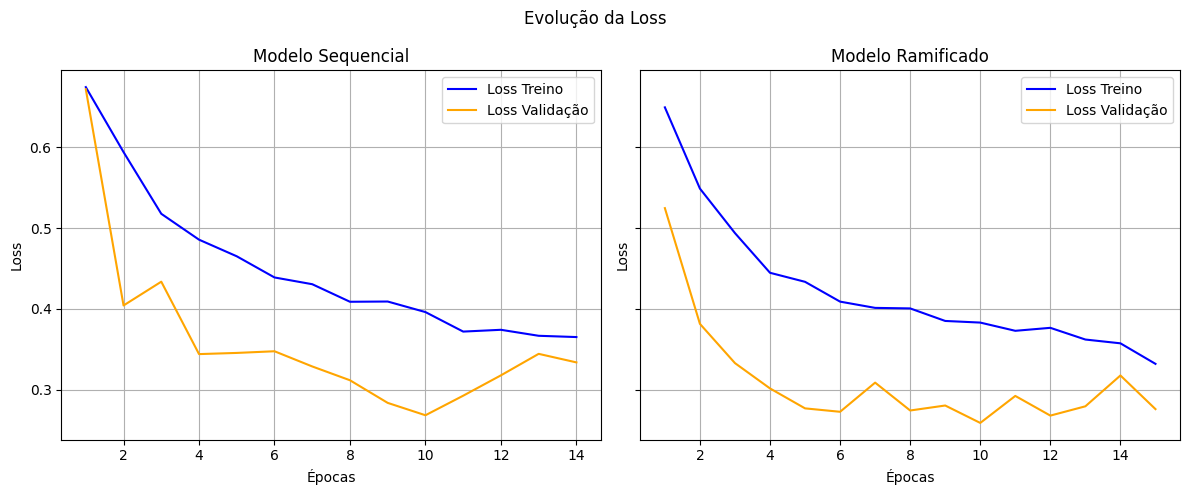

In [29]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

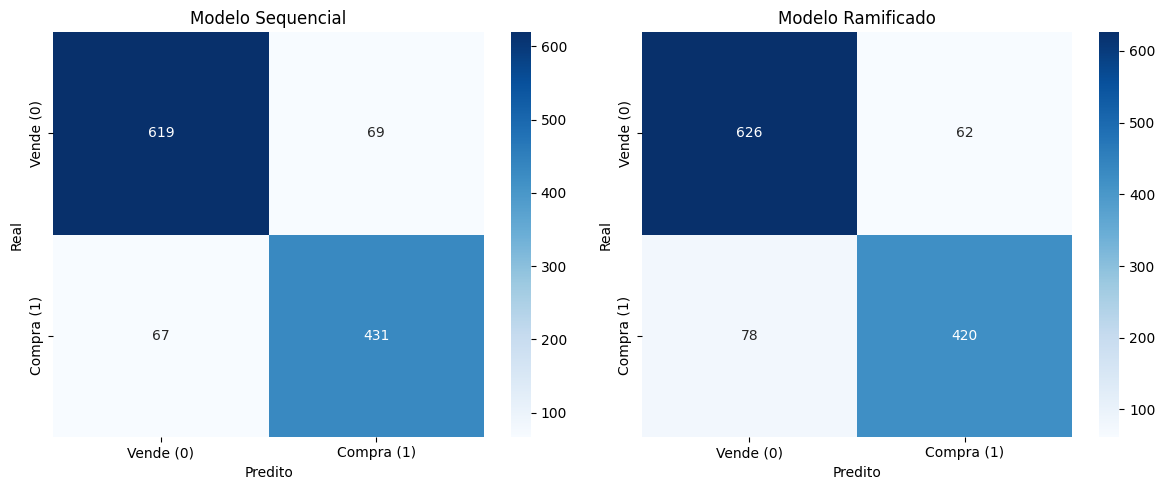

In [30]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [31]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.90
Recall:    0.90
F1-Score:  0.90

Compra (1):
Precision: 0.86
Recall:    0.87
F1-Score:  0.86

Médias:
Acurácia:  0.89
Precision: 0.88
Recall:    0.88
F1-Score:  0.88


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.89
Recall:    0.91
F1-Score:  0.90

Compra (1):
Precision: 0.87
Recall:    0.84
F1-Score:  0.86

Médias:
Acurácia:  0.88
Precision: 0.88
Recall:    0.88
F1-Score:  0.88




In [32]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="CSAN3",
    metrics = best_seq_metrics,
    cdi_df = cdi,
    metric_optimization=metric_optimization
)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="CSAN3",
    metrics = best_ram_metrics,
    cdi_df=cdi,
    metric_optimization=metric_optimization
)

resultado_backtest

<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


,Data,Modelo,Ação,Métrica de Otimização,Acurácia,Precision,Recall,F1,Matriz de Confusão,Saldo Inicial,Saldo Final,Total de Ações,Lucro Total,Lucro (%),Lucro (%) CDI
0,2025-04-13 14:10:15.041119,CNN Sequencial,CSAN3,val_loss,0.885329,0.882166,0.882586,0.882373,"[[619, 69], [67, 431]]",10000,3.640817,990.0,9467.040666,94.670407,42.26921
1,2025-04-13 14:10:15.069407,CNN Ramificado,CSAN3,val_loss,0.881956,0.880287,0.876629,0.878284,"[[626, 62], [78, 420]]",10000,8.435907,1065.0,10946.335745,109.463357,42.26921


### PETR4

In [42]:
X_train, X_test, y_train, y_test, features = preprocess_data(pe_train, pe_test)

In [43]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(pe_train, pe_test, split_features=[janela_curta,janela_longa])

In [44]:
prices = pe_test.set_index("Date")["Close"]
titles = ["Modelo Sequencial", "Modelo Ramificado"]
metric_optimization = 'val_loss'

In [45]:
best_seq_model, best_seq_history, df_results, best_seq_metrics, best_seq_y_pred = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_PETR4.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 14:37:38,806] A new study created in memory with name: no-name-aa683edf-4a3a-4bcd-8f8a-b21afa5f7e7c


Epoch 1/48
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5491 - loss: 0.6960
Epoch 1: val_loss improved from inf to 0.69770, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5491 - loss: 0.6959 - val_accuracy: 0.4830 - val_loss: 0.6977 - learning_rate: 0.0086
Epoch 2/48
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5583 - loss: 0.6869
Epoch 2: val_loss did not improve from 0.69770
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5581 - loss: 0.6869 - val_accuracy: 0.4830 - val_loss: 0.7017 - learning_rate: 0.0086
Epoch 3/48
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5600 - loss: 0.6864
Epoch 3: val_loss did not improve from 0.69770
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5600 - loss: 0.6864 - val_accuracy: 0.4830 - val_loss: 0.7015 - learning_rate: 0.0086
Epoch 4/48
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5603 - loss: 0.6863
Epoch 4: ReduceLROnPlateau reducing learning rate 

[I 2025-04-13 14:38:14,524] Trial 0 finished with value: -0.4934810698032379 and parameters: {'epochs': 48, 'batch_size': 16, 'learning_rate': 0.008597383679239045, 'stop_patience': 6, 'reduce_lr_factor': 0.3465474880396096, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.4934810698032379.


Epoch 1/27
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5471 - loss: 0.6958
Epoch 1: val_loss improved from inf to 0.74184, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5474 - loss: 0.6955 - val_accuracy: 0.5486 - val_loss: 0.7418 - learning_rate: 0.0040
Epoch 2/27
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5918 - loss: 0.6550
Epoch 2: val_loss did not improve from 0.74184
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5931 - loss: 0.6542 - val_accuracy: 0.6126 - val_loss: 0.8541 - learning_rate: 0.0040
Epoch 3/27
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6703 - loss: 0.5911
Epoch 3: val_loss improved from 0.74184 to 0.49201, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6704 - loss: 0.5911 - val_accuracy: 0.7448 - val_loss: 0.4920 - learning_rate: 0.0040
Epoch 4/27
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7086 - loss: 0.5415
Epoc

[I 2025-04-13 14:38:56,111] Trial 1 finished with value: -0.41971808671951294 and parameters: {'epochs': 27, 'batch_size': 16, 'learning_rate': 0.003954965345974381, 'stop_patience': 5, 'reduce_lr_factor': 0.40215213947363804, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.41971808671951294.


Epoch 1/45
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5696 - loss: 0.6812
Epoch 1: val_loss improved from inf to 0.96957, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5704 - loss: 0.6808 - val_accuracy: 0.5544 - val_loss: 0.9696 - learning_rate: 0.0011
Epoch 2/45
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6544 - loss: 0.6136
Epoch 2: val_loss improved from 0.96957 to 0.56595, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6551 - loss: 0.6129 - val_accuracy: 0.7265 - val_loss: 0.5659 - learning_rate: 0.0011
Epoch 3/45
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6989 - loss: 0.5494
Epoch 3: val_loss improved from 0.56595 to 0.49191, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6992 - loss: 0.5491 - val_accuracy: 0.7664 - val_loss: 0.4919 - learning_rate: 0.0011
Epoch 4/45
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:39:36,934] Trial 2 finished with value: -0.3720824718475342 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.001120992598403538, 'stop_patience': 4, 'reduce_lr_factor': 0.4753446437596067, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/17
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5562 - loss: 0.6926
Epoch 1: val_loss improved from inf to 0.76872, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5565 - loss: 0.6921 - val_accuracy: 0.5345 - val_loss: 0.7687 - learning_rate: 0.0056
Epoch 2/17
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6027 - loss: 0.6612
Epoch 2: val_loss did not improve from 0.76872
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6037 - loss: 0.6603 - val_accuracy: 0.5711 - val_loss: 1.4675 - learning_rate: 0.0056
Epoch 3/17
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6691 - loss: 0.5843
Epoch 3: val_loss improved from 0.76872 to 0.48087, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6704 - loss: 0.5827 - val_accuracy: 0.7997 - val_loss: 0.4809 - learning_rate: 0.0056
Epoch 4/17
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7074 - loss: 0.5394
Epoc

[I 2025-04-13 14:40:01,317] Trial 3 finished with value: -0.4163287281990051 and parameters: {'epochs': 17, 'batch_size': 32, 'learning_rate': 0.005577338159082833, 'stop_patience': 4, 'reduce_lr_factor': 0.22164720973584298, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/37
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5545 - loss: 0.6889
Epoch 1: val_loss improved from inf to 1.55128, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5578 - loss: 0.6870 - val_accuracy: 0.5503 - val_loss: 1.5513 - learning_rate: 0.0052
Epoch 2/37
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6465 - loss: 0.6274
Epoch 2: val_loss improved from 1.55128 to 0.46589, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6476 - loss: 0.6251 - val_accuracy: 0.7922 - val_loss: 0.4659 - learning_rate: 0.0052
Epoch 3/37
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6965 - loss: 0.5578
Epoch 3: val_loss improved from 0.46589 to 0.45225, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6960 - loss: 0.5584 - val_accuracy: 0.8030 - val_loss: 0.4522 - learning_rate: 0.0052
Epoch 4/37
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

[I 2025-04-13 14:40:16,248] Trial 4 finished with value: -0.4009556174278259 and parameters: {'epochs': 37, 'batch_size': 64, 'learning_rate': 0.005202473214491373, 'stop_patience': 6, 'reduce_lr_factor': 0.3139275873262975, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/21
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5667 - loss: 0.6827
Epoch 1: val_loss improved from inf to 0.64330, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5676 - loss: 0.6820 - val_accuracy: 0.6060 - val_loss: 0.6433 - learning_rate: 8.4482e-04
Epoch 2/21
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6685 - loss: 0.5934
Epoch 2: val_loss improved from 0.64330 to 0.57955, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6691 - loss: 0.5930 - val_accuracy: 0.6484 - val_loss: 0.5796 - learning_rate: 8.4482e-04
Epoch 3/21
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7119 - loss: 0.5442
Epoch 3: val_loss did not improve from 0.57955
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7123 - loss: 0.5438 - val_accuracy: 0.6841 - val_loss: 0.6676 - learning_rate: 8.4482e-04
Epoch 4/21
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7336 - loss:

[I 2025-04-13 14:41:01,926] Trial 5 finished with value: -0.37868744134902954 and parameters: {'epochs': 21, 'batch_size': 16, 'learning_rate': 0.0008448170541277142, 'stop_patience': 7, 'reduce_lr_factor': 0.4652961326519476, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/47
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5556 - loss: 0.6863
Epoch 1: val_loss improved from inf to 0.64037, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5559 - loss: 0.6858 - val_accuracy: 0.6559 - val_loss: 0.6404 - learning_rate: 7.6991e-04
Epoch 2/47
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6103 - loss: 0.6543
Epoch 2: val_loss did not improve from 0.64037
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6125 - loss: 0.6526 - val_accuracy: 0.5894 - val_loss: 1.0607 - learning_rate: 7.6991e-04
Epoch 3/47
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6685 - loss: 0.5841
Epoch 3: val_loss improved from 0.64037 to 0.48421, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6691 - loss: 0.5837 - val_accuracy: 0.7889 - val_loss: 0.4842 - learning_rate: 7.6991e-04
Epoch 4/47
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7100 - loss: 0.5497
Epoch

[I 2025-04-13 14:41:24,522] Trial 6 finished with value: -0.4168836176395416 and parameters: {'epochs': 47, 'batch_size': 64, 'learning_rate': 0.0007699138004934441, 'stop_patience': 7, 'reduce_lr_factor': 0.3470791712043476, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/13
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5601 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.67065, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5603 - loss: 0.6891 - val_accuracy: 0.5786 - val_loss: 0.6707 - learning_rate: 0.0022
Epoch 2/13
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6351 - loss: 0.6283
Epoch 2: val_loss improved from 0.67065 to 0.55114, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6358 - loss: 0.6275 - val_accuracy: 0.7082 - val_loss: 0.5511 - learning_rate: 0.0022
Epoch 3/13
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6848 - loss: 0.5553
Epoch 3: val_loss did not improve from 0.55114
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6854 - loss: 0.5549 - val_accuracy: 0.6683 - val_loss: 0.6850 - learning_rate: 0.0022
Epoch 4/13
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.5167
Epoc

[I 2025-04-13 14:41:47,984] Trial 7 finished with value: -0.3947293758392334 and parameters: {'epochs': 13, 'batch_size': 16, 'learning_rate': 0.0022150100075120716, 'stop_patience': 8, 'reduce_lr_factor': 0.4339515820138957, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/45
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5581 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.59666, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5582 - loss: 0.6863 - val_accuracy: 0.7431 - val_loss: 0.5967 - learning_rate: 0.0011
Epoch 2/45
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6335 - loss: 0.6315
Epoch 2: val_loss improved from 0.59666 to 0.49224, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6360 - loss: 0.6292 - val_accuracy: 0.7872 - val_loss: 0.4922 - learning_rate: 0.0011
Epoch 3/45
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7177 - loss: 0.5516
Epoch 3: val_loss improved from 0.49224 to 0.47854, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7179 - loss: 0.5510 - val_accuracy: 0.7914 - val_loss: 0.4785 - learning_rate: 0.0011
Epoch 4/45
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-13 14:42:02,639] Trial 8 finished with value: -0.39109376072883606 and parameters: {'epochs': 45, 'batch_size': 64, 'learning_rate': 0.0011357247881677516, 'stop_patience': 10, 'reduce_lr_factor': 0.26510648381087787, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/43
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5573 - loss: 0.6872
Epoch 1: val_loss improved from inf to 0.58946, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5577 - loss: 0.6870 - val_accuracy: 0.6841 - val_loss: 0.5895 - learning_rate: 0.0038
Epoch 2/43
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6261 - loss: 0.6486
Epoch 2: val_loss improved from 0.58946 to 0.52305, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6262 - loss: 0.6488 - val_accuracy: 0.7614 - val_loss: 0.5230 - learning_rate: 0.0038
Epoch 3/43
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6996 - loss: 0.5629
Epoch 3: val_loss did not improve from 0.52305
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6989 - loss: 0.5632 - val_accuracy: 0.6467 - val_loss: 0.6368 - learning_rate: 0.0038
Epoch 4/43
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7081 - loss: 0.5341
Epoch 4: val_loss

[I 2025-04-13 14:42:30,969] Trial 9 finished with value: -0.40034618973731995 and parameters: {'epochs': 43, 'batch_size': 64, 'learning_rate': 0.0037574488561793865, 'stop_patience': 10, 'reduce_lr_factor': 0.1349269974059714, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/35
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5490 - loss: 0.7047
Epoch 1: val_loss improved from inf to 0.70130, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5490 - loss: 0.7046 - val_accuracy: 0.4830 - val_loss: 0.7013 - learning_rate: 0.0075
Epoch 2/35
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5599 - loss: 0.6859
Epoch 2: val_loss improved from 0.70130 to 0.68391, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5595 - loss: 0.6860 - val_accuracy: 0.5669 - val_loss: 0.6839 - learning_rate: 0.0075
Epoch 3/35
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5679 - loss: 0.6838
Epoch 3: val_loss improved from 0.68391 to 0.65992, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5680 - loss: 0.6837 - val_accuracy: 0.5977 - val_loss: 0.6599 - learning_rate: 0.0075
Epoch 4/35
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:43:07,568] Trial 10 finished with value: -0.4138510823249817 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.0074595841845211015, 'stop_patience': 3, 'reduce_lr_factor': 0.47352631043972965, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/22
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5500 - loss: 0.6899
Epoch 1: val_loss improved from inf to 0.65973, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5505 - loss: 0.6897 - val_accuracy: 0.5603 - val_loss: 0.6597 - learning_rate: 0.0023
Epoch 2/22
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5893 - loss: 0.6756
Epoch 2: val_loss improved from 0.65973 to 0.56996, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5901 - loss: 0.6748 - val_accuracy: 0.7298 - val_loss: 0.5700 - learning_rate: 0.0023
Epoch 3/22
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6576 - loss: 0.6028
Epoch 3: val_loss improved from 0.56996 to 0.47992, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6580 - loss: 0.6022 - val_accuracy: 0.8088 - val_loss: 0.4799 - learning_rate: 0.0023
Epoch 4/22
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:43:46,173] Trial 11 finished with value: -0.39752307534217834 and parameters: {'epochs': 22, 'batch_size': 16, 'learning_rate': 0.002322611563943389, 'stop_patience': 8, 'reduce_lr_factor': 0.49998468066093504, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/27
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5581 - loss: 0.6868
Epoch 1: val_loss improved from inf to 0.65753, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5580 - loss: 0.6868 - val_accuracy: 0.6201 - val_loss: 0.6575 - learning_rate: 2.3013e-04
Epoch 2/27
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5887 - loss: 0.6635
Epoch 2: val_loss improved from 0.65753 to 0.56557, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5892 - loss: 0.6632 - val_accuracy: 0.7149 - val_loss: 0.5656 - learning_rate: 2.3013e-04
Epoch 3/27
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6736 - loss: 0.5978
Epoch 3: val_loss did not improve from 0.56557
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6741 - loss: 0.5972 - val_accuracy: 0.7357 - val_loss: 0.5701 - learning_rate: 2.3013e-04
Epoch 4/27
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7254 - loss:

[I 2025-04-13 14:44:25,830] Trial 12 finished with value: -0.3944177031517029 and parameters: {'epochs': 27, 'batch_size': 16, 'learning_rate': 0.00023013169125637143, 'stop_patience': 3, 'reduce_lr_factor': 0.4016744170835907, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/35
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5630 - loss: 0.6886
Epoch 1: val_loss improved from inf to 0.65303, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5631 - loss: 0.6884 - val_accuracy: 0.7116 - val_loss: 0.6530 - learning_rate: 0.0025
Epoch 2/35
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6211 - loss: 0.6302
Epoch 2: val_loss improved from 0.65303 to 0.60063, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6214 - loss: 0.6300 - val_accuracy: 0.6991 - val_loss: 0.6006 - learning_rate: 0.0025
Epoch 3/35
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6976 - loss: 0.5548
Epoch 3: val_loss did not improve from 0.60063
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6980 - loss: 0.5543 - val_accuracy: 0.6816 - val_loss: 0.6783 - learning_rate: 0.0025
Epoch 4/35
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7049 - loss: 0.5411
Epoc

[I 2025-04-13 14:45:17,230] Trial 13 finished with value: -0.38300517201423645 and parameters: {'epochs': 35, 'batch_size': 16, 'learning_rate': 0.002506218423284437, 'stop_patience': 5, 'reduce_lr_factor': 0.4461668791322522, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/18
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5595 - loss: 0.6851
Epoch 1: val_loss improved from inf to 0.64615, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5596 - loss: 0.6850 - val_accuracy: 0.6733 - val_loss: 0.6461 - learning_rate: 1.7512e-04
Epoch 2/18
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6041 - loss: 0.6624
Epoch 2: val_loss improved from 0.64615 to 0.56441, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6046 - loss: 0.6621 - val_accuracy: 0.7398 - val_loss: 0.5644 - learning_rate: 1.7512e-04
Epoch 3/18
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6594 - loss: 0.6198
Epoch 3: val_loss did not improve from 0.56441
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6598 - loss: 0.6195 - val_accuracy: 0.7165 - val_loss: 0.6053 - learning_rate: 1.7512e-04
Epoch 4/18
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7150 - loss:

[I 2025-04-13 14:45:55,289] Trial 14 finished with value: -0.44683319330215454 and parameters: {'epochs': 18, 'batch_size': 16, 'learning_rate': 0.00017512161901780238, 'stop_patience': 8, 'reduce_lr_factor': 0.39394424278640516, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/10
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5505 - loss: 0.6955
Epoch 1: val_loss improved from inf to 0.68675, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5505 - loss: 0.6954 - val_accuracy: 0.5328 - val_loss: 0.6868 - learning_rate: 0.0065
Epoch 2/10
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5571 - loss: 0.6847
Epoch 2: val_loss did not improve from 0.68675
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5576 - loss: 0.6842 - val_accuracy: 0.6085 - val_loss: 0.9413 - learning_rate: 0.0065
Epoch 3/10
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 0.6164
Epoch 3: val_loss did not improve from 0.68675
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6389 - loss: 0.6157 - val_accuracy: 0.6434 - val_loss: 0.9330 - learning_rate: 0.0065
Epoch 4/10
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6686 - loss: 0.5691
Epoch 4: val_loss improved from 0.68675 to 0.59956

[I 2025-04-13 14:46:19,766] Trial 15 finished with value: -0.45286837220191956 and parameters: {'epochs': 10, 'batch_size': 16, 'learning_rate': 0.006471393148196349, 'stop_patience': 5, 'reduce_lr_factor': 0.10135219162704845, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/39
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5446 - loss: 0.7023
Epoch 1: val_loss improved from inf to 0.70429, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5447 - loss: 0.7015 - val_accuracy: 0.4830 - val_loss: 0.7043 - learning_rate: 0.0099
Epoch 2/39
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5605 - loss: 0.6862
Epoch 2: val_loss did not improve from 0.70429
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5598 - loss: 0.6864 - val_accuracy: 0.4830 - val_loss: 0.7072 - learning_rate: 0.0099
Epoch 3/39
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5601 - loss: 0.6864
Epoch 3: val_loss improved from 0.70429 to 0.70244, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5599 - loss: 0.6864 - val_accuracy: 0.4830 - val_loss: 0.7024 - learning_rate: 0.0099
Epoch 4/39
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5639 - loss: 0.6834
Epoc

[I 2025-04-13 14:46:40,618] Trial 16 finished with value: -0.4441433846950531 and parameters: {'epochs': 39, 'batch_size': 32, 'learning_rate': 0.009873970247425201, 'stop_patience': 7, 'reduce_lr_factor': 0.49885943849530157, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/31
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5543 - loss: 0.6930
Epoch 1: val_loss improved from inf to 0.66485, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5543 - loss: 0.6930 - val_accuracy: 0.6592 - val_loss: 0.6648 - learning_rate: 0.0038
Epoch 2/31
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5843 - loss: 0.6702
Epoch 2: val_loss did not improve from 0.66485
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5851 - loss: 0.6695 - val_accuracy: 0.7132 - val_loss: 0.6804 - learning_rate: 0.0038
Epoch 3/31
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6605 - loss: 0.5872
Epoch 3: val_loss did not improve from 0.66485
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6605 - loss: 0.5872 - val_accuracy: 0.6218 - val_loss: 0.6833 - learning_rate: 0.0038
Epoch 4/31
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7024 - loss: 0.5427
Epoch 4: val_loss improved from 0.66485 to 0.65959

[I 2025-04-13 14:47:03,780] Trial 17 finished with value: -0.43106314539909363 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 0.0037651261677302283, 'stop_patience': 4, 'reduce_lr_factor': 0.18699301110930622, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/23
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5437 - loss: 0.6882
Epoch 1: val_loss improved from inf to 0.71298, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5446 - loss: 0.6879 - val_accuracy: 0.5761 - val_loss: 0.7130 - learning_rate: 0.0016
Epoch 2/23
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6521 - loss: 0.6167
Epoch 2: val_loss improved from 0.71298 to 0.66656, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6535 - loss: 0.6153 - val_accuracy: 0.6268 - val_loss: 0.6666 - learning_rate: 0.0016
Epoch 3/23
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7086 - loss: 0.5443
Epoch 3: val_loss improved from 0.66656 to 0.53253, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7086 - loss: 0.5443 - val_accuracy: 0.7215 - val_loss: 0.5325 - learning_rate: 0.0016
Epoch 4/23
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:47:47,935] Trial 18 finished with value: -0.3936469554901123 and parameters: {'epochs': 23, 'batch_size': 16, 'learning_rate': 0.0015591820556434106, 'stop_patience': 9, 'reduce_lr_factor': 0.36139449283111796, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/50
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5568 - loss: 0.6887
Epoch 1: val_loss improved from inf to 0.61775, saving model to BEST_CNN_SEQ_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5576 - loss: 0.6882 - val_accuracy: 0.6251 - val_loss: 0.6178 - learning_rate: 0.0029
Epoch 2/50
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6414 - loss: 0.6104
Epoch 2: val_loss did not improve from 0.61775
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6425 - loss: 0.6096 - val_accuracy: 0.5977 - val_loss: 1.0991 - learning_rate: 0.0029
Epoch 3/50
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7221 - loss: 0.5360
Epoch 3: val_loss did not improve from 0.61775
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7228 - loss: 0.5349 - val_accuracy: 0.7357 - val_loss: 0.6727 - learning_rate: 0.0029
Epoch 4/50
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7316 - loss: 0.5045
Epoch 4: val_loss improved from 0.61775 to 0.48425

[I 2025-04-13 14:48:10,701] Trial 19 finished with value: -0.3851254880428314 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0028968422258499327, 'stop_patience': 4, 'reduce_lr_factor': 0.45489127493386333, 'reduce_lr_patience': 3}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/41
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5393 - loss: 0.6871
Epoch 1: val_loss improved from inf to 0.58082, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5395 - loss: 0.6871 - val_accuracy: 0.7523 - val_loss: 0.5808 - learning_rate: 0.0017
Epoch 2/41
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 0.6274
Epoch 2: val_loss did not improve from 0.58082
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6462 - loss: 0.6262 - val_accuracy: 0.6542 - val_loss: 0.8448 - learning_rate: 0.0017
Epoch 3/41
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6836 - loss: 0.5712
Epoch 3: val_loss did not improve from 0.58082
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6841 - loss: 0.5703 - val_accuracy: 0.6850 - val_loss: 0.6279 - learning_rate: 0.0017
Epoch 4/41
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7098 - loss: 0.5293
Epoch 4: val_loss improved from 0.58082 to 0.58065

[I 2025-04-13 14:48:58,185] Trial 20 finished with value: -0.3989063501358032 and parameters: {'epochs': 41, 'batch_size': 16, 'learning_rate': 0.001670151074073905, 'stop_patience': 6, 'reduce_lr_factor': 0.2900402197695394, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/34
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5528 - loss: 0.6939
Epoch 1: val_loss improved from inf to 0.65299, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5529 - loss: 0.6939 - val_accuracy: 0.7157 - val_loss: 0.6530 - learning_rate: 0.0029
Epoch 2/34
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6186 - loss: 0.6506
Epoch 2: val_loss did not improve from 0.65299
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6187 - loss: 0.6505 - val_accuracy: 0.5486 - val_loss: 0.6840 - learning_rate: 0.0029
Epoch 3/34
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6702 - loss: 0.5783
Epoch 3: val_loss improved from 0.65299 to 0.54677, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6711 - loss: 0.5774 - val_accuracy: 0.7157 - val_loss: 0.5468 - learning_rate: 0.0029
Epoch 4/34
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7227 - loss: 0.5321
Epoc

[I 2025-04-13 14:49:26,243] Trial 21 finished with value: -0.43878233432769775 and parameters: {'epochs': 34, 'batch_size': 16, 'learning_rate': 0.00293765773147366, 'stop_patience': 5, 'reduce_lr_factor': 0.4474602547507872, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/31
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5607 - loss: 0.6817
Epoch 1: val_loss improved from inf to 0.78560, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5609 - loss: 0.6816 - val_accuracy: 0.5603 - val_loss: 0.7856 - learning_rate: 8.9064e-04
Epoch 2/31
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6741 - loss: 0.6093
Epoch 2: val_loss improved from 0.78560 to 0.62202, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6744 - loss: 0.6089 - val_accuracy: 0.6633 - val_loss: 0.6220 - learning_rate: 8.9064e-04
Epoch 3/31
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6981 - loss: 0.5595
Epoch 3: val_loss did not improve from 0.62202
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6982 - loss: 0.5594 - val_accuracy: 0.6692 - val_loss: 0.6881 - learning_rate: 8.9064e-04
Epoch 4/31
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7267 - loss:

[I 2025-04-13 14:49:52,367] Trial 22 finished with value: -0.40489864349365234 and parameters: {'epochs': 31, 'batch_size': 16, 'learning_rate': 0.0008906371598417499, 'stop_patience': 5, 'reduce_lr_factor': 0.42363911396637377, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/26
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5512 - loss: 0.6882
Epoch 1: val_loss improved from inf to 0.83701, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5514 - loss: 0.6881 - val_accuracy: 0.5686 - val_loss: 0.8370 - learning_rate: 0.0024
Epoch 2/26
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6299 - loss: 0.6462
Epoch 2: val_loss improved from 0.83701 to 0.52444, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6305 - loss: 0.6455 - val_accuracy: 0.7614 - val_loss: 0.5244 - learning_rate: 0.0024
Epoch 3/26
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6887 - loss: 0.5806
Epoch 3: val_loss did not improve from 0.52444
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6891 - loss: 0.5802 - val_accuracy: 0.6442 - val_loss: 0.6732 - learning_rate: 0.0024
Epoch 4/26
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7111 - loss: 0.5431
Epoc

[I 2025-04-13 14:50:28,027] Trial 23 finished with value: -0.4031657576560974 and parameters: {'epochs': 26, 'batch_size': 16, 'learning_rate': 0.0023627491298120144, 'stop_patience': 4, 'reduce_lr_factor': 0.4649964271156424, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/41
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5417 - loss: 0.6902
Epoch 1: val_loss improved from inf to 0.66215, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5420 - loss: 0.6901 - val_accuracy: 0.5719 - val_loss: 0.6621 - learning_rate: 0.0031
Epoch 2/41
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5886 - loss: 0.6613
Epoch 2: val_loss improved from 0.66215 to 0.62047, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5900 - loss: 0.6604 - val_accuracy: 0.6110 - val_loss: 0.6205 - learning_rate: 0.0031
Epoch 3/41
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6676 - loss: 0.5824
Epoch 3: val_loss did not improve from 0.62047
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6682 - loss: 0.5818 - val_accuracy: 0.6201 - val_loss: 0.7833 - learning_rate: 0.0031
Epoch 4/41
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7165 - loss: 0.5220
Epoc

[I 2025-04-13 14:51:26,778] Trial 24 finished with value: -0.4052858352661133 and parameters: {'epochs': 41, 'batch_size': 16, 'learning_rate': 0.003133018988693733, 'stop_patience': 7, 'reduce_lr_factor': 0.37674672197229947, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/20
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5570 - loss: 0.6953
Epoch 1: val_loss improved from inf to 0.69299, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5568 - loss: 0.6952 - val_accuracy: 0.5121 - val_loss: 0.6930 - learning_rate: 0.0047
Epoch 2/20
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5615 - loss: 0.6862
Epoch 2: val_loss improved from 0.69299 to 0.62795, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5614 - loss: 0.6861 - val_accuracy: 0.6983 - val_loss: 0.6279 - learning_rate: 0.0047
Epoch 3/20
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6273 - loss: 0.6355
Epoch 3: val_loss did not improve from 0.62795
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6274 - loss: 0.6353 - val_accuracy: 0.6318 - val_loss: 0.6368 - learning_rate: 0.0047
Epoch 4/20
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6620 - loss: 0.6006
Epoc

[I 2025-04-13 14:51:57,840] Trial 25 finished with value: -0.45801475644111633 and parameters: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.004659461478284737, 'stop_patience': 3, 'reduce_lr_factor': 0.4780619352606677, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/33
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5326 - loss: 0.6918
Epoch 1: val_loss improved from inf to 0.71451, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5329 - loss: 0.6917 - val_accuracy: 0.4863 - val_loss: 0.7145 - learning_rate: 6.0532e-05
Epoch 2/33
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5672 - loss: 0.6826
Epoch 2: val_loss improved from 0.71451 to 0.68450, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5672 - loss: 0.6826 - val_accuracy: 0.4979 - val_loss: 0.6845 - learning_rate: 6.0532e-05
Epoch 3/33
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5918 - loss: 0.6769
Epoch 3: val_loss improved from 0.68450 to 0.64931, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5921 - loss: 0.6768 - val_accuracy: 0.6284 - val_loss: 0.6493 - learning_rate: 6.0532e-05
Epoch 4/33
288/301 ━━━━━━━━━━━━━

[I 2025-04-13 14:52:29,786] Trial 26 finished with value: -0.4712561368942261 and parameters: {'epochs': 33, 'batch_size': 16, 'learning_rate': 6.0532455877167365e-05, 'stop_patience': 6, 'reduce_lr_factor': 0.4282972291430568, 'reduce_lr_patience': 4}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/37
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5635 - loss: 0.6865
Epoch 1: val_loss improved from inf to 0.60989, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5639 - loss: 0.6860 - val_accuracy: 0.7897 - val_loss: 0.6099 - learning_rate: 0.0015
Epoch 2/37
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 0.6210
Epoch 2: val_loss improved from 0.60989 to 0.56842, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6390 - loss: 0.6201 - val_accuracy: 0.6467 - val_loss: 0.5684 - learning_rate: 0.0015
Epoch 3/37
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6717 - loss: 0.5683
Epoch 3: val_loss improved from 0.56842 to 0.54773, saving model to BEST_CNN_SEQ_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6725 - loss: 0.5677 - val_accuracy: 0.6725 - val_loss: 0.5477 - learning_rate: 0.0015
Epoch 4/37
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:53:02,616] Trial 27 finished with value: -0.38010838627815247 and parameters: {'epochs': 37, 'batch_size': 16, 'learning_rate': 0.001507141417784854, 'stop_patience': 5, 'reduce_lr_factor': 0.41404954950896333, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/44
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 0.6858
Epoch 1: val_loss improved from inf to 0.75939, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5627 - loss: 0.6846 - val_accuracy: 0.5902 - val_loss: 0.7594 - learning_rate: 0.0015
Epoch 2/44
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6494 - loss: 0.6166
Epoch 2: val_loss improved from 0.75939 to 0.50715, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6505 - loss: 0.6150 - val_accuracy: 0.7839 - val_loss: 0.5072 - learning_rate: 0.0015
Epoch 3/44
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7125 - loss: 0.5475
Epoch 3: val_loss improved from 0.50715 to 0.47203, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7116 - loss: 0.5479 - val_accuracy: 0.7947 - val_loss: 0.4720 - learning_rate: 0.0015
Epoch 4/44
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

[I 2025-04-13 14:53:19,521] Trial 28 finished with value: -0.3734094202518463 and parameters: {'epochs': 44, 'batch_size': 64, 'learning_rate': 0.0014584154114660936, 'stop_patience': 4, 'reduce_lr_factor': 0.32149082413749586, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.


Epoch 1/47
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5470 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.67325, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5473 - loss: 0.6863 - val_accuracy: 0.5653 - val_loss: 0.6733 - learning_rate: 8.0653e-04
Epoch 2/47
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6178 - loss: 0.6503
Epoch 2: val_loss improved from 0.67325 to 0.58131, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6184 - loss: 0.6498 - val_accuracy: 0.7323 - val_loss: 0.5813 - learning_rate: 8.0653e-04
Epoch 3/47
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6902 - loss: 0.5769
Epoch 3: val_loss improved from 0.58131 to 0.54228, saving model to BEST_CNN_SEQ_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6902 - loss: 0.5770 - val_accuracy: 0.7664 - val_loss: 0.5423 - learning_rate: 8.0653e-04
Epoch 4/47
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

[I 2025-04-13 14:53:34,623] Trial 29 finished with value: -0.43858930468559265 and parameters: {'epochs': 47, 'batch_size': 64, 'learning_rate': 0.0008065271211336973, 'stop_patience': 6, 'reduce_lr_factor': 0.3062317066289694, 'reduce_lr_patience': 2}. Best is trial 2 with value: -0.3720824718475342.



✅ Melhor combinação encontrada:
trial                   2.000000
epochs                 45.000000
batch_size             16.000000
learning_rate           0.001121
stop_patience           4.000000
reduce_lr_factor        0.475345
reduce_lr_patience      2.000000
recall_Compra(1)        0.906752
recall_Vende(0)         0.750430
precision_Compra(1)     0.795487
precision_Vende(0)      0.882591
macro_recall            0.828591
accuracy                0.831255
f1_macro                0.829323
f1_weighted             0.829942
min_val_loss            0.372082
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.001120992598403538, 'stop_patience': 4, 'reduce_lr_factor': 0.4753446437596067, 'reduce_lr_patience': 2}


In [46]:
best_ram_model, best_ram_history, df_results, best_ram_metrics, best_ram_y_pred = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_PETR4.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 14:53:34,637] A new study created in memory with name: no-name-37ae0a56-2b7c-4bc7-af75-56bddcd4848e


Epoch 1/25
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5910 - loss: 0.6779
Epoch 1: val_loss improved from inf to 1.13252, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5915 - loss: 0.6774 - val_accuracy: 0.5835 - val_loss: 1.1325 - learning_rate: 0.0025
Epoch 2/25
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7049 - loss: 0.5562
Epoch 2: val_loss improved from 1.13252 to 0.58712, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7059 - loss: 0.5552 - val_accuracy: 0.7764 - val_loss: 0.5871 - learning_rate: 0.0025
Epoch 3/25
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7570 - loss: 0.4916
Epoch 3: val_loss improved from 0.58712 to 0.44781, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7570 - loss: 0.4914 - val_accuracy: 0.8071 - val_loss: 0.4478 - learning_rate: 0.0025
Epoch 4/25
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:53:49,183] Trial 0 finished with value: -0.34558263421058655 and parameters: {'epochs': 25, 'batch_size': 32, 'learning_rate': 0.0025171680039335884, 'stop_patience': 3, 'reduce_lr_factor': 0.2240545554622081, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.34558263421058655.


Epoch 1/24
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5999 - loss: 0.6729
Epoch 1: val_loss improved from inf to 0.45128, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6017 - loss: 0.6714 - val_accuracy: 0.8146 - val_loss: 0.4513 - learning_rate: 0.0014
Epoch 2/24
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.5615
Epoch 2: val_loss improved from 0.45128 to 0.42219, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7043 - loss: 0.5609 - val_accuracy: 0.8254 - val_loss: 0.4222 - learning_rate: 0.0014
Epoch 3/24
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7561 - loss: 0.5009
Epoch 3: val_loss did not improve from 0.42219
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7560 - loss: 0.5008 - val_accuracy: 0.8155 - val_loss: 0.4321 - learning_rate: 0.0014
Epoch 4/24
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7744 - loss: 0.4696
Epoc

[I 2025-04-13 14:53:56,698] Trial 1 finished with value: -0.4221917688846588 and parameters: {'epochs': 24, 'batch_size': 32, 'learning_rate': 0.0014121332800503975, 'stop_patience': 3, 'reduce_lr_factor': 0.1749623035392709, 'reduce_lr_patience': 5}. Best is trial 0 with value: -0.34558263421058655.


Epoch 1/17
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5774 - loss: 0.6849
Epoch 1: val_loss improved from inf to 0.49048, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5790 - loss: 0.6835 - val_accuracy: 0.7764 - val_loss: 0.4905 - learning_rate: 0.0094
Epoch 2/17
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 0.5813
Epoch 2: val_loss did not improve from 0.49048
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6683 - loss: 0.5799 - val_accuracy: 0.6908 - val_loss: 0.8803 - learning_rate: 0.0094
Epoch 3/17
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.5044
Epoch 3: val_loss improved from 0.49048 to 0.42517, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7344 - loss: 0.5042 - val_accuracy: 0.8038 - val_loss: 0.4252 - learning_rate: 0.0094
Epoch 4/17
283/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7371 - loss: 0.4863
Epoc

[I 2025-04-13 14:54:23,301] Trial 2 finished with value: -0.34211134910583496 and parameters: {'epochs': 17, 'batch_size': 16, 'learning_rate': 0.009382261568429863, 'stop_patience': 10, 'reduce_lr_factor': 0.38842046683618237, 'reduce_lr_patience': 5}. Best is trial 2 with value: -0.34211134910583496.


Epoch 1/28
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5815 - loss: 0.6767
Epoch 1: val_loss improved from inf to 0.72395, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5821 - loss: 0.6762 - val_accuracy: 0.6916 - val_loss: 0.7239 - learning_rate: 0.0032
Epoch 2/28
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6839 - loss: 0.5679
Epoch 2: val_loss improved from 0.72395 to 0.55543, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6843 - loss: 0.5675 - val_accuracy: 0.7947 - val_loss: 0.5554 - learning_rate: 0.0032
Epoch 3/28
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7408 - loss: 0.4998
Epoch 3: val_loss did not improve from 0.55543
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7408 - loss: 0.4996 - val_accuracy: 0.6800 - val_loss: 0.7828 - learning_rate: 0.0032
Epoch 4/28
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7643 - loss: 0.4639
Epoc

[I 2025-04-13 14:54:49,362] Trial 3 finished with value: -0.3382944166660309 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 0.003157333514055263, 'stop_patience': 7, 'reduce_lr_factor': 0.3625619485372854, 'reduce_lr_patience': 5}. Best is trial 3 with value: -0.3382944166660309.


Epoch 1/50
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5869 - loss: 0.6856
Epoch 1: val_loss improved from inf to 1.16601, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5895 - loss: 0.6826 - val_accuracy: 0.5877 - val_loss: 1.1660 - learning_rate: 0.0038
Epoch 2/50
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7198 - loss: 0.5397
Epoch 2: val_loss improved from 1.16601 to 0.59734, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7201 - loss: 0.5393 - val_accuracy: 0.7930 - val_loss: 0.5973 - learning_rate: 0.0038
Epoch 3/50
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7585 - loss: 0.4792
Epoch 3: val_loss improved from 0.59734 to 0.49655, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7586 - loss: 0.4790 - val_accuracy: 0.7947 - val_loss: 0.4966 - learning_rate: 0.0038
Epoch 4/50
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 14:55:01,050] Trial 4 finished with value: -0.34544575214385986 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.003788702108598841, 'stop_patience': 4, 'reduce_lr_factor': 0.35985530783743525, 'reduce_lr_patience': 5}. Best is trial 3 with value: -0.3382944166660309.


Epoch 1/50
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5744 - loss: 0.6894
Epoch 1: val_loss improved from inf to 0.81263, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5767 - loss: 0.6876 - val_accuracy: 0.6326 - val_loss: 0.8126 - learning_rate: 0.0029
Epoch 2/50
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7095 - loss: 0.5613
Epoch 2: val_loss improved from 0.81263 to 0.48025, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7107 - loss: 0.5595 - val_accuracy: 0.8055 - val_loss: 0.4803 - learning_rate: 0.0029
Epoch 3/50
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7486 - loss: 0.4863
Epoch 3: val_loss did not improve from 0.48025
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7490 - loss: 0.4859 - val_accuracy: 0.7473 - val_loss: 0.5936 - learning_rate: 0.0029
Epoch 4/50
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7587 - loss: 0.4671
Epoc

[I 2025-04-13 14:55:10,764] Trial 5 finished with value: -0.3632160425186157 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.00289062956210776, 'stop_patience': 3, 'reduce_lr_factor': 0.31271824702934614, 'reduce_lr_patience': 4}. Best is trial 3 with value: -0.3382944166660309.


Epoch 1/47
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5705 - loss: 0.6914
Epoch 1: val_loss improved from inf to 1.14651, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5722 - loss: 0.6898 - val_accuracy: 0.5736 - val_loss: 1.1465 - learning_rate: 0.0058
Epoch 2/47
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7030 - loss: 0.5580
Epoch 2: val_loss improved from 1.14651 to 1.03385, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7040 - loss: 0.5562 - val_accuracy: 0.6284 - val_loss: 1.0338 - learning_rate: 0.0058
Epoch 3/47
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7459 - loss: 0.4902
Epoch 3: val_loss improved from 1.03385 to 0.42362, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7461 - loss: 0.4903 - val_accuracy: 0.8404 - val_loss: 0.4236 - learning_rate: 0.0058
Epoch 4/47
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 14:55:36,254] Trial 6 finished with value: -0.3378903567790985 and parameters: {'epochs': 47, 'batch_size': 32, 'learning_rate': 0.005776296876826958, 'stop_patience': 9, 'reduce_lr_factor': 0.3982658779877797, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.3378903567790985.


Epoch 1/40
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5596 - loss: 0.6809
Epoch 1: val_loss improved from inf to 0.54486, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5624 - loss: 0.6788 - val_accuracy: 0.7431 - val_loss: 0.5449 - learning_rate: 0.0086
Epoch 2/40
64/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7115 - loss: 0.5321
Epoch 2: val_loss improved from 0.54486 to 0.46795, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7112 - loss: 0.5328 - val_accuracy: 0.8130 - val_loss: 0.4680 - learning_rate: 0.0086
Epoch 3/40
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7186 - loss: 0.5390
Epoch 3: val_loss did not improve from 0.46795
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7187 - loss: 0.5387 - val_accuracy: 0.6883 - val_loss: 0.6905 - learning_rate: 0.0086
Epoch 4/40
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7475 - loss: 0.4795
Epoch 4: val_loss 

[I 2025-04-13 14:55:47,235] Trial 7 finished with value: -0.3550412654876709 and parameters: {'epochs': 40, 'batch_size': 64, 'learning_rate': 0.008627008872986279, 'stop_patience': 6, 'reduce_lr_factor': 0.32374770909107853, 'reduce_lr_patience': 3}. Best is trial 6 with value: -0.3378903567790985.


Epoch 1/45
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5741 - loss: 0.7022
Epoch 1: val_loss improved from inf to 0.83644, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5771 - loss: 0.6993 - val_accuracy: 0.6717 - val_loss: 0.8364 - learning_rate: 0.0062
Epoch 2/45
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6998 - loss: 0.5701
Epoch 2: val_loss improved from 0.83644 to 0.48202, saving model to BEST_CNN_RAM_PETR4.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7004 - loss: 0.5688 - val_accuracy: 0.8337 - val_loss: 0.4820 - learning_rate: 0.0062
Epoch 3/45
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7388 - loss: 0.4968
Epoch 3: val_loss did not improve from 0.48202
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7387 - loss: 0.4967 - val_accuracy: 0.7273 - val_loss: 0.5890 - learning_rate: 0.0062
Epoch 4/45
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7478 - loss: 0.4862
Epoc

[I 2025-04-13 14:56:02,596] Trial 8 finished with value: -0.34914663434028625 and parameters: {'epochs': 45, 'batch_size': 32, 'learning_rate': 0.006168135741044025, 'stop_patience': 3, 'reduce_lr_factor': 0.457346262395371, 'reduce_lr_patience': 2}. Best is trial 6 with value: -0.3378903567790985.


Epoch 1/32
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5904 - loss: 0.6746
Epoch 1: val_loss improved from inf to 0.52869, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5943 - loss: 0.6710 - val_accuracy: 0.7224 - val_loss: 0.5287 - learning_rate: 0.0035
Epoch 2/32
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7077 - loss: 0.5582
Epoch 2: val_loss did not improve from 0.52869
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7078 - loss: 0.5579 - val_accuracy: 0.7298 - val_loss: 0.6804 - learning_rate: 0.0035
Epoch 3/32
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7566 - loss: 0.4920
Epoch 3: val_loss did not improve from 0.52869
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7565 - loss: 0.4917 - val_accuracy: 0.7581 - val_loss: 0.6373 - learning_rate: 0.0035
Epoch 4/32
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7782 - loss: 0.4588
Epoch 4: val_loss did not improve from 0.52869
76/76 ━━━━━━━━━━━

[I 2025-04-13 14:56:23,266] Trial 9 finished with value: -0.3338213562965393 and parameters: {'epochs': 32, 'batch_size': 64, 'learning_rate': 0.0034940308227381874, 'stop_patience': 8, 'reduce_lr_factor': 0.21180721293090354, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.3338213562965393.


Epoch 1/36
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5541 - loss: 0.6975
Epoch 1: val_loss improved from inf to 0.60497, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5579 - loss: 0.6936 - val_accuracy: 0.7057 - val_loss: 0.6050 - learning_rate: 0.0073
Epoch 2/36
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6899 - loss: 0.5482
Epoch 2: val_loss did not improve from 0.60497
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6902 - loss: 0.5478 - val_accuracy: 0.6392 - val_loss: 0.8174 - learning_rate: 0.0073
Epoch 3/36
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7331 - loss: 0.5020
Epoch 3: val_loss improved from 0.60497 to 0.55293, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7326 - loss: 0.5021 - val_accuracy: 0.7564 - val_loss: 0.5529 - learning_rate: 0.0073
Epoch 4/36
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7320 - loss: 0.5026
Epoch 4: val_loss 

[I 2025-04-13 14:56:39,958] Trial 10 finished with value: -0.3368092477321625 and parameters: {'epochs': 36, 'batch_size': 64, 'learning_rate': 0.007267368707335046, 'stop_patience': 8, 'reduce_lr_factor': 0.1299954466208691, 'reduce_lr_patience': 4}. Best is trial 9 with value: -0.3338213562965393.


Epoch 1/36
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5730 - loss: 0.6816
Epoch 1: val_loss improved from inf to 0.57782, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5742 - loss: 0.6805 - val_accuracy: 0.7132 - val_loss: 0.5778 - learning_rate: 0.0071
Epoch 2/36
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7174 - loss: 0.5382
Epoch 2: val_loss improved from 0.57782 to 0.43241, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7178 - loss: 0.5377 - val_accuracy: 0.8188 - val_loss: 0.4324 - learning_rate: 0.0071
Epoch 3/36
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7450 - loss: 0.4923
Epoch 3: val_loss did not improve from 0.43241
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7450 - loss: 0.4919 - val_accuracy: 0.7473 - val_loss: 0.5524 - learning_rate: 0.0071
Epoch 4/36
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7506 - loss: 0.4738
Epoch 4: val_loss 

[I 2025-04-13 14:56:57,024] Trial 11 finished with value: -0.33189353346824646 and parameters: {'epochs': 36, 'batch_size': 64, 'learning_rate': 0.007111454169656551, 'stop_patience': 8, 'reduce_lr_factor': 0.11617975846902845, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/34
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5617 - loss: 0.6919
Epoch 1: val_loss improved from inf to 0.88831, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5652 - loss: 0.6893 - val_accuracy: 0.5844 - val_loss: 0.8883 - learning_rate: 0.0047
Epoch 2/34
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6818 - loss: 0.5743
Epoch 2: val_loss improved from 0.88831 to 0.61719, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6833 - loss: 0.5726 - val_accuracy: 0.7564 - val_loss: 0.6172 - learning_rate: 0.0047
Epoch 3/34
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7340 - loss: 0.5178
Epoch 3: val_loss did not improve from 0.61719
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7341 - loss: 0.5177 - val_accuracy: 0.7024 - val_loss: 0.7331 - learning_rate: 0.0047
Epoch 4/34
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7653 - loss: 0.4736
Epoch 4: val_loss 

[I 2025-04-13 14:57:11,230] Trial 12 finished with value: -0.34071123600006104 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.004710790705519832, 'stop_patience': 6, 'reduce_lr_factor': 0.22694257568444587, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/10
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5554 - loss: 0.6835
Epoch 1: val_loss improved from inf to 0.59317, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5581 - loss: 0.6827 - val_accuracy: 0.8047 - val_loss: 0.5932 - learning_rate: 4.7779e-04
Epoch 2/10
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6777 - loss: 0.6395
Epoch 2: val_loss improved from 0.59317 to 0.55768, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6781 - loss: 0.6387 - val_accuracy: 0.7481 - val_loss: 0.5577 - learning_rate: 4.7779e-04
Epoch 3/10
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7159 - loss: 0.5946
Epoch 3: val_loss did not improve from 0.55768
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7170 - loss: 0.5937 - val_accuracy: 0.7215 - val_loss: 0.6262 - learning_rate: 4.7779e-04
Epoch 4/10
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7365 - loss: 0.5619
Epoch 

[I 2025-04-13 14:57:19,505] Trial 13 finished with value: -0.44150641560554504 and parameters: {'epochs': 10, 'batch_size': 64, 'learning_rate': 0.00047778800391209096, 'stop_patience': 8, 'reduce_lr_factor': 0.10139740825033036, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/34
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5617 - loss: 0.6980
Epoch 1: val_loss improved from inf to 0.42972, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5671 - loss: 0.6932 - val_accuracy: 0.8204 - val_loss: 0.4297 - learning_rate: 0.0075
Epoch 2/34
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7044 - loss: 0.5599
Epoch 2: val_loss did not improve from 0.42972
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7039 - loss: 0.5603 - val_accuracy: 0.7930 - val_loss: 0.4563 - learning_rate: 0.0075
Epoch 3/34
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7544 - loss: 0.4774
Epoch 3: val_loss did not improve from 0.42972
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7543 - loss: 0.4777 - val_accuracy: 0.5960 - val_loss: 1.4584 - learning_rate: 0.0075
Epoch 4/34
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7550 - loss: 0.4783
Epoch 4: val_loss improved from 0.42972 to 0.39357, saving mode

[I 2025-04-13 14:57:38,192] Trial 14 finished with value: -0.3361865282058716 and parameters: {'epochs': 34, 'batch_size': 64, 'learning_rate': 0.007474654374001503, 'stop_patience': 10, 'reduce_lr_factor': 0.22966066709434574, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/39
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5945 - loss: 0.6818
Epoch 1: val_loss improved from inf to 0.50325, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5954 - loss: 0.6808 - val_accuracy: 0.7822 - val_loss: 0.5032 - learning_rate: 0.0048
Epoch 2/39
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7100 - loss: 0.5603
Epoch 2: val_loss did not improve from 0.50325
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7102 - loss: 0.5599 - val_accuracy: 0.6791 - val_loss: 0.8687 - learning_rate: 0.0048
Epoch 3/39
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7452 - loss: 0.4997
Epoch 3: val_loss did not improve from 0.50325
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7457 - loss: 0.4993 - val_accuracy: 0.7955 - val_loss: 0.5123 - learning_rate: 0.0048
Epoch 4/39
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.4589
Epoch 4: val_loss improved from 0.50325 to 0.40347, saving model

[I 2025-04-13 14:57:52,831] Trial 15 finished with value: -0.33812251687049866 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.004838628720655643, 'stop_patience': 8, 'reduce_lr_factor': 0.16435728493802165, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/30
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5696 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.52116, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5723 - loss: 0.6872 - val_accuracy: 0.7415 - val_loss: 0.5212 - learning_rate: 0.0070
Epoch 2/30
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7131 - loss: 0.5628
Epoch 2: val_loss did not improve from 0.52116
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7125 - loss: 0.5637 - val_accuracy: 0.7032 - val_loss: 0.6888 - learning_rate: 0.0070
Epoch 3/30
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7365 - loss: 0.4961
Epoch 3: val_loss did not improve from 0.52116
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7375 - loss: 0.4954 - val_accuracy: 0.7814 - val_loss: 0.5386 - learning_rate: 0.0070
Epoch 4/30
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7667 - loss: 0.4663
Epoch 4: val_loss did not improve from 0.52116
76/76 ━━━━━━━━━━━

[I 2025-04-13 14:58:02,173] Trial 16 finished with value: -0.37471622228622437 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.007010482259692615, 'stop_patience': 5, 'reduce_lr_factor': 0.272752768554025, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/20
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5743 - loss: 0.6950
Epoch 1: val_loss improved from inf to 0.87675, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5767 - loss: 0.6930 - val_accuracy: 0.5943 - val_loss: 0.8768 - learning_rate: 0.0082
Epoch 2/20
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6848 - loss: 0.5679
Epoch 2: val_loss improved from 0.87675 to 0.40691, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6855 - loss: 0.5672 - val_accuracy: 0.8204 - val_loss: 0.4069 - learning_rate: 0.0082
Epoch 3/20
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7220 - loss: 0.5163
Epoch 3: val_loss did not improve from 0.40691
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7226 - loss: 0.5159 - val_accuracy: 0.7490 - val_loss: 0.6218 - learning_rate: 0.0082
Epoch 4/20
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7399 - loss: 0.4828
Epoch 4: val_loss 

[I 2025-04-13 14:58:14,116] Trial 17 finished with value: -0.338155061006546 and parameters: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.008210959322829123, 'stop_patience': 7, 'reduce_lr_factor': 0.17313901847653534, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/42
284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5912 - loss: 0.6722
Epoch 1: val_loss improved from inf to 0.80222, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 0.6701 - val_accuracy: 0.6351 - val_loss: 0.8022 - learning_rate: 0.0042
Epoch 2/42
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7153 - loss: 0.5485
Epoch 2: val_loss did not improve from 0.80222
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7154 - loss: 0.5483 - val_accuracy: 0.5902 - val_loss: 1.0807 - learning_rate: 0.0042
Epoch 3/42
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7356 - loss: 0.5037
Epoch 3: val_loss improved from 0.80222 to 0.54881, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7357 - loss: 0.5036 - val_accuracy: 0.6791 - val_loss: 0.5488 - learning_rate: 0.0042
Epoch 4/42
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.4754
Epoc

[I 2025-04-13 14:58:54,691] Trial 18 finished with value: -0.34030914306640625 and parameters: {'epochs': 42, 'batch_size': 16, 'learning_rate': 0.00416829627581161, 'stop_patience': 9, 'reduce_lr_factor': 0.1039489120814936, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/32
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5647 - loss: 0.6930
Epoch 1: val_loss improved from inf to 0.49129, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5686 - loss: 0.6895 - val_accuracy: 0.7706 - val_loss: 0.4913 - learning_rate: 0.0060
Epoch 2/32
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6878 - loss: 0.5629
Epoch 2: val_loss improved from 0.49129 to 0.45718, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6888 - loss: 0.5620 - val_accuracy: 0.8130 - val_loss: 0.4572 - learning_rate: 0.0060
Epoch 3/32
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7408 - loss: 0.5056
Epoch 3: val_loss improved from 0.45718 to 0.39966, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7413 - loss: 0.5052 - val_accuracy: 0.8271 - val_loss: 0.3997 - learning_rate: 0.0060
Epoch 4/32
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

[I 2025-04-13 14:59:17,327] Trial 19 finished with value: -0.34368181228637695 and parameters: {'epochs': 32, 'batch_size': 64, 'learning_rate': 0.005969285553730797, 'stop_patience': 9, 'reduce_lr_factor': 0.2685249314681749, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/37
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5632 - loss: 0.6925
Epoch 1: val_loss improved from inf to 0.64067, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5681 - loss: 0.6886 - val_accuracy: 0.6833 - val_loss: 0.6407 - learning_rate: 0.0098
Epoch 2/37
64/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7081 - loss: 0.5369
Epoch 2: val_loss did not improve from 0.64067
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7102 - loss: 0.5345 - val_accuracy: 0.6367 - val_loss: 0.7636 - learning_rate: 0.0098
Epoch 3/37
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7465 - loss: 0.4844
Epoch 3: val_loss improved from 0.64067 to 0.35862, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7458 - loss: 0.4855 - val_accuracy: 0.8470 - val_loss: 0.3586 - learning_rate: 0.0098
Epoch 4/37
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7482 - loss: 0.4880
Epoch 4: val_loss 

[I 2025-04-13 14:59:32,391] Trial 20 finished with value: -0.33789098262786865 and parameters: {'epochs': 37, 'batch_size': 64, 'learning_rate': 0.009829657578635615, 'stop_patience': 7, 'reduce_lr_factor': 0.14412744356254953, 'reduce_lr_patience': 5}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/33
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5472 - loss: 0.6977
Epoch 1: val_loss improved from inf to 0.44909, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5523 - loss: 0.6931 - val_accuracy: 0.8105 - val_loss: 0.4491 - learning_rate: 0.0075
Epoch 2/33
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6881 - loss: 0.5779
Epoch 2: val_loss did not improve from 0.44909
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6881 - loss: 0.5779 - val_accuracy: 0.6625 - val_loss: 0.7156 - learning_rate: 0.0075
Epoch 3/33
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7332 - loss: 0.5100
Epoch 3: val_loss did not improve from 0.44909
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7331 - loss: 0.5099 - val_accuracy: 0.7548 - val_loss: 0.5102 - learning_rate: 0.0075
Epoch 4/33
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7548 - loss: 0.4677
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00155969

[I 2025-04-13 14:59:44,922] Trial 21 finished with value: -0.3643134832382202 and parameters: {'epochs': 33, 'batch_size': 64, 'learning_rate': 0.0075433145010619, 'stop_patience': 10, 'reduce_lr_factor': 0.20676576876968245, 'reduce_lr_patience': 3}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/28
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5595 - loss: 0.6911
Epoch 1: val_loss improved from inf to 0.45614, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5645 - loss: 0.6872 - val_accuracy: 0.8113 - val_loss: 0.4561 - learning_rate: 0.0068
Epoch 2/28
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7050 - loss: 0.5659
Epoch 2: val_loss improved from 0.45614 to 0.45246, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7046 - loss: 0.5661 - val_accuracy: 0.7880 - val_loss: 0.4525 - learning_rate: 0.0068
Epoch 3/28
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7349 - loss: 0.5023
Epoch 3: val_loss did not improve from 0.45246
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7349 - loss: 0.5016 - val_accuracy: 0.7506 - val_loss: 0.5759 - learning_rate: 0.0068
Epoch 4/28
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7679 - loss: 0.4609
Epoch 4: val_los

[I 2025-04-13 14:59:57,542] Trial 22 finished with value: -0.341522753238678 and parameters: {'epochs': 28, 'batch_size': 64, 'learning_rate': 0.006753301817444361, 'stop_patience': 10, 'reduce_lr_factor': 0.2642369039866849, 'reduce_lr_patience': 4}. Best is trial 11 with value: -0.33189353346824646.


Epoch 1/42
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5602 - loss: 0.6898
Epoch 1: val_loss improved from inf to 0.45504, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5624 - loss: 0.6883 - val_accuracy: 0.8022 - val_loss: 0.4550 - learning_rate: 0.0082
Epoch 2/42
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7049 - loss: 0.5478
Epoch 2: val_loss did not improve from 0.45504
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7053 - loss: 0.5473 - val_accuracy: 0.7672 - val_loss: 0.4627 - learning_rate: 0.0082
Epoch 3/42
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7496 - loss: 0.4870
Epoch 3: val_loss did not improve from 0.45504
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7496 - loss: 0.4870 - val_accuracy: 0.6958 - val_loss: 0.8007 - learning_rate: 0.0082
Epoch 4/42
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7259 - loss: 0.4745
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0016028

[I 2025-04-13 15:00:19,815] Trial 23 finished with value: -0.3300441801548004 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.008203949936128756, 'stop_patience': 9, 'reduce_lr_factor': 0.19537598839784479, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.3300441801548004.


Epoch 1/44
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5643 - loss: 0.6926
Epoch 1: val_loss improved from inf to 0.69089, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5717 - loss: 0.6862 - val_accuracy: 0.7290 - val_loss: 0.6909 - learning_rate: 0.0085
Epoch 2/44
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7210 - loss: 0.5307
Epoch 2: val_loss improved from 0.69089 to 0.40868, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7211 - loss: 0.5303 - val_accuracy: 0.8329 - val_loss: 0.4087 - learning_rate: 0.0085
Epoch 3/44
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7273 - loss: 0.4992
Epoch 3: val_loss did not improve from 0.40868
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7277 - loss: 0.4988 - val_accuracy: 0.7490 - val_loss: 0.4858 - learning_rate: 0.0085
Epoch 4/44
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7576 - loss: 0.4733
Epoch 4: val_loss

[I 2025-04-13 15:00:39,310] Trial 24 finished with value: -0.34809133410453796 and parameters: {'epochs': 44, 'batch_size': 64, 'learning_rate': 0.008494897137020143, 'stop_patience': 8, 'reduce_lr_factor': 0.1866487297490004, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.3300441801548004.


Epoch 1/39
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5897 - loss: 0.6805
Epoch 1: val_loss improved from inf to 0.97972, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5917 - loss: 0.6789 - val_accuracy: 0.6126 - val_loss: 0.9797 - learning_rate: 0.0020
Epoch 2/39
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7091 - loss: 0.5631
Epoch 2: val_loss improved from 0.97972 to 0.66405, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7095 - loss: 0.5624 - val_accuracy: 0.7398 - val_loss: 0.6640 - learning_rate: 0.0020
Epoch 3/39
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7391 - loss: 0.5014
Epoch 3: val_loss improved from 0.66405 to 0.63206, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7397 - loss: 0.5007 - val_accuracy: 0.7573 - val_loss: 0.6321 - learning_rate: 0.0020
Epoch 4/39
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[I 2025-04-13 15:01:18,818] Trial 25 finished with value: -0.33388811349868774 and parameters: {'epochs': 39, 'batch_size': 16, 'learning_rate': 0.001992420818006966, 'stop_patience': 9, 'reduce_lr_factor': 0.13781575824652073, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.3300441801548004.


Epoch 1/42
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5807 - loss: 0.7057
Epoch 1: val_loss improved from inf to 0.46968, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5848 - loss: 0.6993 - val_accuracy: 0.8005 - val_loss: 0.4697 - learning_rate: 0.0091
Epoch 2/42
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7034 - loss: 0.5547
Epoch 2: val_loss did not improve from 0.46968
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7030 - loss: 0.5535 - val_accuracy: 0.6949 - val_loss: 0.6398 - learning_rate: 0.0091
Epoch 3/42
64/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7393 - loss: 0.4943
Epoch 3: val_loss improved from 0.46968 to 0.38539, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7382 - loss: 0.4947 - val_accuracy: 0.8462 - val_loss: 0.3854 - learning_rate: 0.0091
Epoch 4/42
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 0.4810
Epoch 4: val_loss

[I 2025-04-13 15:01:34,263] Trial 26 finished with value: -0.3518868684768677 and parameters: {'epochs': 42, 'batch_size': 64, 'learning_rate': 0.009116237229679447, 'stop_patience': 8, 'reduce_lr_factor': 0.19779926522918634, 'reduce_lr_patience': 4}. Best is trial 23 with value: -0.3300441801548004.


Epoch 1/37
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5623 - loss: 0.6880
Epoch 1: val_loss improved from inf to 0.43164, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5700 - loss: 0.6824 - val_accuracy: 0.8196 - val_loss: 0.4316 - learning_rate: 0.0054
Epoch 2/37
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7096 - loss: 0.5438
Epoch 2: val_loss improved from 0.43164 to 0.41825, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7094 - loss: 0.5434 - val_accuracy: 0.8196 - val_loss: 0.4182 - learning_rate: 0.0054
Epoch 3/37
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7403 - loss: 0.5035
Epoch 3: val_loss did not improve from 0.41825
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7403 - loss: 0.5034 - val_accuracy: 0.7997 - val_loss: 0.4464 - learning_rate: 0.0054
Epoch 4/37
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7658 - loss: 0.4652
Epoch 4: val_loss 

[I 2025-04-13 15:01:50,001] Trial 27 finished with value: -0.3613249659538269 and parameters: {'epochs': 37, 'batch_size': 64, 'learning_rate': 0.0054114864947316646, 'stop_patience': 9, 'reduce_lr_factor': 0.2496065594846798, 'reduce_lr_patience': 3}. Best is trial 23 with value: -0.3300441801548004.


Epoch 1/30
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5620 - loss: 0.6949
Epoch 1: val_loss improved from inf to 0.50684, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5656 - loss: 0.6919 - val_accuracy: 0.7697 - val_loss: 0.5068 - learning_rate: 0.0065
Epoch 2/30
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 0.5674
Epoch 2: val_loss improved from 0.50684 to 0.49154, saving model to BEST_CNN_RAM_PETR4.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6857 - loss: 0.5661 - val_accuracy: 0.7980 - val_loss: 0.4915 - learning_rate: 0.0065
Epoch 3/30
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7461 - loss: 0.4979
Epoch 3: val_loss did not improve from 0.49154
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7463 - loss: 0.4974 - val_accuracy: 0.7307 - val_loss: 0.5421 - learning_rate: 0.0065
Epoch 4/30
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7875 - loss: 0.4488
Epoch 4: val_loss

[I 2025-04-13 15:02:10,728] Trial 28 finished with value: -0.34476426243782043 and parameters: {'epochs': 30, 'batch_size': 64, 'learning_rate': 0.006519076028255286, 'stop_patience': 7, 'reduce_lr_factor': 0.1528136090159346, 'reduce_lr_patience': 2}. Best is trial 23 with value: -0.3300441801548004.


Epoch 1/45
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5729 - loss: 0.6837
Epoch 1: val_loss improved from inf to 0.61504, saving model to BEST_CNN_RAM_PETR4.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5732 - loss: 0.6834 - val_accuracy: 0.7323 - val_loss: 0.6150 - learning_rate: 0.0079
Epoch 2/45
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6991 - loss: 0.5497
Epoch 2: val_loss did not improve from 0.61504
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6991 - loss: 0.5497 - val_accuracy: 0.6342 - val_loss: 0.8501 - learning_rate: 0.0079
Epoch 3/45
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7178 - loss: 0.5096
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001669181005108773.

Epoch 3: val_loss did not improve from 0.61504
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7183 - loss: 0.5091 - val_accuracy: 0.6933 - val_loss: 0.8039 - learning_rate: 0.0079
Epoch 4/45
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accura

[I 2025-04-13 15:02:35,889] Trial 29 finished with value: -0.3292672336101532 and parameters: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.007871687526525471, 'stop_patience': 6, 'reduce_lr_factor': 0.21204869015868694, 'reduce_lr_patience': 2}. Best is trial 29 with value: -0.3292672336101532.



✅ Melhor combinação encontrada:
trial                  29.000000
epochs                 45.000000
batch_size             16.000000
learning_rate           0.007872
stop_patience           6.000000
reduce_lr_factor        0.212049
reduce_lr_patience      2.000000
recall_Compra(1)        0.882637
recall_Vende(0)         0.812392
precision_Compra(1)     0.834347
precision_Vende(0)      0.866055
macro_recall            0.847515
accuracy                0.848712
f1_macro                0.848089
f1_weighted             0.848421
min_val_loss            0.329267
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 45, 'batch_size': 16, 'learning_rate': 0.007871687526525471, 'stop_patience': 6, 'reduce_lr_factor': 0.21204869015868694, 'reduce_lr_patience': 2}


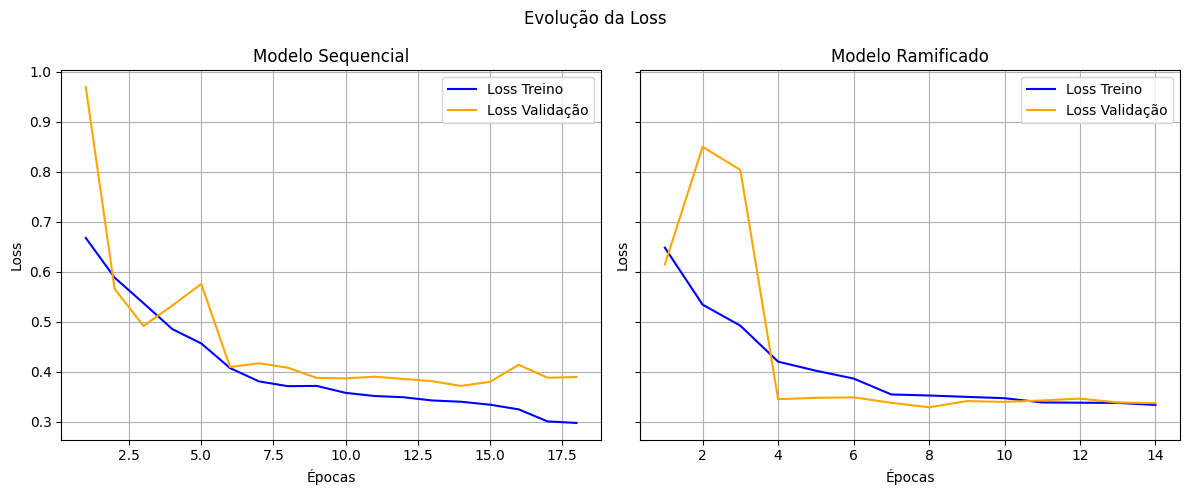

In [47]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

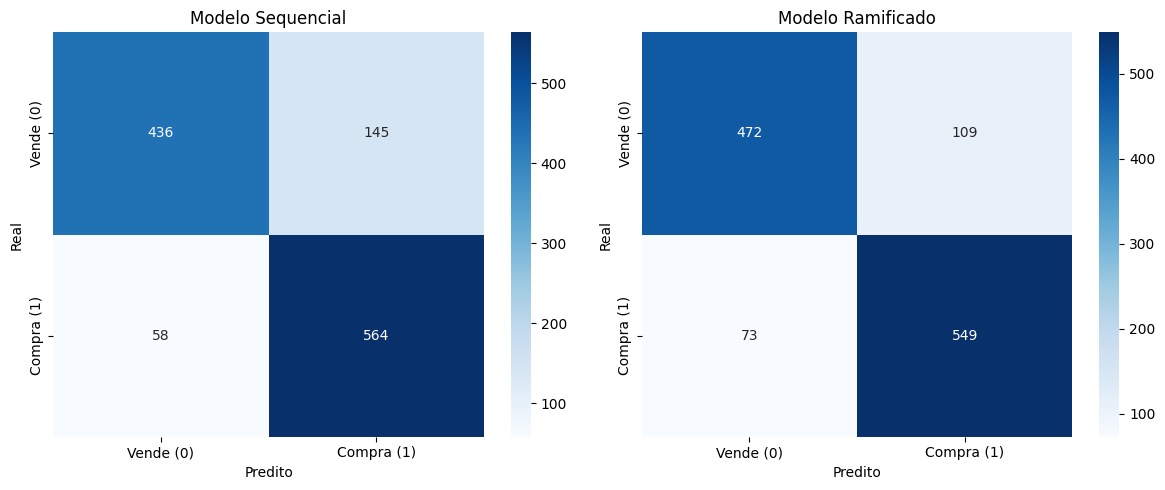

In [48]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [49]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.88
Recall:    0.75
F1-Score:  0.81

Compra (1):
Precision: 0.80
Recall:    0.91
F1-Score:  0.85

Médias:
Acurácia:  0.83
Precision: 0.84
Recall:    0.83
F1-Score:  0.83


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.87
Recall:    0.81
F1-Score:  0.84

Compra (1):
Precision: 0.83
Recall:    0.88
F1-Score:  0.86

Médias:
Acurácia:  0.85
Precision: 0.85
Recall:    0.85
F1-Score:  0.85




In [50]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="PETR4",
    metrics = best_seq_metrics,
    cdi_df = cdi,
    metric_optimization = metric_optimization
)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="PETR4",
    metrics = best_ram_metrics,
    cdi_df=cdi,
    metric_optimization = metric_optimization
)

resultado_backtest

<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


,Data,Modelo,Ação,Métrica de Otimização,Acurácia,Precision,Recall,F1,Matriz de Confusão,Saldo Inicial,Saldo Final,Total de Ações,Lucro Total,Lucro (%),Lucro (%) CDI
0,2025-04-13 14:10:15.041119,CNN Sequencial,CSAN3,val_loss,0.885329,0.882166,0.882586,0.882373,"[[619, 69], [67, 431]]",10000,3.640817,990.0,9467.040666,94.670407,42.269210
1,2025-04-13 14:10:15.069407,CNN Ramificado,CSAN3,val_loss,0.881956,0.880287,0.876629,0.878284,"[[626, 62], [78, 420]]",10000,8.435907,1065.0,10946.335745,109.463357,42.269210
2,2025-04-13 14:37:38.702181,CNN Sequencial,BBAS3,val_loss,0.865823,0.861527,0.864002,0.862654,"[[603, 86], [73, 423]]",10000,39.235968,247.0,3720.565817,37.205658,42.269210
3,2025-04-13 14:37:38.727148,CNN Ramificado,BBAS3,val_loss,0.898734,0.897139,0.894281,0.895610,"[[635, 54], [66, 430]]",10000,38.974524,310.0,7209.874334,72.098743,42.269210
4,2025-04-13 15:02:36.679384,CNN Sequencial,PETR4,val_loss,0.831255,0.839039,0.828591,0.829323,"[[436, 145], [58, 564]]",10000,1.062806,809.0,20128.224164,201.282242,42.937875
5,2025-04-13 15:02:36.703969,CNN Ramificado,PETR4,val_loss,0.848712,0.850201,0.847515,0.848089,"[[472, 109], [73, 549]]",10000,12.695825,817.0,20437.777196,204.377772,42.937875


### VALE3

In [51]:
X_train, X_test, y_train, y_test, features = preprocess_data(vl_train, vl_test)

In [52]:
janela_curta = features[:7]
janela_longa = features[7:]
X_train1, X_test1, X_train2, X_test2, y_train, y_test, features = preprocess_data(vl_train, vl_test, split_features=[janela_curta,janela_longa])

In [53]:
prices = vl_test.set_index("Date")["Close"]
metric_optimization = 'val_loss'

In [54]:
best_seq_model, best_seq_history, df_results, best_seq_metrics, best_seq_y_pred = train_model(
    model_fn=model_cnn_sequencial,
    model_path = "BEST_CNN_SEQ_VALE3.keras",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization
)


[I 2025-04-13 15:02:36,776] A new study created in memory with name: no-name-a78a57b9-79a3-4d8e-b4fc-b9587c11c758


Epoch 1/28
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5545 - loss: 0.6917
Epoch 1: val_loss improved from inf to 0.69556, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5547 - loss: 0.6916 - val_accuracy: 0.4996 - val_loss: 0.6956 - learning_rate: 0.0058
Epoch 2/28
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6847
Epoch 2: val_loss did not improve from 0.69556
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5665 - loss: 0.6847 - val_accuracy: 0.5096 - val_loss: 0.7441 - learning_rate: 0.0058
Epoch 3/28
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5660 - loss: 0.6756
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0021603113189390183.

Epoch 3: val_loss did not improve from 0.69556
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5666 - loss: 0.6751 - val_accuracy: 0.5170 - val_loss: 2.2162 - learning_rate: 0.0058
Epoch 4/28
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

[I 2025-04-13 15:02:59,982] Trial 0 finished with value: -0.38857200741767883 and parameters: {'epochs': 28, 'batch_size': 32, 'learning_rate': 0.005766881191508113, 'stop_patience': 6, 'reduce_lr_factor': 0.3746065260306838, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.38857200741767883.


Epoch 1/24
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 0.6883
Epoch 1: val_loss improved from inf to 0.69770, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5561 - loss: 0.6882 - val_accuracy: 0.4996 - val_loss: 0.6977 - learning_rate: 3.1301e-04
Epoch 2/24
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5591 - loss: 0.6805
Epoch 2: val_loss did not improve from 0.69770
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5593 - loss: 0.6805 - val_accuracy: 0.5254 - val_loss: 0.7552 - learning_rate: 3.1301e-04
Epoch 3/24
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5957 - loss: 0.6632
Epoch 3: val_loss improved from 0.69770 to 0.52520, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5957 - loss: 0.6632 - val_accuracy: 0.7332 - val_loss: 0.5252 - learning_rate: 3.1301e-04
Epoch 4/24
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6289 - loss:

[I 2025-04-13 15:03:31,047] Trial 1 finished with value: -0.4204093813896179 and parameters: {'epochs': 24, 'batch_size': 16, 'learning_rate': 0.00031300763046390506, 'stop_patience': 5, 'reduce_lr_factor': 0.1978588335765783, 'reduce_lr_patience': 2}. Best is trial 0 with value: -0.38857200741767883.


Epoch 1/44
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5660 - loss: 0.6842
Epoch 1: val_loss improved from inf to 0.65765, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5665 - loss: 0.6840 - val_accuracy: 0.7132 - val_loss: 0.6577 - learning_rate: 0.0032
Epoch 2/44
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5902 - loss: 0.6640
Epoch 2: val_loss did not improve from 0.65765
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5925 - loss: 0.6616 - val_accuracy: 0.5902 - val_loss: 1.2596 - learning_rate: 0.0032
Epoch 3/44
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6702 - loss: 0.5800
Epoch 3: val_loss did not improve from 0.65765
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6708 - loss: 0.5791 - val_accuracy: 0.6958 - val_loss: 1.1064 - learning_rate: 0.0032
Epoch 4/44
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6918 - loss: 0.5362
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00160213

[I 2025-04-13 15:03:37,318] Trial 2 finished with value: -0.6576535105705261 and parameters: {'epochs': 44, 'batch_size': 64, 'learning_rate': 0.003216905383341724, 'stop_patience': 4, 'reduce_lr_factor': 0.49803729022889276, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.38857200741767883.


Epoch 1/24
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5590 - loss: 0.6918
Epoch 1: val_loss improved from inf to 0.69921, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5590 - loss: 0.6918 - val_accuracy: 0.4996 - val_loss: 0.6992 - learning_rate: 0.0069
Epoch 2/24
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5655 - loss: 0.6859
Epoch 2: val_loss did not improve from 0.69921
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5655 - loss: 0.6859 - val_accuracy: 0.4996 - val_loss: 0.7000 - learning_rate: 0.0069
Epoch 3/24
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5661 - loss: 0.6853
Epoch 3: val_loss did not improve from 0.69921
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5661 - loss: 0.6853 - val_accuracy: 0.4996 - val_loss: 0.7004 - learning_rate: 0.0069
Epoch 4/24
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5661 - loss: 0.6850
Epoch 4: val_loss did not improve from 0.69921
301

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-13 15:03:56,764] Trial 3 finished with

Epoch 1/11
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5451 - loss: 0.6888
Epoch 1: val_loss improved from inf to 0.71658, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5456 - loss: 0.6887 - val_accuracy: 0.5021 - val_loss: 0.7166 - learning_rate: 0.0027
Epoch 2/11
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5726 - loss: 0.6816
Epoch 2: val_loss improved from 0.71658 to 0.46205, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5735 - loss: 0.6807 - val_accuracy: 0.7797 - val_loss: 0.4621 - learning_rate: 0.0027
Epoch 3/11
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6391 - loss: 0.6308
Epoch 3: val_loss did not improve from 0.46205
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6392 - loss: 0.6306 - val_accuracy: 0.7639 - val_loss: 0.5024 - learning_rate: 0.0027
Epoch 4/11
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - loss: 0.5707
Epoc

[I 2025-04-13 15:04:11,307] Trial 4 finished with value: -0.3519790768623352 and parameters: {'epochs': 11, 'batch_size': 32, 'learning_rate': 0.0027488908371958195, 'stop_patience': 9, 'reduce_lr_factor': 0.2625292326422555, 'reduce_lr_patience': 3}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/36
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5593 - loss: 0.6934
Epoch 1: val_loss improved from inf to 0.70299, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5594 - loss: 0.6933 - val_accuracy: 0.4996 - val_loss: 0.7030 - learning_rate: 0.0075
Epoch 2/36
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5634 - loss: 0.6856
Epoch 2: val_loss improved from 0.70299 to 0.70047, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5633 - loss: 0.6856 - val_accuracy: 0.4996 - val_loss: 0.7005 - learning_rate: 0.0075
Epoch 3/36
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6850
Epoch 3: val_loss improved from 0.70047 to 0.69919, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5665 - loss: 0.6850 - val_accuracy: 0.4996 - val_loss: 0.6992 - learning_rate: 0.0075
Epoch 4/36
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 15:04:27,282] Trial 5 finished with value: -0.4995071589946747 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.007454504574945669, 'stop_patience': 5, 'reduce_lr_factor': 0.472764892588297, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/19
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5498 - loss: 0.6896
Epoch 1: val_loss improved from inf to 0.69675, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5501 - loss: 0.6895 - val_accuracy: 0.4605 - val_loss: 0.6967 - learning_rate: 0.0067
Epoch 2/19
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5641 - loss: 0.6862
Epoch 2: val_loss improved from 0.69675 to 0.69526, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5641 - loss: 0.6861 - val_accuracy: 0.4996 - val_loss: 0.6953 - learning_rate: 0.0067
Epoch 3/19
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5662 - loss: 0.6845
Epoch 3: val_loss improved from 0.69526 to 0.69383, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5662 - loss: 0.6845 - val_accuracy: 0.5578 - val_loss: 0.6938 - learning_rate: 0.0067
Epoch 4/19
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2025-04-13 15:04:49,256] Trial 6 finished with value: -0.38983431458473206 and parameters: {'epochs': 19, 'batch_size': 32, 'learning_rate': 0.006687145121162215, 'stop_patience': 5, 'reduce_lr_factor': 0.45927829084008054, 'reduce_lr_patience': 3}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/21
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5518 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.69640, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5519 - loss: 0.6905 - val_accuracy: 0.4996 - val_loss: 0.6964 - learning_rate: 0.0039
Epoch 2/21
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5663 - loss: 0.6854
Epoch 2: val_loss did not improve from 0.69640
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5663 - loss: 0.6854 - val_accuracy: 0.4996 - val_loss: 0.6987 - learning_rate: 0.0039
Epoch 3/21
284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6846
Epoch 3: val_loss did not improve from 0.69640
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5666 - loss: 0.6846 - val_accuracy: 0.4996 - val_loss: 0.7056 - learning_rate: 0.0039
Epoch 4/21
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5663 - loss: 0.6845
Epoch 4: val_loss did not improve from 0.69640
301

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-04-13 15:04:58,773] Trial 7 finished with

Epoch 1/11
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5532 - loss: 0.6852
Epoch 1: val_loss improved from inf to 0.71345, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5547 - loss: 0.6850 - val_accuracy: 0.5104 - val_loss: 0.7134 - learning_rate: 0.0045
Epoch 2/11
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5765 - loss: 0.6776
Epoch 2: val_loss did not improve from 0.71345
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5782 - loss: 0.6761 - val_accuracy: 0.6243 - val_loss: 0.7556 - learning_rate: 0.0045
Epoch 3/11
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6319 - loss: 0.6073
Epoch 3: val_loss did not improve from 0.71345
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6315 - loss: 0.6077 - val_accuracy: 0.5852 - val_loss: 0.9138 - learning_rate: 0.0045
Epoch 4/11
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6974 - loss: 0.5402
Epoch 4: val_loss improved from 0.71345 to 0.67379, saving mode

[I 2025-04-13 15:05:09,659] Trial 8 finished with value: -0.3525041937828064 and parameters: {'epochs': 11, 'batch_size': 64, 'learning_rate': 0.004538606144512357, 'stop_patience': 6, 'reduce_lr_factor': 0.19550703911962658, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/28
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5493 - loss: 0.6876
Epoch 1: val_loss improved from inf to 0.80712, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5497 - loss: 0.6874 - val_accuracy: 0.5071 - val_loss: 0.8071 - learning_rate: 0.0028
Epoch 2/28
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5775 - loss: 0.6716
Epoch 2: val_loss did not improve from 0.80712
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5793 - loss: 0.6701 - val_accuracy: 0.6010 - val_loss: 0.9506 - learning_rate: 0.0028
Epoch 3/28
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6516 - loss: 0.5978
Epoch 3: val_loss improved from 0.80712 to 0.39593, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6533 - loss: 0.5963 - val_accuracy: 0.8304 - val_loss: 0.3959 - learning_rate: 0.0028
Epoch 4/28
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7129 - loss: 0.5238
Epoch 4: val_loss

[I 2025-04-13 15:05:20,136] Trial 9 finished with value: -0.3633597493171692 and parameters: {'epochs': 28, 'batch_size': 64, 'learning_rate': 0.0028003582065748668, 'stop_patience': 5, 'reduce_lr_factor': 0.11363215414889966, 'reduce_lr_patience': 3}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/10
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5453 - loss: 0.6930
Epoch 1: val_loss improved from inf to 0.70118, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5465 - loss: 0.6927 - val_accuracy: 0.4996 - val_loss: 0.7012 - learning_rate: 0.0094
Epoch 2/10
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6851
Epoch 2: val_loss improved from 0.70118 to 0.69653, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5665 - loss: 0.6851 - val_accuracy: 0.4996 - val_loss: 0.6965 - learning_rate: 0.0094
Epoch 3/10
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6864
Epoch 3: val_loss did not improve from 0.69653
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5665 - loss: 0.6864 - val_accuracy: 0.4996 - val_loss: 0.7017 - learning_rate: 0.0094
Epoch 4/10
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6849
Epoc

[I 2025-04-13 15:05:35,275] Trial 10 finished with value: -0.5358989238739014 and parameters: {'epochs': 10, 'batch_size': 32, 'learning_rate': 0.009393035529964462, 'stop_patience': 10, 'reduce_lr_factor': 0.26061986245988755, 'reduce_lr_patience': 5}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/11
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5583 - loss: 0.6867
Epoch 1: val_loss improved from inf to 0.77270, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5595 - loss: 0.6861 - val_accuracy: 0.5079 - val_loss: 0.7727 - learning_rate: 0.0010
Epoch 2/11
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5798 - loss: 0.6713
Epoch 2: val_loss did not improve from 0.77270
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5798 - loss: 0.6710 - val_accuracy: 0.5079 - val_loss: 0.9331 - learning_rate: 0.0010
Epoch 3/11
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5965 - loss: 0.6491
Epoch 3: val_loss improved from 0.77270 to 0.47084, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5988 - loss: 0.6469 - val_accuracy: 0.7697 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 4/11
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6889 - loss: 0.5616
Epoch 4: val_loss

[I 2025-04-13 15:05:45,725] Trial 11 finished with value: -0.3683392107486725 and parameters: {'epochs': 11, 'batch_size': 64, 'learning_rate': 0.0010212313843109486, 'stop_patience': 9, 'reduce_lr_factor': 0.2282365006591205, 'reduce_lr_patience': 4}. Best is trial 4 with value: -0.3519790768623352.


Epoch 1/17
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5537 - loss: 0.6880
Epoch 1: val_loss improved from inf to 0.77057, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5552 - loss: 0.6875 - val_accuracy: 0.5112 - val_loss: 0.7706 - learning_rate: 0.0019
Epoch 2/17
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5798 - loss: 0.6774
Epoch 2: val_loss improved from 0.77057 to 0.47468, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5809 - loss: 0.6763 - val_accuracy: 0.7930 - val_loss: 0.4747 - learning_rate: 0.0019
Epoch 3/17
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6574 - loss: 0.6039
Epoch 3: val_loss did not improve from 0.47468
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6588 - loss: 0.6024 - val_accuracy: 0.8013 - val_loss: 0.4915 - learning_rate: 0.0019
Epoch 4/17
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7153 - loss: 0.5354
Epoch 4: val_loss

[I 2025-04-13 15:05:59,455] Trial 12 finished with value: -0.33781784772872925 and parameters: {'epochs': 17, 'batch_size': 64, 'learning_rate': 0.0018736363845014876, 'stop_patience': 8, 'reduce_lr_factor': 0.3162050428868693, 'reduce_lr_patience': 4}. Best is trial 12 with value: -0.33781784772872925.


Epoch 1/17
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5543 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.66620, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5552 - loss: 0.6862 - val_accuracy: 0.5919 - val_loss: 0.6662 - learning_rate: 0.0021
Epoch 2/17
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5741 - loss: 0.6654
Epoch 2: val_loss did not improve from 0.66620
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5749 - loss: 0.6648 - val_accuracy: 0.5403 - val_loss: 1.8193 - learning_rate: 0.0021
Epoch 3/17
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6468 - loss: 0.5962
Epoch 3: val_loss improved from 0.66620 to 0.66273, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6476 - loss: 0.5959 - val_accuracy: 0.7573 - val_loss: 0.6627 - learning_rate: 0.0021
Epoch 4/17
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.5597
Epoc

[I 2025-04-13 15:06:21,137] Trial 13 finished with value: -0.3326718509197235 and parameters: {'epochs': 17, 'batch_size': 32, 'learning_rate': 0.0021184541348516547, 'stop_patience': 8, 'reduce_lr_factor': 0.32537781163323903, 'reduce_lr_patience': 3}. Best is trial 13 with value: -0.3326718509197235.


Epoch 1/16
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5386 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.70024, saving model to BEST_CNN_SEQ_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5408 - loss: 0.6888 - val_accuracy: 0.5403 - val_loss: 0.7002 - learning_rate: 0.0017
Epoch 2/16
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5653 - loss: 0.6779
Epoch 2: val_loss did not improve from 0.70024
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5660 - loss: 0.6776 - val_accuracy: 0.5436 - val_loss: 0.7162 - learning_rate: 0.0017
Epoch 3/16
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6010 - loss: 0.6429
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005869009222034118.

Epoch 3: val_loss did not improve from 0.70024
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6013 - loss: 0.6427 - val_accuracy: 0.6359 - val_loss: 1.0686 - learning_rate: 0.0017
Epoch 4/16
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7066 -

[I 2025-04-13 15:06:34,929] Trial 14 finished with value: -0.3458998203277588 and parameters: {'epochs': 16, 'batch_size': 64, 'learning_rate': 0.0016891074747643858, 'stop_patience': 8, 'reduce_lr_factor': 0.34746214786946217, 'reduce_lr_patience': 2}. Best is trial 13 with value: -0.3326718509197235.


Epoch 1/34
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5475 - loss: 0.6891
Epoch 1: val_loss improved from inf to 0.72045, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5489 - loss: 0.6888 - val_accuracy: 0.5204 - val_loss: 0.7205 - learning_rate: 0.0020
Epoch 2/34
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 0.6781
Epoch 2: val_loss improved from 0.72045 to 0.69449, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5712 - loss: 0.6775 - val_accuracy: 0.6417 - val_loss: 0.6945 - learning_rate: 0.0020
Epoch 3/34
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6573 - loss: 0.6047
Epoch 3: val_loss did not improve from 0.69449
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6577 - loss: 0.6043 - val_accuracy: 0.5985 - val_loss: 1.8265 - learning_rate: 0.0020
Epoch 4/34
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6691 - loss: 0.5842
Epoc

[I 2025-04-13 15:07:15,996] Trial 15 finished with value: -0.3320251703262329 and parameters: {'epochs': 34, 'batch_size': 32, 'learning_rate': 0.0020269002924775594, 'stop_patience': 8, 'reduce_lr_factor': 0.325288488967878, 'reduce_lr_patience': 5}. Best is trial 15 with value: -0.3320251703262329.


Epoch 1/37
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5541 - loss: 0.6852
Epoch 1: val_loss improved from inf to 0.70721, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5551 - loss: 0.6848 - val_accuracy: 0.5370 - val_loss: 0.7072 - learning_rate: 7.9001e-04
Epoch 2/37
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5835 - loss: 0.6589
Epoch 2: val_loss improved from 0.70721 to 0.44890, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5836 - loss: 0.6588 - val_accuracy: 0.8013 - val_loss: 0.4489 - learning_rate: 7.9001e-04
Epoch 3/37
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 0.5935
Epoch 3: val_loss improved from 0.44890 to 0.42953, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6721 - loss: 0.5929 - val_accuracy: 0.8213 - val_loss: 0.4295 - learning_rate: 7.9001e-04
Epoch 4/37
148/151 ━━━━━━━━━━━━━

[I 2025-04-13 15:07:53,015] Trial 16 finished with value: -0.31853818893432617 and parameters: {'epochs': 37, 'batch_size': 32, 'learning_rate': 0.0007900140402050623, 'stop_patience': 8, 'reduce_lr_factor': 0.4154642722129085, 'reduce_lr_patience': 5}. Best is trial 16 with value: -0.31853818893432617.


Epoch 1/38
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5506 - loss: 0.6893
Epoch 1: val_loss improved from inf to 0.75466, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5508 - loss: 0.6893 - val_accuracy: 0.4996 - val_loss: 0.7547 - learning_rate: 3.6719e-04
Epoch 2/38
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5653 - loss: 0.6808
Epoch 2: val_loss improved from 0.75466 to 0.69656, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5653 - loss: 0.6808 - val_accuracy: 0.5345 - val_loss: 0.6966 - learning_rate: 3.6719e-04
Epoch 3/38
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5812 - loss: 0.6707
Epoch 3: val_loss improved from 0.69656 to 0.56138, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5813 - loss: 0.6706 - val_accuracy: 0.7398 - val_loss: 0.5614 - learning_rate: 3.6719e-04
Epoch 4/38
151/151 ━━━━━━━━━━━━━

[I 2025-04-13 15:08:39,197] Trial 17 finished with value: -0.3673752248287201 and parameters: {'epochs': 38, 'batch_size': 32, 'learning_rate': 0.0003671912001139382, 'stop_patience': 10, 'reduce_lr_factor': 0.36385432314677224, 'reduce_lr_patience': 5}. Best is trial 16 with value: -0.31853818893432617.


Epoch 1/35
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5538 - loss: 0.6891
Epoch 1: val_loss improved from inf to 0.73986, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5546 - loss: 0.6890 - val_accuracy: 0.4996 - val_loss: 0.7399 - learning_rate: 1.6576e-04
Epoch 2/35
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5671 - loss: 0.6820
Epoch 2: val_loss improved from 0.73986 to 0.66486, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5670 - loss: 0.6820 - val_accuracy: 0.5137 - val_loss: 0.6649 - learning_rate: 1.6576e-04
Epoch 3/35
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5659 - loss: 0.6765
Epoch 3: val_loss improved from 0.66486 to 0.65456, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5659 - loss: 0.6764 - val_accuracy: 0.6168 - val_loss: 0.6546 - learning_rate: 1.6576e-04
Epoch 4/35
141/151 ━━━━━━━━━━━━━

[I 2025-04-13 15:08:55,602] Trial 18 finished with value: -0.4247469902038574 and parameters: {'epochs': 35, 'batch_size': 32, 'learning_rate': 0.00016575683023936215, 'stop_patience': 7, 'reduce_lr_factor': 0.4298244639744494, 'reduce_lr_patience': 5}. Best is trial 16 with value: -0.31853818893432617.


Epoch 1/48
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5550 - loss: 0.6900
Epoch 1: val_loss improved from inf to 0.69969, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5555 - loss: 0.6898 - val_accuracy: 0.4996 - val_loss: 0.6997 - learning_rate: 0.0048
Epoch 2/48
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 0.6840
Epoch 2: val_loss improved from 0.69969 to 0.67031, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5664 - loss: 0.6840 - val_accuracy: 0.5520 - val_loss: 0.6703 - learning_rate: 0.0048
Epoch 3/48
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5692 - loss: 0.6747
Epoch 3: val_loss improved from 0.67031 to 0.65626, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5694 - loss: 0.6746 - val_accuracy: 0.6143 - val_loss: 0.6563 - learning_rate: 0.0048
Epoch 4/48
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 15:09:22,911] Trial 19 finished with value: -0.3588964641094208 and parameters: {'epochs': 48, 'batch_size': 32, 'learning_rate': 0.004840885722212587, 'stop_patience': 9, 'reduce_lr_factor': 0.41579500320003865, 'reduce_lr_patience': 5}. Best is trial 16 with value: -0.31853818893432617.


Epoch 1/41
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5547 - loss: 0.6895
Epoch 1: val_loss improved from inf to 0.75647, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5552 - loss: 0.6893 - val_accuracy: 0.5004 - val_loss: 0.7565 - learning_rate: 0.0014
Epoch 2/41
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 0.6738
Epoch 2: val_loss improved from 0.75647 to 0.59167, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5668 - loss: 0.6735 - val_accuracy: 0.6459 - val_loss: 0.5917 - learning_rate: 0.0014
Epoch 3/41
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6426 - loss: 0.6168
Epoch 3: val_loss did not improve from 0.59167
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6428 - loss: 0.6162 - val_accuracy: 0.7165 - val_loss: 0.9106 - learning_rate: 0.0014
Epoch 4/41
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6662 - loss: 0.5687
Epoc

[I 2025-04-13 15:09:57,292] Trial 20 finished with value: -0.31752559542655945 and parameters: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.0014212445863227706, 'stop_patience': 7, 'reduce_lr_factor': 0.41612579191529886, 'reduce_lr_patience': 5}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/42
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5490 - loss: 0.6861
Epoch 1: val_loss improved from inf to 0.56943, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5501 - loss: 0.6857 - val_accuracy: 0.6916 - val_loss: 0.5694 - learning_rate: 0.0014
Epoch 2/42
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6122 - loss: 0.6428
Epoch 2: val_loss did not improve from 0.56943
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6124 - loss: 0.6428 - val_accuracy: 0.7423 - val_loss: 0.5770 - learning_rate: 0.0014
Epoch 3/42
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6925 - loss: 0.5549
Epoch 3: val_loss improved from 0.56943 to 0.46874, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6930 - loss: 0.5542 - val_accuracy: 0.8171 - val_loss: 0.4687 - learning_rate: 0.0014
Epoch 4/42
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7192 - loss: 0.5205
Epoc

[I 2025-04-13 15:10:23,325] Trial 21 finished with value: -0.3341624438762665 and parameters: {'epochs': 42, 'batch_size': 32, 'learning_rate': 0.0013970650579833697, 'stop_patience': 7, 'reduce_lr_factor': 0.41408050241572175, 'reduce_lr_patience': 5}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/31
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.71091, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5665 - loss: 0.6888 - val_accuracy: 0.5037 - val_loss: 0.7109 - learning_rate: 0.0036
Epoch 2/31
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5686 - loss: 0.6828
Epoch 2: val_loss improved from 0.71091 to 0.55459, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5686 - loss: 0.6828 - val_accuracy: 0.7232 - val_loss: 0.5546 - learning_rate: 0.0036
Epoch 3/31
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6087 - loss: 0.6507
Epoch 3: val_loss did not improve from 0.55459
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6090 - loss: 0.6503 - val_accuracy: 0.5869 - val_loss: 2.1510 - learning_rate: 0.0036
Epoch 4/31
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6345 - loss: 0.6100
Epoc

[I 2025-04-13 15:10:59,455] Trial 22 finished with value: -0.3306175768375397 and parameters: {'epochs': 31, 'batch_size': 32, 'learning_rate': 0.0036304423454797136, 'stop_patience': 8, 'reduce_lr_factor': 0.4004697860040467, 'reduce_lr_patience': 5}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/40
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5538 - loss: 0.6879
Epoch 1: val_loss improved from inf to 0.71424, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5543 - loss: 0.6877 - val_accuracy: 0.5121 - val_loss: 0.7142 - learning_rate: 9.3010e-04
Epoch 2/40
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5814 - loss: 0.6698
Epoch 2: val_loss improved from 0.71424 to 0.49595, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5816 - loss: 0.6696 - val_accuracy: 0.7839 - val_loss: 0.4959 - learning_rate: 9.3010e-04
Epoch 3/40
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6438 - loss: 0.6121
Epoch 3: val_loss did not improve from 0.49595
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6439 - loss: 0.6120 - val_accuracy: 0.7839 - val_loss: 0.5178 - learning_rate: 9.3010e-04
Epoch 4/40
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7044 - loss:

[I 2025-04-13 15:11:21,533] Trial 23 finished with value: -0.3657205402851105 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.0009300996501531804, 'stop_patience': 7, 'reduce_lr_factor': 0.40368545518122695, 'reduce_lr_patience': 5}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/32
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5580 - loss: 0.6885
Epoch 1: val_loss improved from inf to 0.68880, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5581 - loss: 0.6885 - val_accuracy: 0.5004 - val_loss: 0.6888 - learning_rate: 0.0037
Epoch 2/32
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5660 - loss: 0.6837
Epoch 2: val_loss improved from 0.68880 to 0.62825, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5659 - loss: 0.6834 - val_accuracy: 0.5179 - val_loss: 0.6283 - learning_rate: 0.0037
Epoch 3/32
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6089 - loss: 0.6459
Epoch 3: val_loss improved from 0.62825 to 0.42699, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6096 - loss: 0.6455 - val_accuracy: 0.8088 - val_loss: 0.4270 - learning_rate: 0.0037
Epoch 4/32
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 15:12:01,022] Trial 24 finished with value: -0.3300561308860779 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.003685229512149847, 'stop_patience': 9, 'reduce_lr_factor': 0.44988147582153126, 'reduce_lr_patience': 4}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/46
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5547 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.69761, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5549 - loss: 0.6904 - val_accuracy: 0.4996 - val_loss: 0.6976 - learning_rate: 0.0044
Epoch 2/46
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 0.6850
Epoch 2: val_loss improved from 0.69761 to 0.66346, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5662 - loss: 0.6850 - val_accuracy: 0.5129 - val_loss: 0.6635 - learning_rate: 0.0044
Epoch 3/46
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5694 - loss: 0.6662
Epoch 3: val_loss improved from 0.66346 to 0.63624, saving model to BEST_CNN_SEQ_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5697 - loss: 0.6661 - val_accuracy: 0.6983 - val_loss: 0.6362 - learning_rate: 0.0044
Epoch 4/46
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4

[I 2025-04-13 15:12:58,050] Trial 25 finished with value: -0.36565759778022766 and parameters: {'epochs': 46, 'batch_size': 16, 'learning_rate': 0.004448386812230081, 'stop_patience': 9, 'reduce_lr_factor': 0.45457825629853255, 'reduce_lr_patience': 4}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/50
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5587 - loss: 0.6874
Epoch 1: val_loss improved from inf to 0.73211, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5587 - loss: 0.6873 - val_accuracy: 0.5046 - val_loss: 0.7321 - learning_rate: 0.0028
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5766 - loss: 0.6776
Epoch 2: val_loss did not improve from 0.73211
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5766 - loss: 0.6775 - val_accuracy: 0.5628 - val_loss: 1.0360 - learning_rate: 0.0028
Epoch 3/50
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6553 - loss: 0.6108
Epoch 3: val_loss improved from 0.73211 to 0.65000, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6554 - loss: 0.6106 - val_accuracy: 0.7623 - val_loss: 0.6500 - learning_rate: 0.0028
Epoch 4/50
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6654 - loss: 0.5707
Epoc

[I 2025-04-13 15:13:35,835] Trial 26 finished with value: -0.33867815136909485 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0027645660283425987, 'stop_patience': 10, 'reduce_lr_factor': 0.49402355427218697, 'reduce_lr_patience': 4}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/33
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5524 - loss: 0.6901
Epoch 1: val_loss improved from inf to 0.69313, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5525 - loss: 0.6900 - val_accuracy: 0.4996 - val_loss: 0.6931 - learning_rate: 0.0057
Epoch 2/33
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5619 - loss: 0.6853
Epoch 2: val_loss did not improve from 0.69313
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5619 - loss: 0.6854 - val_accuracy: 0.4996 - val_loss: 0.6996 - learning_rate: 0.0057
Epoch 3/33
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5667 - loss: 0.6849
Epoch 3: val_loss did not improve from 0.69313
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5668 - loss: 0.6848 - val_accuracy: 0.4996 - val_loss: 0.6935 - learning_rate: 0.0057
Epoch 4/33
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5631 - loss: 0.6801
Epoch 4: val_loss did not improve from 0.69313
151

[I 2025-04-13 15:13:57,981] Trial 27 finished with value: -0.5417189002037048 and parameters: {'epochs': 33, 'batch_size': 32, 'learning_rate': 0.005655886307651942, 'stop_patience': 6, 'reduce_lr_factor': 0.440201988055143, 'reduce_lr_patience': 4}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/40
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5650 - loss: 0.6867
Epoch 1: val_loss improved from inf to 0.74170, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5652 - loss: 0.6865 - val_accuracy: 0.5387 - val_loss: 0.7417 - learning_rate: 9.5526e-04
Epoch 2/40
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5902 - loss: 0.6607
Epoch 2: val_loss improved from 0.74170 to 0.49098, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5904 - loss: 0.6604 - val_accuracy: 0.7722 - val_loss: 0.4910 - learning_rate: 9.5526e-04
Epoch 3/40
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6482 - loss: 0.6080
Epoch 3: val_loss did not improve from 0.49098
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6487 - loss: 0.6077 - val_accuracy: 0.7972 - val_loss: 0.4931 - learning_rate: 9.5526e-04
Epoch 4/40
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6888 - loss

[I 2025-04-13 15:14:43,431] Trial 28 finished with value: -0.32239654660224915 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.0009552629498519503, 'stop_patience': 9, 'reduce_lr_factor': 0.46875376954888326, 'reduce_lr_patience': 5}. Best is trial 20 with value: -0.31752559542655945.


Epoch 1/40
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5595 - loss: 0.6875
Epoch 1: val_loss improved from inf to 0.71626, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5597 - loss: 0.6874 - val_accuracy: 0.5112 - val_loss: 0.7163 - learning_rate: 8.4030e-04
Epoch 2/40
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5746 - loss: 0.6722
Epoch 2: val_loss improved from 0.71626 to 0.55552, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5755 - loss: 0.6715 - val_accuracy: 0.6542 - val_loss: 0.5555 - learning_rate: 8.4030e-04
Epoch 3/40
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6347 - loss: 0.6271
Epoch 3: val_loss improved from 0.55552 to 0.41413, saving model to BEST_CNN_SEQ_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6347 - loss: 0.6273 - val_accuracy: 0.8171 - val_loss: 0.4141 - learning_rate: 8.4030e-04
Epoch 4/40
150/151 ━━━━━━━━━━━━━

[I 2025-04-13 15:15:02,973] Trial 29 finished with value: -0.3580297529697418 and parameters: {'epochs': 40, 'batch_size': 32, 'learning_rate': 0.0008402976922182054, 'stop_patience': 6, 'reduce_lr_factor': 0.38727521116419283, 'reduce_lr_patience': 5}. Best is trial 20 with value: -0.31752559542655945.



✅ Melhor combinação encontrada:
trial                  20.000000
epochs                 41.000000
batch_size             32.000000
learning_rate           0.001421
stop_patience           7.000000
reduce_lr_factor        0.416126
reduce_lr_patience      5.000000
recall_Compra(1)        0.875415
recall_Vende(0)         0.836938
precision_Compra(1)     0.843200
precision_Vende(0)      0.870242
macro_recall            0.856177
accuracy                0.856193
f1_macro                0.856136
f1_weighted             0.856138
min_val_loss            0.317526
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 41, 'batch_size': 32, 'learning_rate': 0.0014212445863227706, 'stop_patience': 7, 'reduce_lr_factor': 0.41612579191529886, 'reduce_lr_patience': 5}


In [55]:
best_ram_model, best_ram_history, df_results, best_ram_metrics, best_ram_y_pred = train_model(
    model_fn=model_cnn_ramificado,
    model_path = "BEST_CNN_RAM_VALE3.keras",
    X_train=[X_train1, X_train2],
    y_train=y_train,
    X_test=[X_test1, X_test2],
    y_test=y_test,
    prob=0.5,
    n_trials=30,
    metric_to_optimize=metric_optimization)


[I 2025-04-13 15:15:02,987] A new study created in memory with name: no-name-327424b5-9cb4-4329-a8ef-cfc483774238


Epoch 1/31
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.6775
Epoch 1: val_loss improved from inf to 0.93138, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5977 - loss: 0.6764 - val_accuracy: 0.5378 - val_loss: 0.9314 - learning_rate: 0.0018
Epoch 2/31
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6364 - loss: 0.6259
Epoch 2: val_loss improved from 0.93138 to 0.54533, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6374 - loss: 0.6249 - val_accuracy: 0.7249 - val_loss: 0.5453 - learning_rate: 0.0018
Epoch 3/31
65/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6902 - loss: 0.5641
Epoch 3: val_loss improved from 0.54533 to 0.37121, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6902 - loss: 0.5631 - val_accuracy: 0.8371 - val_loss: 0.3712 - learning_rate: 0.0018
Epoch 4/31
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-13 15:15:24,585] Trial 0 finished with value: -0.3192391097545624 and parameters: {'epochs': 31, 'batch_size': 64, 'learning_rate': 0.001828543622028191, 'stop_patience': 9, 'reduce_lr_factor': 0.15712659953907482, 'reduce_lr_patience': 3}. Best is trial 0 with value: -0.3192391097545624.


Epoch 1/50
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5702 - loss: 0.6794
Epoch 1: val_loss improved from inf to 0.40457, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5710 - loss: 0.6787 - val_accuracy: 0.8421 - val_loss: 0.4046 - learning_rate: 0.0019
Epoch 2/50
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6860 - loss: 0.5737
Epoch 2: val_loss did not improve from 0.40457
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6861 - loss: 0.5735 - val_accuracy: 0.7091 - val_loss: 0.7141 - learning_rate: 0.0019
Epoch 3/50
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7282 - loss: 0.5044
Epoch 3: val_loss improved from 0.40457 to 0.31997, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7283 - loss: 0.5043 - val_accuracy: 0.8687 - val_loss: 0.3200 - learning_rate: 0.0019
Epoch 4/50
282/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7434 - loss: 0.4735
Epoc

[I 2025-04-13 15:16:04,043] Trial 1 finished with value: -0.2774333953857422 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.0018720637685351409, 'stop_patience': 10, 'reduce_lr_factor': 0.22064988223544002, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/43
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 0.6843
Epoch 1: val_loss improved from inf to 0.56710, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5679 - loss: 0.6834 - val_accuracy: 0.6924 - val_loss: 0.5671 - learning_rate: 0.0057
Epoch 2/43
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6374 - loss: 0.6039
Epoch 2: val_loss did not improve from 0.56710
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6398 - loss: 0.6008 - val_accuracy: 0.7847 - val_loss: 0.5833 - learning_rate: 0.0057
Epoch 3/43
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7031 - loss: 0.5197
Epoch 3: val_loss improved from 0.56710 to 0.56246, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7036 - loss: 0.5198 - val_accuracy: 0.7947 - val_loss: 0.5625 - learning_rate: 0.0057
Epoch 4/43
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7342 - loss: 0.4848
Epoch 4: val_loss 

[I 2025-04-13 15:16:09,859] Trial 2 finished with value: -0.562460720539093 and parameters: {'epochs': 43, 'batch_size': 64, 'learning_rate': 0.005718774497704813, 'stop_patience': 3, 'reduce_lr_factor': 0.40219127158182777, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/23
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5822 - loss: 0.6844
Epoch 1: val_loss improved from inf to 1.42222, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5832 - loss: 0.6834 - val_accuracy: 0.5453 - val_loss: 1.4222 - learning_rate: 0.0084
Epoch 2/23
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6715 - loss: 0.5793
Epoch 2: val_loss improved from 1.42222 to 1.14617, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6722 - loss: 0.5785 - val_accuracy: 0.6958 - val_loss: 1.1462 - learning_rate: 0.0084
Epoch 3/23
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7002 - loss: 0.5178
Epoch 3: val_loss improved from 1.14617 to 1.07188, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7008 - loss: 0.5180 - val_accuracy: 0.7099 - val_loss: 1.0719 - learning_rate: 0.0084
Epoch 4/23
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-13 15:16:21,243] Trial 3 finished with value: -0.31389713287353516 and parameters: {'epochs': 23, 'batch_size': 64, 'learning_rate': 0.008409663113879579, 'stop_patience': 5, 'reduce_lr_factor': 0.3054012486065254, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/12
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5745 - loss: 0.6850
Epoch 1: val_loss improved from inf to 0.66282, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5750 - loss: 0.6844 - val_accuracy: 0.6791 - val_loss: 0.6628 - learning_rate: 0.0095
Epoch 2/12
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6631 - loss: 0.5771
Epoch 2: val_loss improved from 0.66282 to 0.34782, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6639 - loss: 0.5761 - val_accuracy: 0.8470 - val_loss: 0.3478 - learning_rate: 0.0095
Epoch 3/12
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7180 - loss: 0.5035
Epoch 3: val_loss did not improve from 0.34782
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7179 - loss: 0.5032 - val_accuracy: 0.7249 - val_loss: 0.8718 - learning_rate: 0.0095
Epoch 4/12
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7342 - loss: 0.4853
Epoch 4: val_loss 

[I 2025-04-13 15:16:26,649] Trial 4 finished with value: -0.347820520401001 and parameters: {'epochs': 12, 'batch_size': 64, 'learning_rate': 0.009531932954001052, 'stop_patience': 3, 'reduce_lr_factor': 0.12199508922223115, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/10
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5515 - loss: 0.6943
Epoch 1: val_loss improved from inf to 0.59557, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5531 - loss: 0.6924 - val_accuracy: 0.6783 - val_loss: 0.5956 - learning_rate: 0.0091
Epoch 2/10
141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6551 - loss: 0.5900
Epoch 2: val_loss improved from 0.59557 to 0.46689, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6560 - loss: 0.5889 - val_accuracy: 0.7664 - val_loss: 0.4669 - learning_rate: 0.0091
Epoch 3/10
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7106 - loss: 0.5210
Epoch 3: val_loss improved from 0.46689 to 0.32490, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7110 - loss: 0.5209 - val_accuracy: 0.8603 - val_loss: 0.3249 - learning_rate: 0.0091
Epoch 4/10
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:16:39,927] Trial 5 finished with value: -0.28052252531051636 and parameters: {'epochs': 10, 'batch_size': 32, 'learning_rate': 0.009134649778343598, 'stop_patience': 8, 'reduce_lr_factor': 0.14689677826127712, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/18
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5767 - loss: 0.6801
Epoch 1: val_loss improved from inf to 0.46861, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5778 - loss: 0.6792 - val_accuracy: 0.8362 - val_loss: 0.4686 - learning_rate: 0.0017
Epoch 2/18
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6513 - loss: 0.6104
Epoch 2: val_loss did not improve from 0.46861
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6517 - loss: 0.6100 - val_accuracy: 0.6459 - val_loss: 0.9044 - learning_rate: 0.0017
Epoch 3/18
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7018 - loss: 0.5468
Epoch 3: val_loss did not improve from 0.46861
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7031 - loss: 0.5466 - val_accuracy: 0.7298 - val_loss: 0.7748 - learning_rate: 0.0017
Epoch 4/18
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7329 - loss: 0.5005
Epoch 4: val_loss improved from 0.46861 to 0.36802

[I 2025-04-13 15:16:58,885] Trial 6 finished with value: -0.2853209972381592 and parameters: {'epochs': 18, 'batch_size': 32, 'learning_rate': 0.0017329039706937025, 'stop_patience': 7, 'reduce_lr_factor': 0.25195951682837625, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/39
72/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5892 - loss: 0.6795
Epoch 1: val_loss improved from inf to 1.35123, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5900 - loss: 0.6787 - val_accuracy: 0.5104 - val_loss: 1.3512 - learning_rate: 0.0015
Epoch 2/39
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6304 - loss: 0.6341
Epoch 2: val_loss improved from 1.35123 to 0.48183, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6317 - loss: 0.6330 - val_accuracy: 0.7714 - val_loss: 0.4818 - learning_rate: 0.0015
Epoch 3/39
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6820 - loss: 0.5830
Epoch 3: val_loss improved from 0.48183 to 0.36659, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6823 - loss: 0.5822 - val_accuracy: 0.8412 - val_loss: 0.3666 - learning_rate: 0.0015
Epoch 4/39
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

[I 2025-04-13 15:17:04,951] Trial 7 finished with value: -0.36658555269241333 and parameters: {'epochs': 39, 'batch_size': 64, 'learning_rate': 0.0014676586178839865, 'stop_patience': 3, 'reduce_lr_factor': 0.3155493601008976, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/23
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5724 - loss: 0.6787
Epoch 1: val_loss improved from inf to 0.97290, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5748 - loss: 0.6769 - val_accuracy: 0.5420 - val_loss: 0.9729 - learning_rate: 0.0021
Epoch 2/23
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6425 - loss: 0.6174
Epoch 2: val_loss improved from 0.97290 to 0.37321, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6439 - loss: 0.6163 - val_accuracy: 0.8495 - val_loss: 0.3732 - learning_rate: 0.0021
Epoch 3/23
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7002 - loss: 0.5478
Epoch 3: val_loss did not improve from 0.37321
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7018 - loss: 0.5465 - val_accuracy: 0.8229 - val_loss: 0.4263 - learning_rate: 0.0021
Epoch 4/23
70/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7371 - loss: 0.5033
Epoch 4: val_loss

[I 2025-04-13 15:17:22,686] Trial 8 finished with value: -0.2833632528781891 and parameters: {'epochs': 23, 'batch_size': 64, 'learning_rate': 0.002079191816982261, 'stop_patience': 5, 'reduce_lr_factor': 0.18492940400111393, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/16
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5536 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.89602, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5541 - loss: 0.6907 - val_accuracy: 0.4996 - val_loss: 0.8960 - learning_rate: 0.0048
Epoch 2/16
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6478 - loss: 0.6093
Epoch 2: val_loss improved from 0.89602 to 0.70552, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6487 - loss: 0.6085 - val_accuracy: 0.6351 - val_loss: 0.7055 - learning_rate: 0.0048
Epoch 3/16
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6921 - loss: 0.5359
Epoch 3: val_loss improved from 0.70552 to 0.37470, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6930 - loss: 0.5354 - val_accuracy: 0.8470 - val_loss: 0.3747 - learning_rate: 0.0048
Epoch 4/16
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:17:47,541] Trial 9 finished with value: -0.29134783148765564 and parameters: {'epochs': 16, 'batch_size': 16, 'learning_rate': 0.0047683824538190915, 'stop_patience': 10, 'reduce_lr_factor': 0.309015449492817, 'reduce_lr_patience': 5}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/50
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5521 - loss: 0.6888
Epoch 1: val_loss improved from inf to 0.37870, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5535 - loss: 0.6877 - val_accuracy: 0.8628 - val_loss: 0.3787 - learning_rate: 0.0043
Epoch 2/50
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6764 - loss: 0.5621
Epoch 2: val_loss did not improve from 0.37870
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6766 - loss: 0.5619 - val_accuracy: 0.7614 - val_loss: 0.5644 - learning_rate: 0.0043
Epoch 3/50
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7214 - loss: 0.5077
Epoch 3: val_loss improved from 0.37870 to 0.31157, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7215 - loss: 0.5075 - val_accuracy: 0.8720 - val_loss: 0.3116 - learning_rate: 0.0043
Epoch 4/50
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7541 - loss: 0.4658
Epoc

[I 2025-04-13 15:18:24,096] Trial 10 finished with value: -0.2903296649456024 and parameters: {'epochs': 50, 'batch_size': 16, 'learning_rate': 0.004333134143496001, 'stop_patience': 10, 'reduce_lr_factor': 0.49591691911637015, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/36
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5528 - loss: 0.6964
Epoch 1: val_loss improved from inf to 0.54066, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5545 - loss: 0.6952 - val_accuracy: 0.6758 - val_loss: 0.5407 - learning_rate: 0.0069
Epoch 2/36
137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6306 - loss: 0.6226
Epoch 2: val_loss improved from 0.54066 to 0.33803, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6312 - loss: 0.6220 - val_accuracy: 0.8504 - val_loss: 0.3380 - learning_rate: 0.0069
Epoch 3/36
140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6801 - loss: 0.5628
Epoch 3: val_loss did not improve from 0.33803
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6810 - loss: 0.5621 - val_accuracy: 0.8329 - val_loss: 0.4136 - learning_rate: 0.0069
Epoch 4/36
139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7194 - loss: 0.5197
Epoc

[I 2025-04-13 15:18:40,010] Trial 11 finished with value: -0.2947079837322235 and parameters: {'epochs': 36, 'batch_size': 32, 'learning_rate': 0.006924149091559201, 'stop_patience': 8, 'reduce_lr_factor': 0.21345596929398586, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/50
144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5676 - loss: 0.6931
Epoch 1: val_loss improved from inf to 0.96594, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5675 - loss: 0.6931 - val_accuracy: 0.4996 - val_loss: 0.9659 - learning_rate: 2.1335e-05
Epoch 2/50
147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5667 - loss: 0.6863
Epoch 2: val_loss improved from 0.96594 to 0.87974, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5667 - loss: 0.6863 - val_accuracy: 0.4996 - val_loss: 0.8797 - learning_rate: 2.1335e-05
Epoch 3/50
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5816 - loss: 0.6830
Epoch 3: val_loss improved from 0.87974 to 0.84212, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5815 - loss: 0.6830 - val_accuracy: 0.4996 - val_loss: 0.8421 - learning_rate: 2.1335e-05
Epoch 4/50
137/151 ━━━━━━━━━━━━━

[I 2025-04-13 15:19:33,589] Trial 12 finished with value: -0.39339303970336914 and parameters: {'epochs': 50, 'batch_size': 32, 'learning_rate': 2.133463352089267e-05, 'stop_patience': 8, 'reduce_lr_factor': 0.1035126247368423, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/29
284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5665 - loss: 0.6825
Epoch 1: val_loss improved from inf to 0.66498, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5681 - loss: 0.6812 - val_accuracy: 0.6708 - val_loss: 0.6650 - learning_rate: 0.0037
Epoch 2/29
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6781 - loss: 0.5712
Epoch 2: val_loss improved from 0.66498 to 0.56823, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6783 - loss: 0.5707 - val_accuracy: 0.7406 - val_loss: 0.5682 - learning_rate: 0.0037
Epoch 3/29
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7158 - loss: 0.5082
Epoch 3: val_loss improved from 0.56823 to 0.34985, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7163 - loss: 0.5078 - val_accuracy: 0.8587 - val_loss: 0.3499 - learning_rate: 0.0037
Epoch 4/29
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:20:05,368] Trial 13 finished with value: -0.30218201875686646 and parameters: {'epochs': 29, 'batch_size': 16, 'learning_rate': 0.003711062908142598, 'stop_patience': 9, 'reduce_lr_factor': 0.23714045774966258, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/10
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5554 - loss: 0.6934
Epoch 1: val_loss improved from inf to 0.41662, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5560 - loss: 0.6928 - val_accuracy: 0.8204 - val_loss: 0.4166 - learning_rate: 0.0072
Epoch 2/10
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6757 - loss: 0.5691
Epoch 2: val_loss improved from 0.41662 to 0.34649, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6758 - loss: 0.5688 - val_accuracy: 0.8437 - val_loss: 0.3465 - learning_rate: 0.0072
Epoch 3/10
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.5036
Epoch 3: val_loss improved from 0.34649 to 0.31926, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7260 - loss: 0.5039 - val_accuracy: 0.8628 - val_loss: 0.3193 - learning_rate: 0.0072
Epoch 4/10
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[I 2025-04-13 15:20:17,689] Trial 14 finished with value: -0.28953590989112854 and parameters: {'epochs': 10, 'batch_size': 32, 'learning_rate': 0.007221065906236191, 'stop_patience': 7, 'reduce_lr_factor': 0.16149525482935329, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/44
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5570 - loss: 0.6989
Epoch 1: val_loss improved from inf to 0.84259, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5571 - loss: 0.6987 - val_accuracy: 0.4996 - val_loss: 0.8426 - learning_rate: 0.0098
Epoch 2/44
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5706 - loss: 0.6405
Epoch 2: val_loss improved from 0.84259 to 0.72736, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5708 - loss: 0.6404 - val_accuracy: 0.5752 - val_loss: 0.7274 - learning_rate: 0.0098
Epoch 3/44
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6570 - loss: 0.5829
Epoch 3: val_loss improved from 0.72736 to 0.42456, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6585 - loss: 0.5822 - val_accuracy: 0.8279 - val_loss: 0.4246 - learning_rate: 0.0098
Epoch 4/44
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:20:41,603] Trial 15 finished with value: -0.3341563045978546 and parameters: {'epochs': 44, 'batch_size': 16, 'learning_rate': 0.009785974505945101, 'stop_patience': 9, 'reduce_lr_factor': 0.3726607583390283, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/28
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5535 - loss: 0.6933
Epoch 1: val_loss improved from inf to 1.23686, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5543 - loss: 0.6927 - val_accuracy: 0.5411 - val_loss: 1.2369 - learning_rate: 0.0061
Epoch 2/28
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6456 - loss: 0.5990
Epoch 2: val_loss improved from 1.23686 to 0.80693, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6456 - loss: 0.5990 - val_accuracy: 0.7107 - val_loss: 0.8069 - learning_rate: 0.0061
Epoch 3/28
290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7063 - loss: 0.5208
Epoch 3: val_loss improved from 0.80693 to 0.42883, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7064 - loss: 0.5205 - val_accuracy: 0.8163 - val_loss: 0.4288 - learning_rate: 0.0061
Epoch 4/28
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:21:00,703] Trial 16 finished with value: -0.3005468249320984 and parameters: {'epochs': 28, 'batch_size': 16, 'learning_rate': 0.006135357776723571, 'stop_patience': 6, 'reduce_lr_factor': 0.2609962755515859, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/22
148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5880 - loss: 0.6770
Epoch 1: val_loss improved from inf to 0.62737, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5885 - loss: 0.6763 - val_accuracy: 0.6717 - val_loss: 0.6274 - learning_rate: 0.0032
Epoch 2/22
136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 0.5824
Epoch 2: val_loss improved from 0.62737 to 0.56496, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6620 - loss: 0.5817 - val_accuracy: 0.7739 - val_loss: 0.5650 - learning_rate: 0.0032
Epoch 3/22
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7044 - loss: 0.5406
Epoch 3: val_loss did not improve from 0.56496
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7045 - loss: 0.5404 - val_accuracy: 0.6725 - val_loss: 0.8149 - learning_rate: 0.0032
Epoch 4/22
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7245 - loss: 0.5014
Epoc

[I 2025-04-13 15:21:25,849] Trial 17 finished with value: -0.2846693992614746 and parameters: {'epochs': 22, 'batch_size': 32, 'learning_rate': 0.0031859661419865733, 'stop_patience': 10, 'reduce_lr_factor': 0.19918592637202143, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/32
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5677 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.70200, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5686 - loss: 0.6879 - val_accuracy: 0.5810 - val_loss: 0.7020 - learning_rate: 0.0080
Epoch 2/32
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6382 - loss: 0.5792
Epoch 2: val_loss improved from 0.70200 to 0.48903, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6404 - loss: 0.5780 - val_accuracy: 0.7448 - val_loss: 0.4890 - learning_rate: 0.0080
Epoch 3/32
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6862 - loss: 0.5516
Epoch 3: val_loss improved from 0.48903 to 0.43808, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6862 - loss: 0.5519 - val_accuracy: 0.8163 - val_loss: 0.4381 - learning_rate: 0.0080
Epoch 4/32
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:21:50,542] Trial 18 finished with value: -0.2939980626106262 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.007996419017194384, 'stop_patience': 8, 'reduce_lr_factor': 0.1461241506084427, 'reduce_lr_patience': 4}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/44
298/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5650 - loss: 0.6805
Epoch 1: val_loss improved from inf to 0.52576, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5653 - loss: 0.6802 - val_accuracy: 0.7190 - val_loss: 0.5258 - learning_rate: 0.0029
Epoch 2/44
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6691 - loss: 0.5790
Epoch 2: val_loss improved from 0.52576 to 0.37586, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6698 - loss: 0.5782 - val_accuracy: 0.8529 - val_loss: 0.3759 - learning_rate: 0.0029
Epoch 3/44
287/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7106 - loss: 0.5186
Epoch 3: val_loss improved from 0.37586 to 0.32007, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7114 - loss: 0.5181 - val_accuracy: 0.8628 - val_loss: 0.3201 - learning_rate: 0.0029
Epoch 4/44
285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:22:20,901] Trial 19 finished with value: -0.2860284745693207 and parameters: {'epochs': 44, 'batch_size': 16, 'learning_rate': 0.0029369205829994876, 'stop_patience': 9, 'reduce_lr_factor': 0.36444623807325816, 'reduce_lr_patience': 2}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/36
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5500 - loss: 0.6867
Epoch 1: val_loss improved from inf to 0.57152, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5506 - loss: 0.6865 - val_accuracy: 0.7273 - val_loss: 0.5715 - learning_rate: 3.7008e-04
Epoch 2/36
296/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6340 - loss: 0.6366
Epoch 2: val_loss improved from 0.57152 to 0.42915, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6343 - loss: 0.6364 - val_accuracy: 0.8421 - val_loss: 0.4291 - learning_rate: 3.7008e-04
Epoch 3/36
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6858 - loss: 0.5868
Epoch 3: val_loss did not improve from 0.42915
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6858 - loss: 0.5867 - val_accuracy: 0.7648 - val_loss: 0.4686 - learning_rate: 3.7008e-04
Epoch 4/36
284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7106 - loss:

[I 2025-04-13 15:22:41,109] Trial 20 finished with value: -0.36957260966300964 and parameters: {'epochs': 36, 'batch_size': 16, 'learning_rate': 0.0003700842962474824, 'stop_patience': 6, 'reduce_lr_factor': 0.27054961590237275, 'reduce_lr_patience': 3}. Best is trial 1 with value: -0.2774333953857422.


Epoch 1/25
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5900 - loss: 0.6769
Epoch 1: val_loss improved from inf to 0.76901, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5914 - loss: 0.6759 - val_accuracy: 0.6035 - val_loss: 0.7690 - learning_rate: 0.0024
Epoch 2/25
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6448 - loss: 0.6209
Epoch 2: val_loss improved from 0.76901 to 0.48325, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6450 - loss: 0.6207 - val_accuracy: 0.7481 - val_loss: 0.4832 - learning_rate: 0.0024
Epoch 3/25
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6940 - loss: 0.5633
Epoch 3: val_loss did not improve from 0.48325
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6945 - loss: 0.5624 - val_accuracy: 0.7872 - val_loss: 0.4833 - learning_rate: 0.0024
Epoch 4/25
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7239 - loss: 0.5118
Epoch 4: val_loss 

[I 2025-04-13 15:22:59,808] Trial 21 finished with value: -0.27439600229263306 and parameters: {'epochs': 25, 'batch_size': 64, 'learning_rate': 0.002405747033049963, 'stop_patience': 5, 'reduce_lr_factor': 0.1895577900126439, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/15
138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5819 - loss: 0.6900
Epoch 1: val_loss improved from inf to 0.79638, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5829 - loss: 0.6884 - val_accuracy: 0.5337 - val_loss: 0.7964 - learning_rate: 0.0029
Epoch 2/15
143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6686 - loss: 0.5898
Epoch 2: val_loss improved from 0.79638 to 0.34186, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6693 - loss: 0.5889 - val_accuracy: 0.8470 - val_loss: 0.3419 - learning_rate: 0.0029
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7194 - loss: 0.5194
Epoch 3: val_loss improved from 0.34186 to 0.34082, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7194 - loss: 0.5193 - val_accuracy: 0.8662 - val_loss: 0.3408 - learning_rate: 0.0029
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:23:11,259] Trial 22 finished with value: -0.3408168852329254 and parameters: {'epochs': 15, 'batch_size': 32, 'learning_rate': 0.002901624434483872, 'stop_patience': 5, 'reduce_lr_factor': 0.20458865173529267, 'reduce_lr_patience': 5}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/20
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5588 - loss: 0.6856
Epoch 1: val_loss improved from inf to 0.59596, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5607 - loss: 0.6847 - val_accuracy: 0.6633 - val_loss: 0.5960 - learning_rate: 7.8898e-04
Epoch 2/20
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6282 - loss: 0.6411
Epoch 2: val_loss did not improve from 0.59596
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6289 - loss: 0.6404 - val_accuracy: 0.5628 - val_loss: 0.9444 - learning_rate: 7.8898e-04
Epoch 3/20
63/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6623 - loss: 0.6120
Epoch 3: val_loss did not improve from 0.59596
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6642 - loss: 0.6105 - val_accuracy: 0.5985 - val_loss: 0.9989 - learning_rate: 7.8898e-04
Epoch 4/20
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6956 - loss: 0.5765
Epoch 4: val_loss did not improve from 0.59596
76/76

[I 2025-04-13 15:23:17,815] Trial 23 finished with value: -0.5959584712982178 and parameters: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.0007889784144509103, 'stop_patience': 4, 'reduce_lr_factor': 0.125991512414271, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/27
293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5662 - loss: 0.6844
Epoch 1: val_loss improved from inf to 0.63522, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5673 - loss: 0.6836 - val_accuracy: 0.6825 - val_loss: 0.6352 - learning_rate: 0.0039
Epoch 2/27
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6881 - loss: 0.5652
Epoch 2: val_loss improved from 0.63522 to 0.43735, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6881 - loss: 0.5651 - val_accuracy: 0.8304 - val_loss: 0.4373 - learning_rate: 0.0039
Epoch 3/27
294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7301 - loss: 0.4962
Epoch 3: val_loss improved from 0.43735 to 0.38835, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7302 - loss: 0.4961 - val_accuracy: 0.8487 - val_loss: 0.3884 - learning_rate: 0.0039
Epoch 4/27
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2025-04-13 15:23:45,990] Trial 24 finished with value: -0.28086426854133606 and parameters: {'epochs': 27, 'batch_size': 16, 'learning_rate': 0.0039109402400138655, 'stop_patience': 7, 'reduce_lr_factor': 0.17644558570206262, 'reduce_lr_patience': 3}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/26
71/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5750 - loss: 0.6863
Epoch 1: val_loss improved from inf to 0.53865, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5770 - loss: 0.6849 - val_accuracy: 0.6633 - val_loss: 0.5386 - learning_rate: 0.0054
Epoch 2/26
63/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6429 - loss: 0.6031
Epoch 2: val_loss did not improve from 0.53865
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6476 - loss: 0.5992 - val_accuracy: 0.6941 - val_loss: 0.9388 - learning_rate: 0.0054
Epoch 3/26
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7066 - loss: 0.5206
Epoch 3: val_loss improved from 0.53865 to 0.40524, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7078 - loss: 0.5190 - val_accuracy: 0.8321 - val_loss: 0.4052 - learning_rate: 0.0054
Epoch 4/26
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7594 - loss: 0.4748
Epoch 4: val_loss 

[I 2025-04-13 15:23:53,635] Trial 25 finished with value: -0.4052412807941437 and parameters: {'epochs': 26, 'batch_size': 64, 'learning_rate': 0.005428072408465135, 'stop_patience': 4, 'reduce_lr_factor': 0.23058963942651556, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/13
145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5707 - loss: 0.6810
Epoch 1: val_loss improved from inf to 0.62523, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5718 - loss: 0.6801 - val_accuracy: 0.6035 - val_loss: 0.6252 - learning_rate: 0.0024
Epoch 2/13
134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6589 - loss: 0.5970
Epoch 2: val_loss improved from 0.62523 to 0.48925, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6600 - loss: 0.5952 - val_accuracy: 0.7947 - val_loss: 0.4892 - learning_rate: 0.0024
Epoch 3/13
146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7075 - loss: 0.5308
Epoch 3: val_loss did not improve from 0.48925
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7076 - loss: 0.5305 - val_accuracy: 0.7805 - val_loss: 0.6366 - learning_rate: 0.0024
Epoch 4/13
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7287 - loss: 0.4922
Epoc

[I 2025-04-13 15:24:11,045] Trial 26 finished with value: -0.2954593896865845 and parameters: {'epochs': 13, 'batch_size': 32, 'learning_rate': 0.0023767033701152756, 'stop_patience': 6, 'reduce_lr_factor': 0.1449689207759195, 'reduce_lr_patience': 3}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/35
69/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5682 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.50362, saving model to BEST_CNN_RAM_VALE3.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5696 - loss: 0.6888 - val_accuracy: 0.8429 - val_loss: 0.5036 - learning_rate: 0.0089
Epoch 2/35
66/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6389 - loss: 0.6085
Epoch 2: val_loss did not improve from 0.50362
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6411 - loss: 0.6056 - val_accuracy: 0.5478 - val_loss: 1.8050 - learning_rate: 0.0089
Epoch 3/35
68/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7190 - loss: 0.5058
Epoch 3: val_loss did not improve from 0.50362
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7188 - loss: 0.5055 - val_accuracy: 0.5611 - val_loss: 1.6714 - learning_rate: 0.0089
Epoch 4/35
67/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7389 - loss: 0.4808
Epoch 4: val_loss improved from 0.50362 to 0.33811, saving model

[I 2025-04-13 15:24:21,511] Trial 27 finished with value: -0.33811154961586 and parameters: {'epochs': 35, 'batch_size': 64, 'learning_rate': 0.008909405323484797, 'stop_patience': 8, 'reduce_lr_factor': 0.10203501798018233, 'reduce_lr_patience': 4}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/41
288/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5716 - loss: 0.6774
Epoch 1: val_loss improved from inf to 0.44298, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5729 - loss: 0.6766 - val_accuracy: 0.8105 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 2/41
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6592 - loss: 0.6024
Epoch 2: val_loss improved from 0.44298 to 0.39548, saving model to BEST_CNN_RAM_VALE3.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6599 - loss: 0.6016 - val_accuracy: 0.8354 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 3/41
286/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7037 - loss: 0.5368
Epoch 3: val_loss did not improve from 0.39548
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7040 - loss: 0.5365 - val_accuracy: 0.8321 - val_loss: 0.4213 - learning_rate: 0.0010
Epoch 4/41
295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7263 - loss: 0.4951
Epoc

[I 2025-04-13 15:24:48,946] Trial 28 finished with value: -0.3086659014225006 and parameters: {'epochs': 41, 'batch_size': 16, 'learning_rate': 0.0010335203609220748, 'stop_patience': 4, 'reduce_lr_factor': 0.2750559056249541, 'reduce_lr_patience': 5}. Best is trial 21 with value: -0.27439600229263306.


Epoch 1/32
135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5820 - loss: 0.6789
Epoch 1: val_loss improved from inf to 0.52660, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5851 - loss: 0.6757 - val_accuracy: 0.7456 - val_loss: 0.5266 - learning_rate: 0.0025
Epoch 2/32
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.5805
Epoch 2: val_loss improved from 0.52660 to 0.48304, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6677 - loss: 0.5805 - val_accuracy: 0.7947 - val_loss: 0.4830 - learning_rate: 0.0025
Epoch 3/32
149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7065 - loss: 0.5264
Epoch 3: val_loss improved from 0.48304 to 0.34677, saving model to BEST_CNN_RAM_VALE3.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7065 - loss: 0.5265 - val_accuracy: 0.8570 - val_loss: 0.3468 - learning_rate: 0.0025
Epoch 4/32
142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 5

[I 2025-04-13 15:25:10,683] Trial 29 finished with value: -0.29079338908195496 and parameters: {'epochs': 32, 'batch_size': 32, 'learning_rate': 0.002462951788976312, 'stop_patience': 10, 'reduce_lr_factor': 0.16572349405421619, 'reduce_lr_patience': 3}. Best is trial 21 with value: -0.27439600229263306.



✅ Melhor combinação encontrada:
trial                  21.000000
epochs                 25.000000
batch_size             64.000000
learning_rate           0.002406
stop_patience           5.000000
reduce_lr_factor        0.189558
reduce_lr_patience      4.000000
recall_Compra(1)        0.915282
recall_Vende(0)         0.845258
precision_Compra(1)     0.855590
precision_Vende(0)      0.908766
macro_recall            0.880270
accuracy                0.880299
f1_macro                0.880146
f1_weighted             0.880150
min_val_loss            0.274396
Name: 0, dtype: float64
🔍 Hiperparâmetros: {'epochs': 25, 'batch_size': 64, 'learning_rate': 0.002405747033049963, 'stop_patience': 5, 'reduce_lr_factor': 0.1895577900126439, 'reduce_lr_patience': 4}


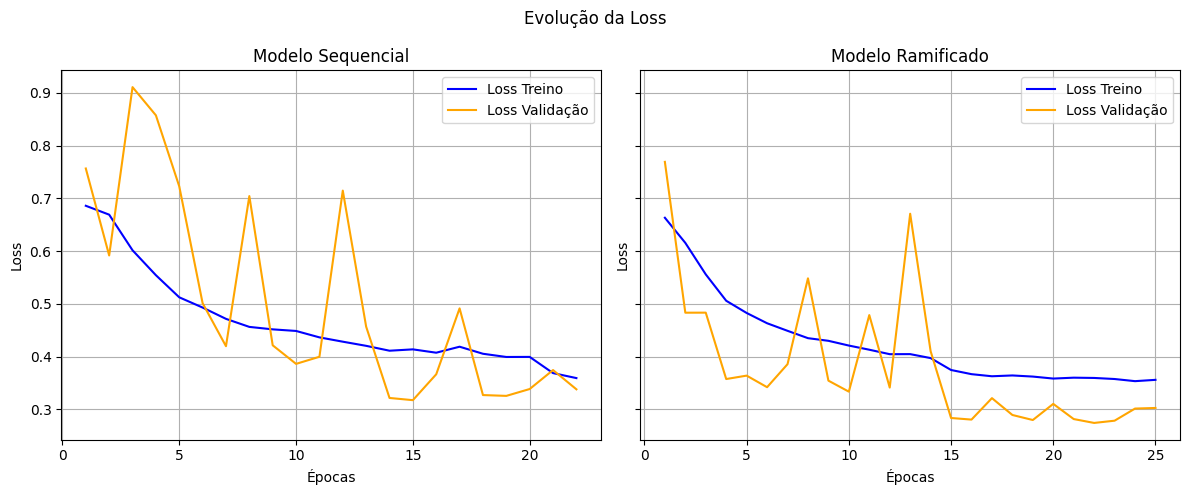

In [56]:
plot_training_history([best_seq_history, best_ram_history], titles=titles)

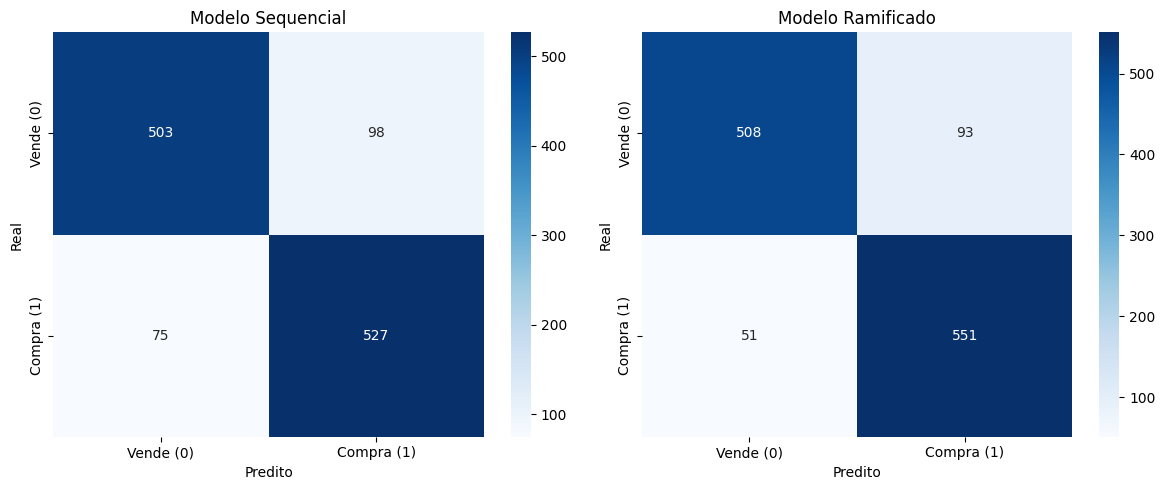

In [57]:
plot_confusion_matrix([best_seq_metrics, best_ram_metrics], titles=titles)

In [58]:
show_classification_reports(
    metrics_list=[best_seq_metrics, best_ram_metrics],
    titles=titles
)

📊 Relatório de Classificação - Modelo Sequencial

Vende (0):
Precision: 0.87
Recall:    0.84
F1-Score:  0.85

Compra (1):
Precision: 0.84
Recall:    0.88
F1-Score:  0.86

Médias:
Acurácia:  0.86
Precision: 0.86
Recall:    0.86
F1-Score:  0.86


📊 Relatório de Classificação - Modelo Ramificado

Vende (0):
Precision: 0.91
Recall:    0.85
F1-Score:  0.88

Compra (1):
Precision: 0.86
Recall:    0.92
F1-Score:  0.88

Médias:
Acurácia:  0.88
Precision: 0.88
Recall:    0.88
F1-Score:  0.88




In [59]:
resultado_backtest = run_backtest(
    predictions=best_seq_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Sequencial",
    stock_name="VALE3",
    metrics = best_seq_metrics,
    cdi_df=cdi,
    metric_optimization = metric_optimization)

resultado_backtest = run_backtest(
    predictions=best_ram_y_pred,
    prices=prices,
    capital=10000,
    model_name="CNN Ramificado",
    stock_name="VALE3",
    metrics = best_ram_metrics,
    cdi_df=cdi,
    metric_optimization = metric_optimization)

resultado_backtest

<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]
<ipython-input-17-cadec49cf654>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_atual = prices[i]


,Data,Modelo,Ação,Métrica de Otimização,Acurácia,Precision,Recall,F1,Matriz de Confusão,Saldo Inicial,Saldo Final,Total de Ações,Lucro Total,Lucro (%),Lucro (%) CDI
0,2025-04-13 14:10:15.041119,CNN Sequencial,CSAN3,val_loss,0.885329,0.882166,0.882586,0.882373,"[[619, 69], [67, 431]]",10000,3.640817,990.0,9467.040666,94.670407,42.269210
1,2025-04-13 14:10:15.069407,CNN Ramificado,CSAN3,val_loss,0.881956,0.880287,0.876629,0.878284,"[[626, 62], [78, 420]]",10000,8.435907,1065.0,10946.335745,109.463357,42.269210
2,2025-04-13 14:37:38.702181,CNN Sequencial,BBAS3,val_loss,0.865823,0.861527,0.864002,0.862654,"[[603, 86], [73, 423]]",10000,39.235968,247.0,3720.565817,37.205658,42.269210
3,2025-04-13 14:37:38.727148,CNN Ramificado,BBAS3,val_loss,0.898734,0.897139,0.894281,0.895610,"[[635, 54], [66, 430]]",10000,38.974524,310.0,7209.874334,72.098743,42.269210
4,2025-04-13 15:02:36.679384,CNN Sequencial,PETR4,val_loss,0.831255,0.839039,0.828591,0.829323,"[[436, 145], [58, 564]]",10000,1.062806,809.0,20128.224164,201.282242,42.937875
5,2025-04-13 15:02:36.703969,CNN Ramificado,PETR4,val_loss,0.848712,0.850201,0.847515,0.848089,"[[472, 109], [73, 549]]",10000,12.695825,817.0,20437.777196,204.377772,42.937875
6,2025-04-13 15:25:11.472139,CNN Sequencial,VALE3,val_loss,0.856193,0.856721,0.856177,0.856136,"[[503, 98], [75, 527]]",10000,13.402445,258.0,9931.001657,99.310017,42.937875
7,2025-04-13 15:25:11.497284,CNN Ramificado,VALE3,val_loss,0.880299,0.882178,0.880270,0.880146,"[[508, 93], [51, 551]]",10000,69.179995,261.0,10218.379198,102.183792,42.937875


A arquitetura de rede CNN ramificada foi a vencedora em ambos os ativos, então levaremos ela para a pipeline comlpeta do modelo campeão

## Pipeline completa com arquitetura campeã